In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              13                   1           AC            SVE   
1              13                   1           AC            SVE   
2              13                   1           AC            SVE   
3              13                   1           AC            SVE   
4              13                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo  \
0   VENTA COMPUTARIZADA          18112062                  0   
1   VENTA COMPUTARIZADA          18112055                  0   
2   VENTA COMPUTARIZADA          18112052                  0   
3   VENTA COMPUTARIZADA          18112050                  0   
4   VENTA COMPUTARIZADA          18112049                  0   

       FechaMovimiento       NombreProducto UnidadMedida  CantidadSalida  \
0  2018-11-16 07:02:58  PIERNA MUSLO OFERTA           KG          0.0000   
1  2018-11-15 12:53:48      FILETE A GRANEL           KG          0.0000   
2  2018-11-15 12:12:18      FILETE A GRANEL           KG          0.0000   
3  2018-11-15 12:09:52      FILETE A GRANEL           KG          0.0000   
4  2018-11-15 12:05:05               PIERNA           KG          0.0000   

   PesoSalida  MontoBase  PrecioUnitario  CostoUnitario  MontoReferencia  \
0      1.0433    14.6280         12.8800        12.8800           2.1013   
1      1.9826    47.0120         21.8040        21.8040           6.7546   
2      1.9246    45.6320         21.8040        21.8040           6.5559   
3      0.8418    19.9640         21.8040        21.8040           2.8686   
4      0.1334     2.1160         14.7200        14.7200           0.3036   

  NombreGrupo  
0     TROZADO  
1     TROZADO  
2     TROZADO  
3     TROZADO  
4     TROZADO

In [ ]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [ ]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] <= '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[df_todo['FechaMovimiento'] < '2023-11-01']

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (206029, 4)
sin noviembre  (203613, 4)
noviembre 2023  (2416, 4)


In [ ]:
df_noviembre.head()

NombreProducto     FechaMovimiento  MontoBase  year
120927              PIERNA MUSLO 2023-11-01 07:21:12    21.9512  2023
206231            POLLO ESPECIAL 2023-11-01 07:24:55    25.4006  2023
120926                   PECHUGA 2023-11-01 07:27:01    40.6456  2023
206230  POLLO SIN MENUDENCIA H-C 2023-11-01 07:37:40    26.8691  2023
206229  POLLO SIN MENUDENCIA H-C 2023-11-01 07:45:05    28.0528  2023

## EVALUACION

In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [ ]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# 10 Productos


In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
# se suman todas las ventas por dia
# df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

# df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
# df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
# print("----Prophet----")
# print(df_noviembre_prophet.head)
# print(df_noviembre_prophet.dtypes)
# print(df_todo_hasta_nov_prophet.head)
# print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
120927              PIERNA MUSLO      2023-11-01    21.9512  2023
206231            POLLO ESPECIAL      2023-11-01    25.4006  2023
120926                   PECHUGA      2023-11-01    40.6456  2023
206230  POLLO SIN MENUDENCIA H-C      2023-11-01    26.8691  2023
206229  POLLO SIN MENUDENCIA H-C      2023-11-01    28.0528  2023
...                          ...             ...        ...   ...
121750               ALA PRIMERA      2023-11-30     3.3304  2023
205336  POLLO SIN MENUDENCIA H-C      2023-11-30    29.1386  2023
205335            POLLO ESPECIAL      2023-11-30   120.9510  2023
121748               ALA PRIMERA      2023-11-30    16.6520  2023
205334            POLLO ESPECIAL      2023-11-30    53.4890  2023

[2416 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

df_todo_hasta_nov_sin_2020 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year == 2020)]

print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print("todo hasta nov")
print(df_todo_hasta_nov.dtypes)

# se devuelve el tipo object a FechaMovimiento para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
#df_todo_hasta_nov_sin_2020['FechaMovimiento'] = df_todo_hasta_nov_sin_2020['FechaMovimiento'].dt.date

print("todo hasta nov")
print(df_todo_hasta_nov.dtypes)

print("---" *10)
print(df_todo_hasta_nov_sin_2020.head())
print(df_todo_hasta_nov_sin_2020.dtypes)
print(df_todo_hasta_nov_sin_2020.shape)

             NombreProducto FechaMovimiento  MontoBase  year
1267        FILETE A GRANEL      2018-11-01    47.1960  2018
122360       POLLO ESPECIAL      2018-11-01   120.1500  2018
1266    PIERNA MUSLO OFERTA      2018-11-01    66.2400  2018
1265    PIERNA MUSLO OFERTA      2018-11-01    44.7120  2018
1263                 PIERNA      2018-11-01     5.0600  2018
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
todo hasta nov
NombreProducto             object
FechaMovimiento    datetime64[ns]
MontoBase                 float64
year                        int64
dtype: object
todo hasta nov
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
------------------------------
             NombreProducto FechaMovimiento  MontoBase  year
1267        FILETE A GRANEL      2018-11-01    47.1960  2018
122360       POLLO ESPECIAL  

### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [ ]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
#dfs_de_productos = {}
dfs_de_productos_con_2020 = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    # Crear un DataFrame para el producto actual
#    product_df = df_todo[df_todo['NombreProducto'] == product].copy()
    product_df_con_2020 = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == product].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    # product_df.set_index('FechaMovimiento', inplace=True)
    # product_df_con_2020.set_index('FechaMovimiento', inplace=True)
#    product_df.set_index('FechaMovimiento', inplace=True)
    product_df_con_2020.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
#    dfs_de_productos[product] = product_df
    dfs_de_productos_con_2020[product] = product_df_con_2020

print(top_10_products)

Index(['POLLO ESPECIAL', 'POLLO SIN MENUDENCIA H-C', 'PECHUGA', 'PIERNA MUSLO',
       'FILETE A GRANEL', 'PIERNA', 'MUSLO', 'POLLO CON MENUDENCIA H-C',
       'PIERNA MUSLO OFERTA', 'ALA PRIMERA'],
      dtype='object')


In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos_con_2020.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    #product_df_sumado.set_index('FechaMovimiento', inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado


In [ ]:
#print(dfs_de_productos_con_2020)

#print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'])
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)
#print(dfs_de_productos_sumados)


FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
<bound method NDFrame.head of      FechaMovimiento            NombreProducto  year  MontoBase
0         2018-11-08  POLLO SIN MENUDENCIA H-C  2018   533.0210
1         2018-11-09  POLLO SIN MENUDENCIA H-C  2018   149.0750
2         2018-11-10  POLLO SIN MENUDENCIA H-C  2018   315.6830
3         2018-11-11  POLLO SIN MENUDENCIA H-C  2018   267.1780
4         2018-11-12  POLLO SIN MENUDENCIA H-C  2018   181.6490
...              ...                       ...   ...        ...
1613      2023-10-27  POLLO SIN MENUDENCIA H-C  2023   816.5305
1614      2023-10-28  POLLO SIN MENUDENCIA H-C  2023   927.1219
1615      2023-10-29  POLLO SIN MENUDENCIA H-C  2023  1241.6123
1616      2023-10-30  POLLO SIN MENUDENCIA H-C  2023   652.0852
1617      2023-10-31  POLLO SIN MENUDENCIA H-C  2023   654.0076

[1618 rows x 4 columns]>


In [ ]:
# Resetear el índice sin incluirlo como columna
#product_df.reset_index(drop=True, inplace=True)

In [ ]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')
    #last_day_oct_2023 = datetime(2023, 10, 31)

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Convertir la columna 'FechaMovimiento' al tipo datetime
        product_df['FechaMovimiento'] = pd.to_datetime(product_df['FechaMovimiento'])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")
        print(product_df.dtypes)
    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)y

Se agregó un registro de venta 0 para el producto POLLO CON MENUDENCIA H-C en la fecha 2023-10-31 00:00:00
FechaMovimiento    datetime64[ns]
NombreProducto             object
year                        int64
MontoBase                 float64
dtype: object
Se agregó un registro de venta 0 para el producto PIERNA MUSLO OFERTA en la fecha 2023-10-31 00:00:00
FechaMovimiento    datetime64[ns]
NombreProducto             object
year                        int64
MontoBase                 float64
dtype: object


<ipython-input-71-142d78c3a610>:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-71-142d78c3a610>:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-71-142d78c3a610>:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-71-142d78c3a610>:10: FutureWarn

In [ ]:
print(dfs_de_productos_sumados)

{'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
FechaMovimiento                                 
2018-11-01       POLLO ESPECIAL  2018  1140.6240
2018-11-02       POLLO ESPECIAL  2018  1645.2540
2018-11-03       POLLO ESPECIAL  2018   712.9790
2018-11-04       POLLO ESPECIAL  2018  1343.6330
2018-11-05       POLLO ESPECIAL  2018  1755.2580
...                         ...   ...        ...
2023-10-27       POLLO ESPECIAL  2023  2152.1624
2023-10-28       POLLO ESPECIAL  2023  2499.2891
2023-10-29       POLLO ESPECIAL  2023  1611.2471
2023-10-30       POLLO ESPECIAL  2023  3372.2990
2023-10-31       POLLO ESPECIAL  2023  2112.0323

[1698 rows x 3 columns], 'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2018-11-08       POLLO SIN MENUDENCIA H-C  2018   533.0210
2018-11-09       POLLO SIN MENUDENCIA H-C  2018   149.0750
2018-11-10       POLLO SIN MENUDENCIA H-C  2018   315.

In [ ]:
# unique_products = df_todo['NombreProducto'].unique()
# print(unique_products)

In [ ]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [ ]:
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO CON MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2018-11-08       POLLO CON MENUDENCIA H-C  2018   369.1720
2018-11-10       POLLO CON MENUDENCIA H-C  2018   293.0770
2018-11-11       POLLO CON MENUDENCIA H-C  2018   458.7060
2018-11-12       POLLO CON MENUDENCIA H-C  2018   238.2530
2018-11-13       POLLO CON MENUDENCIA H-C  2018   798.3300
...                                   ...   ...        ...
2023-10-20       POLLO CON MENUDENCIA H-C  2023   435.4058
2023-10-21       POLLO CON MENUDENCIA H-C  2023   242.3203
2023-10-22       POLLO CON MENUDENCIA H-C  2023   329.3979
2023-10-30       POLLO CON MENUDENCIA H-C  2023   470.8990
2023-10-31       POLLO CON MENUDENCIA H-C  2023     0.0000

[993 rows x 3 columns]>


In [ ]:
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO CON MENUDENCIA H-C'].head)

ds                datetime64[ns]
NombreProducto            object
y                        float64
dtype: object
<bound method NDFrame.head of             ds            NombreProducto        y
0   2018-11-08  POLLO CON MENUDENCIA H-C 369.1720
1   2018-11-10  POLLO CON MENUDENCIA H-C 293.0770
2   2018-11-11  POLLO CON MENUDENCIA H-C 458.7060
3   2018-11-12  POLLO CON MENUDENCIA H-C 238.2530
4   2018-11-13  POLLO CON MENUDENCIA H-C 798.3300
..         ...                       ...      ...
988 2023-10-20  POLLO CON MENUDENCIA H-C 435.4058
989 2023-10-21  POLLO CON MENUDENCIA H-C 242.3203
990 2023-10-22  POLLO CON MENUDENCIA H-C 329.3979
991 2023-10-30  POLLO CON MENUDENCIA H-C 470.8990
992 2023-10-31  POLLO CON MENUDENCIA H-C   0.0000

[993 rows x 3 columns]>


In [ ]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

              ds  NombreProducto         y
0     2018-11-01  POLLO ESPECIAL 1140.6240
1     2018-11-02  POLLO ESPECIAL 1645.2540
2     2018-11-03  POLLO ESPECIAL  712.9790
3     2018-11-04  POLLO ESPECIAL 1343.6330
4     2018-11-05  POLLO ESPECIAL 1755.2580
...          ...             ...       ...
1693  2023-10-27  POLLO ESPECIAL 2152.1624
1694  2023-10-28  POLLO ESPECIAL 2499.2891
1695  2023-10-29  POLLO ESPECIAL 1611.2471
1696  2023-10-30  POLLO ESPECIAL 3372.2990
1697  2023-10-31  POLLO ESPECIAL 2112.0323

[1698 rows x 3 columns]
              ds            NombreProducto         y
0     2018-11-08  POLLO SIN MENUDENCIA H-C  533.0210
1     2018-11-09  POLLO SIN MENUDENCIA H-C  149.0750
2     2018-11-10  POLLO SIN MENUDENCIA H-C  315.6830
3     2018-11-11  POLLO SIN MENUDENCIA H-C  267.1780
4     2018-11-12  POLLO SIN MENUDENCIA H-C  181.6490
...          ...                       ...       ...
1613  2023-10-27  POLLO SIN MENUDENCIA H-C  816.5305
1614  2023-10-28  POLLO SIN MENUDEN

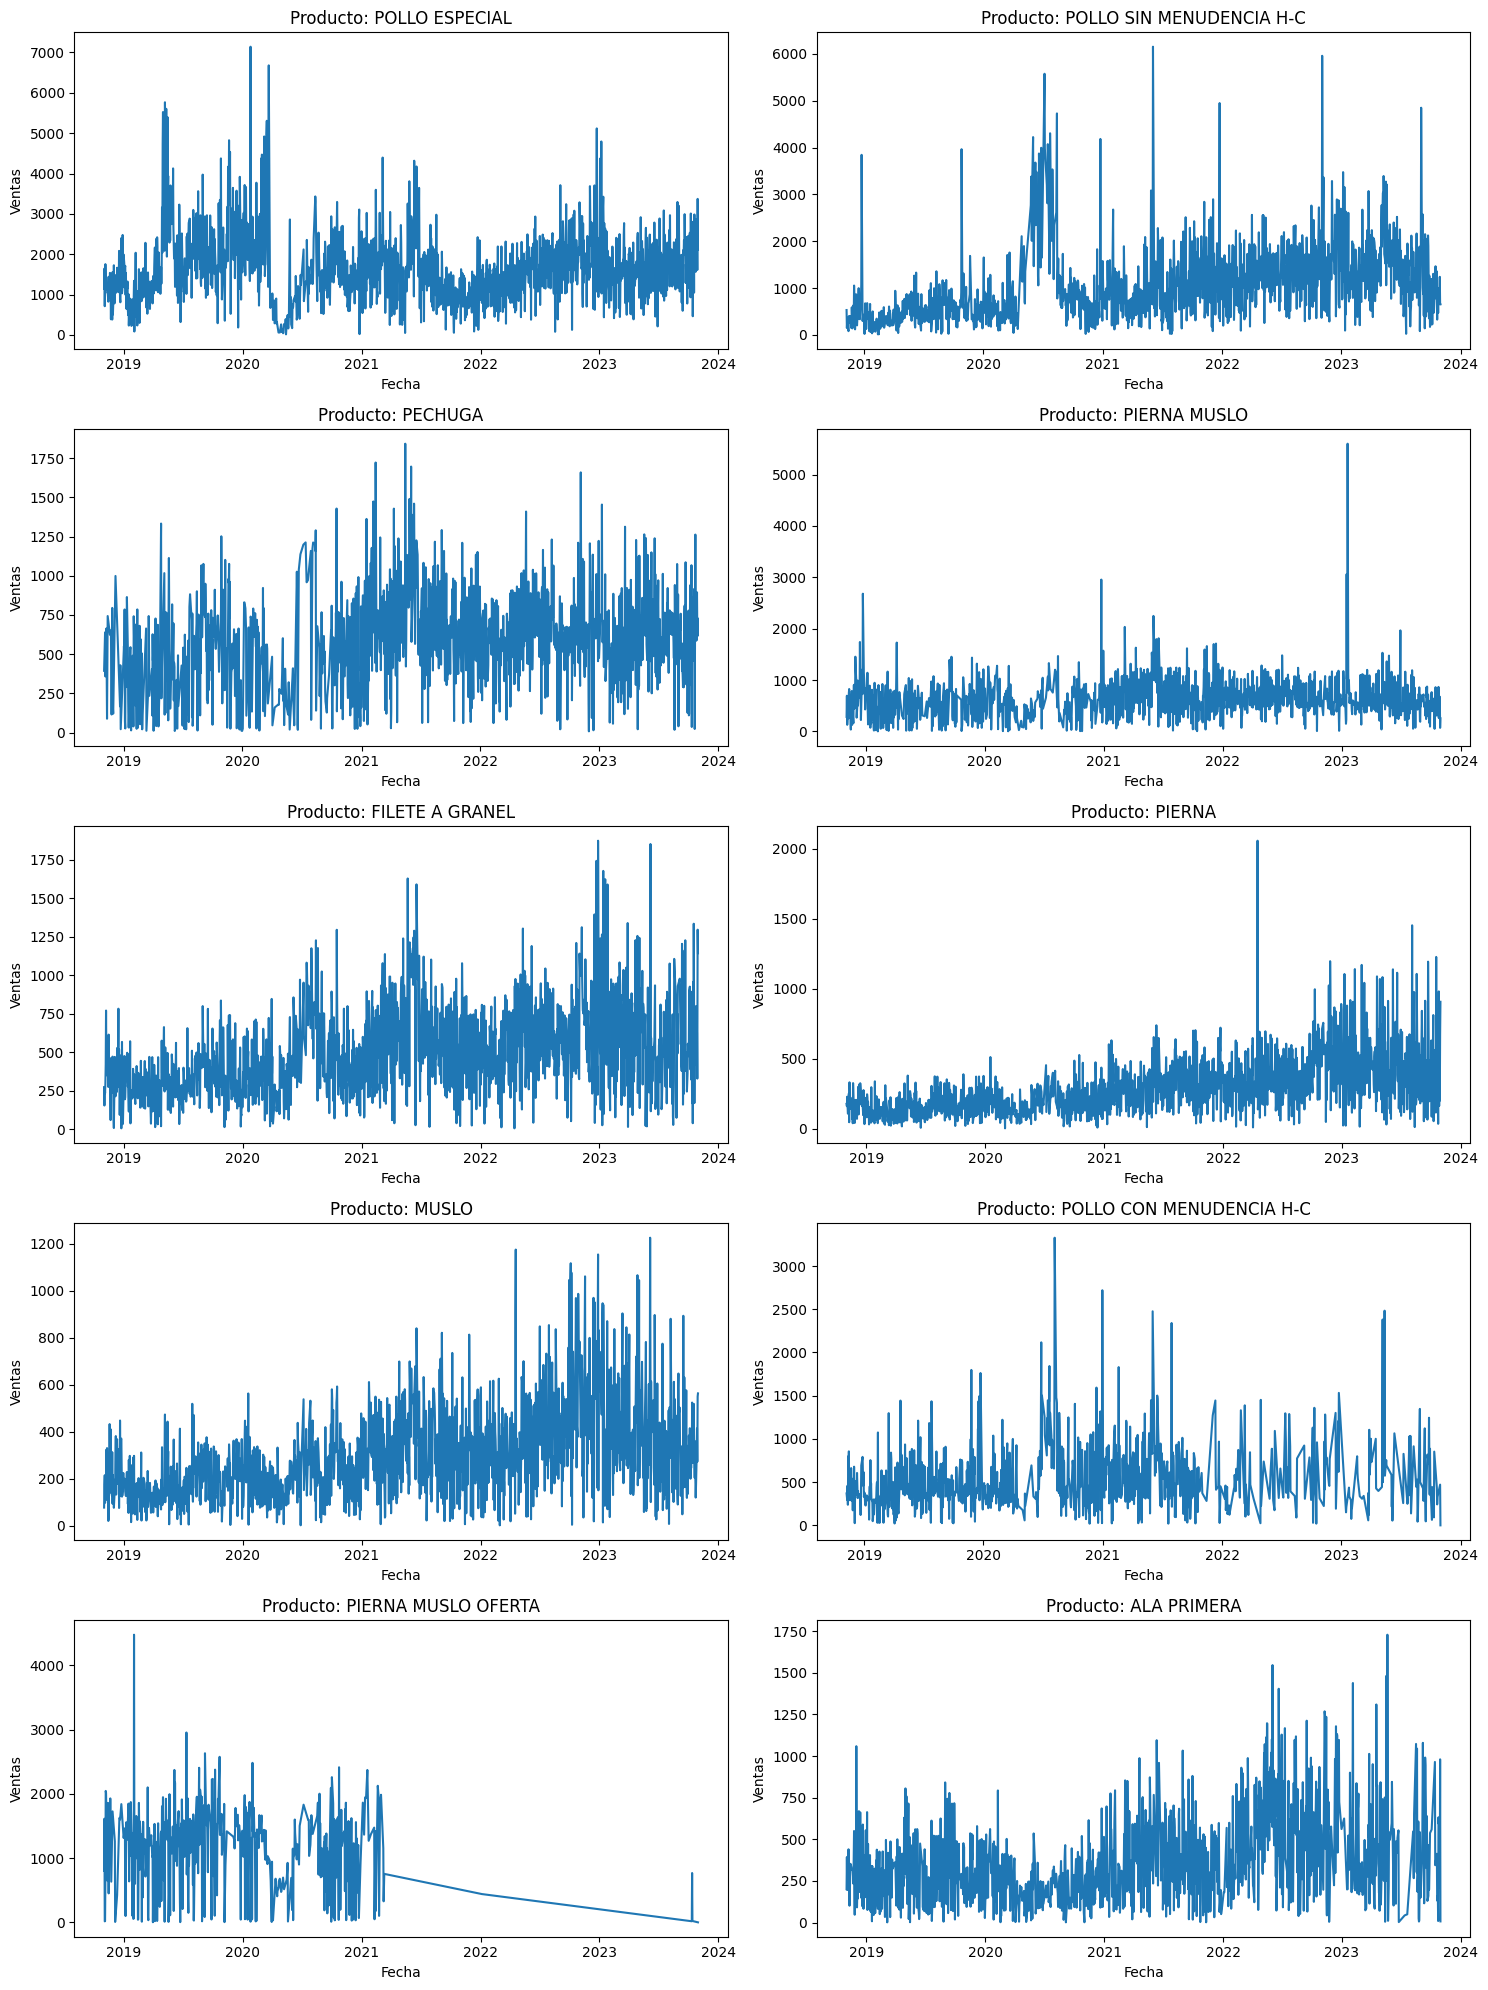

In [ ]:
# Crear una figura y ejes para los gráficos
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Cambia el tamaño según sea necesario

# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Calcular las coordenadas de los subgráficos
    row, col = divmod(i, 2)

    # Crear un gráfico de líneas para cada producto
    axs[row, col].plot(product_df['ds'], product_df['y'], label=product)
    axs[row, col].set_title(f'Producto: {product}')
    axs[row, col].set_xlabel('Fecha')
    axs[row, col].set_ylabel('Ventas')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

In [ ]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 4 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 5 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 6 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 7 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 8 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 9 - Tipos de D

### clonar para LSTM y ARIMA


In [ ]:
dfs_de_productos_sumados

{'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
 FechaMovimiento                                 
 2018-11-01       POLLO ESPECIAL  2018  1140.6240
 2018-11-02       POLLO ESPECIAL  2018  1645.2540
 2018-11-03       POLLO ESPECIAL  2018   712.9790
 2018-11-04       POLLO ESPECIAL  2018  1343.6330
 2018-11-05       POLLO ESPECIAL  2018  1755.2580
 ...                         ...   ...        ...
 2023-10-27       POLLO ESPECIAL  2023  2152.1624
 2023-10-28       POLLO ESPECIAL  2023  2499.2891
 2023-10-29       POLLO ESPECIAL  2023  1611.2471
 2023-10-30       POLLO ESPECIAL  2023  3372.2990
 2023-10-31       POLLO ESPECIAL  2023  2112.0323
 
 [1698 rows x 3 columns],
 'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2018-11-08       POLLO SIN MENUDENCIA H-C  2018   533.0210
 2018-11-09       POLLO SIN MENUDENCIA H-C  2018   149.0750
 2018-11-10       POLLO SIN MENUDENC

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Convertir el índice a tipo DatetimeIndex (si no lo es)
    if not isinstance(product_df_lstm.index, pd.DatetimeIndex):
        product_df_lstm.index = pd.to_datetime(product_df_lstm.index)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    # Eliminar la columna 'year'
    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)
    # para visualizar el correcto funcionamiento del codigo
    # print(product_df_lstm)
    # print(product_df_lstm.dtypes)

# Ahora, el índice es 'FechaMovimiento' nuevamente, puedes acceder a la columna
# 'FechaMovimiento' si es necesario después del bucle.

# Ejemplo de acceso después del bucle
# product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])
#    product_df_lstm.reset_index(inplace=True)

In [ ]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

In [ ]:
print(dfs_de_productos_sumados_arima['PECHUGA'])

                NombreProducto  MontoBase
FechaMovimiento                          
2018-11-02             PECHUGA   393.6680
2018-11-03             PECHUGA   477.7560
2018-11-05             PECHUGA   639.1240
2018-11-06             PECHUGA   357.7880
2018-11-09             PECHUGA   663.6880
...                        ...        ...
2023-10-27             PECHUGA   588.4136
2023-10-28             PECHUGA   894.3688
2023-10-29             PECHUGA   627.5044
2023-10-30             PECHUGA   728.9160
2023-10-31             PECHUGA   620.0156

[1376 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [ ]:
# Obtener los 10 productos más vendidos
top_10_products = df_todo['NombreProducto'].value_counts().head(10).index

# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_10_products:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [ ]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350
2023-11-16       POLLO SIN MENUDENCIA H-C   943.6492
2023-11-17       POLLO SIN MENUDENCIA H-C   683.4933
2023-11-18       POLLO SIN MENUDENCIA H-C   77

In [ ]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-17'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex(['2023-11-10'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO SIN MENUDENCIA H-C en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PECHUGA son: DatetimeIndex(['2023-11-05', '2023-11-07', '2023-11-24', '2023-11-25',
               '2023-11-27', '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PECHUGA en las fechas faltantes.
Se agregaron 7 registros de venta 0 para el producto PECHUGA e

In [ ]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Convertir el índice a objetos datetime y luego quitar la información de tiempo
#     product_df.index = pd.to_datetime(product_df.index).date

#     # Imprimir información sobre el producto
#     print(f"DataFrame actualizado para el producto {product}:\n{product_df}")
# print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].head(5))

In [ ]:
print(dfs_noviembre_sumados)
#print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['PIERNA MUSLO OFERTA'])

{'POLLO ESPECIAL':                  NombreProducto  MontoBase
FechaMovimiento                           
2023-11-01       POLLO ESPECIAL  1999.7321
2023-11-02       POLLO ESPECIAL  1011.2892
2023-11-03       POLLO ESPECIAL  2343.7883
2023-11-04       POLLO ESPECIAL  1673.2089
2023-11-05       POLLO ESPECIAL  1181.9289
2023-11-06       POLLO ESPECIAL   863.7984
2023-11-07       POLLO ESPECIAL  1648.4580
2023-11-08       POLLO ESPECIAL  1434.6711
2023-11-09       POLLO ESPECIAL  1680.6493
2023-11-10       POLLO ESPECIAL  1767.7892
2023-11-11       POLLO ESPECIAL  1634.3693
2023-11-12       POLLO ESPECIAL   773.2943
2023-11-13       POLLO ESPECIAL  1415.9722
2023-11-14       POLLO ESPECIAL  1897.6758
2023-11-15       POLLO ESPECIAL  2099.2341
2023-11-16       POLLO ESPECIAL  1211.0052
2023-11-17       POLLO ESPECIAL     0.0000
2023-11-18       POLLO ESPECIAL  1232.0448
2023-11-19       POLLO ESPECIAL   220.6310
2023-11-20       POLLO ESPECIAL  1145.2787
2023-11-21       POLLO ESPECIAL  11

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/aynqt9_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/xcwn3__0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80059', 'data', 'file=/tmp/tmp80i8su6s/aynqt9_w.json', 'init=/tmp/tmp80i8su6s/xcwn3__0.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modeltd_nmrt7/prophet_model-20240222201249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


              ds  NombreProducto         y
0     2018-11-01  POLLO ESPECIAL 1140.6240
1     2018-11-02  POLLO ESPECIAL 1645.2540
2     2018-11-03  POLLO ESPECIAL  712.9790
3     2018-11-04  POLLO ESPECIAL 1343.6330
4     2018-11-05  POLLO ESPECIAL 1755.2580
...          ...             ...       ...
1693  2023-10-27  POLLO ESPECIAL 2152.1624
1694  2023-10-28  POLLO ESPECIAL 2499.2891
1695  2023-10-29  POLLO ESPECIAL 1611.2471
1696  2023-10-30  POLLO ESPECIAL 3372.2990
1697  2023-10-31  POLLO ESPECIAL 2112.0323

[1698 rows x 3 columns]


20:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


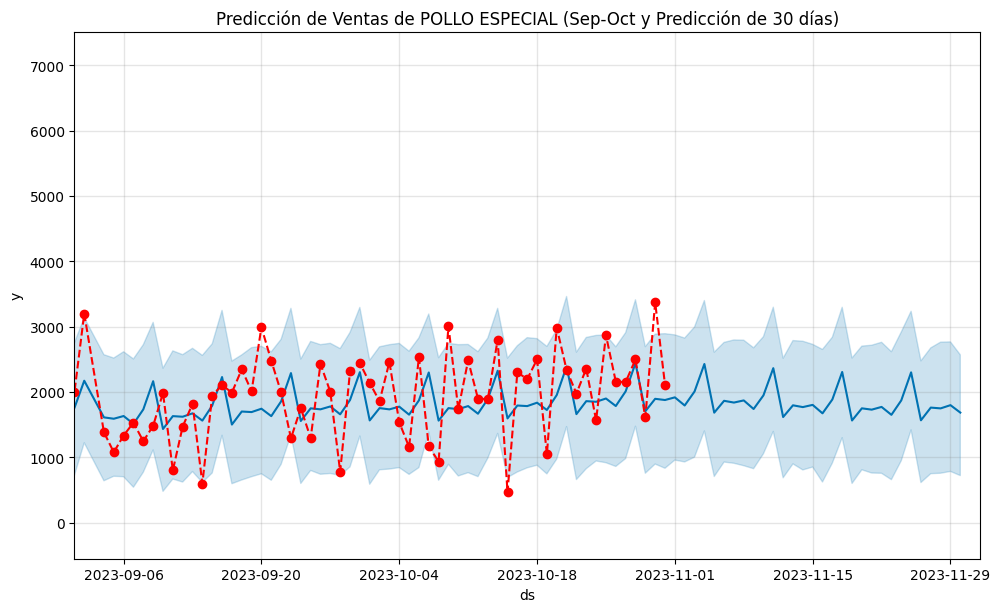

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/l2hlbstb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/xggp4krg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77263', 'data', 'file=/tmp/tmp80i8su6s/l2hlbstb.json', 'init=/tmp/tmp80i8su6s/xggp4krg.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_model75nf06n6/prophet_model-20240222201250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


Predicción con todos los valores para POLLO ESPECIAL:
             ds      yhat
1698 2023-11-01 1918.6519
1699 2023-11-02 1794.0805
1700 2023-11-03 2008.2326
1701 2023-11-04 2429.0343
1702 2023-11-05 1684.4395
1703 2023-11-06 1865.7316
1704 2023-11-07 1838.9538
1705 2023-11-08 1871.8651
1706 2023-11-09 1740.4964
1707 2023-11-10 1948.9530
1708 2023-11-11 2365.2701
1709 2023-11-12 1617.4811
1710 2023-11-13 1796.9194
1711 2023-11-14 1769.6468
1712 2023-11-15 1803.4111
1713 2023-11-16 1674.2026
1714 2023-11-17 1886.0587
1715 2023-11-18 2306.9219
1716 2023-11-19 1564.7112
1717 2023-11-20 1750.6278
1718 2023-11-21 1730.5871
1719 2023-11-22 1772.1809
1720 2023-11-23 1651.2379
1721 2023-11-24 1871.6327
1722 2023-11-25 2301.1479
1723 2023-11-26 1567.5501
1724 2023-11-27 1761.8978
1725 2023-11-28 1749.9778
1726 2023-11-29 1799.2690
1727 2023-11-30 1685.5052
              ds            NombreProducto         y
0     2018-11-08  POLLO SIN MENUDENCIA H-C  533.0210
1     2018-11-09  POLLO SIN MENUDE

20:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


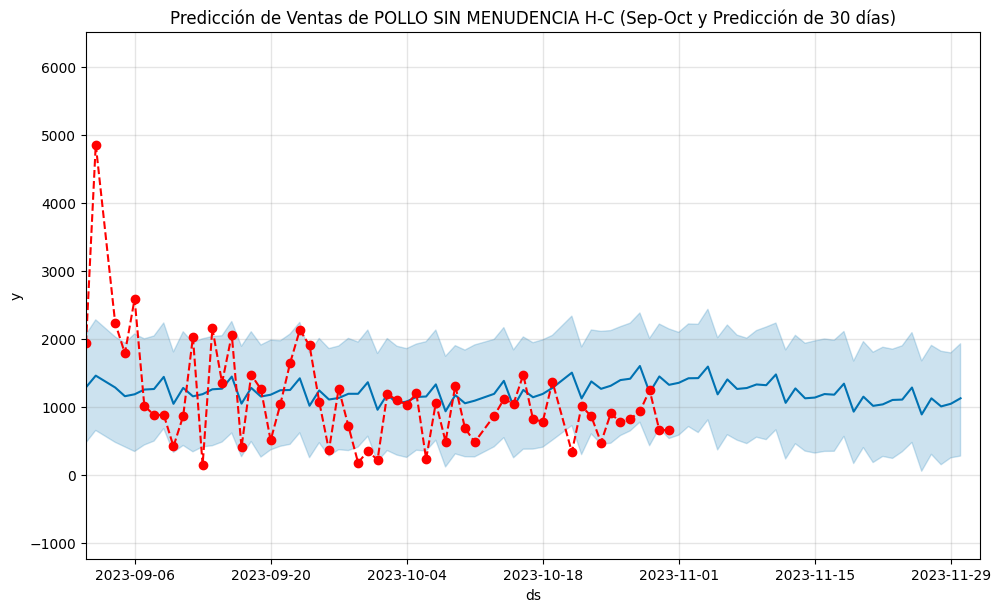

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/2kb502wb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/43grodyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41404', 'data', 'file=/tmp/tmp80i8su6s/2kb502wb.json', 'init=/tmp/tmp80i8su6s/43grodyc.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modeleb1csl4q/prophet_model-20240222201251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
1618 2023-11-01 1348.5575
1619 2023-11-02 1415.5064
1620 2023-11-03 1417.8024
1621 2023-11-04 1587.2022
1622 2023-11-05 1179.0778
1623 2023-11-06 1398.5928
1624 2023-11-07 1258.5520
1625 2023-11-08 1272.1094
1626 2023-11-09 1324.4798
1627 2023-11-10 1313.6839
1628 2023-11-11 1471.7089
1629 2023-11-12 1054.1235
1630 2023-11-13 1266.2503
1631 2023-11-14 1121.0134
1632 2023-11-15 1131.6442
1633 2023-11-16 1183.3918
1634 2023-11-17 1174.2688
1635 2023-11-18 1336.2125
1636 2023-11-19  924.7018
1637 2023-11-20 1144.9321
1638 2023-11-21 1009.6663
1639 2023-11-22 1031.9445
1640 2023-11-23 1096.7988
1641 2023-11-24 1102.0045
1642 2023-11-25 1279.2454
1643 2023-11-26  883.7370
1644 2023-11-27 1120.4062
1645 2023-11-28 1001.7477
1646 2023-11-29 1040.5385
1647 2023-11-30 1121.5582
              ds NombreProducto        y
0     2018-11-02        PECHUGA 393.6680
1     2018-11-03        PECHUGA 477.7560
2     2

20:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


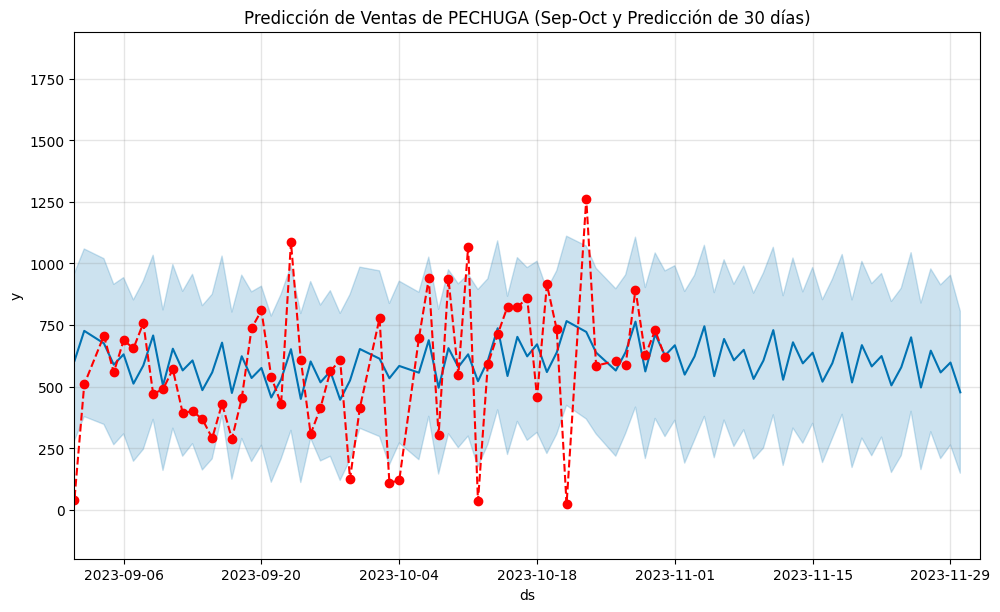

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/ycjg5k18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/qzpagsbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28534', 'data', 'file=/tmp/tmp80i8su6s/ycjg5k18.json', 'init=/tmp/tmp80i8su6s/qzpagsbw.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modelm9c10ulf/prophet_model-20240222201252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PECHUGA:
             ds     yhat
1376 2023-11-01 668.0308
1377 2023-11-02 548.9720
1378 2023-11-03 622.7579
1379 2023-11-04 745.1595
1380 2023-11-05 542.5822
1381 2023-11-06 693.5469
1382 2023-11-07 607.1327
1383 2023-11-08 649.5476
1384 2023-11-09 531.3032
1385 2023-11-10 606.0715
1386 2023-11-11 729.5529
1387 2023-11-12 528.0820
1388 2023-11-13 680.1114
1389 2023-11-14 594.6562
1390 2023-11-15 637.8660
1391 2023-11-16 520.2029
1392 2023-11-17 595.2979
1393 2023-11-18 718.8215
1394 2023-11-19 517.0895
1395 2023-11-20 668.5478
1396 2023-11-21 582.2166
1397 2023-11-22 624.2626
1398 2023-11-23 505.1758
1399 2023-11-24 578.6256
1400 2023-11-25 700.3298
1401 2023-11-26 496.6589
1402 2023-11-27 646.1196
1403 2023-11-28 557.7964
1404 2023-11-29 597.9224
1405 2023-11-30 477.0539
              ds NombreProducto        y
0     2018-11-03   PIERNA MUSLO 282.6240
1     2018-11-04   PIERNA MUSLO 694.2320
2     2018-11-05   PIERNA MUSLO 128.4320
3     2018-11-

20:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


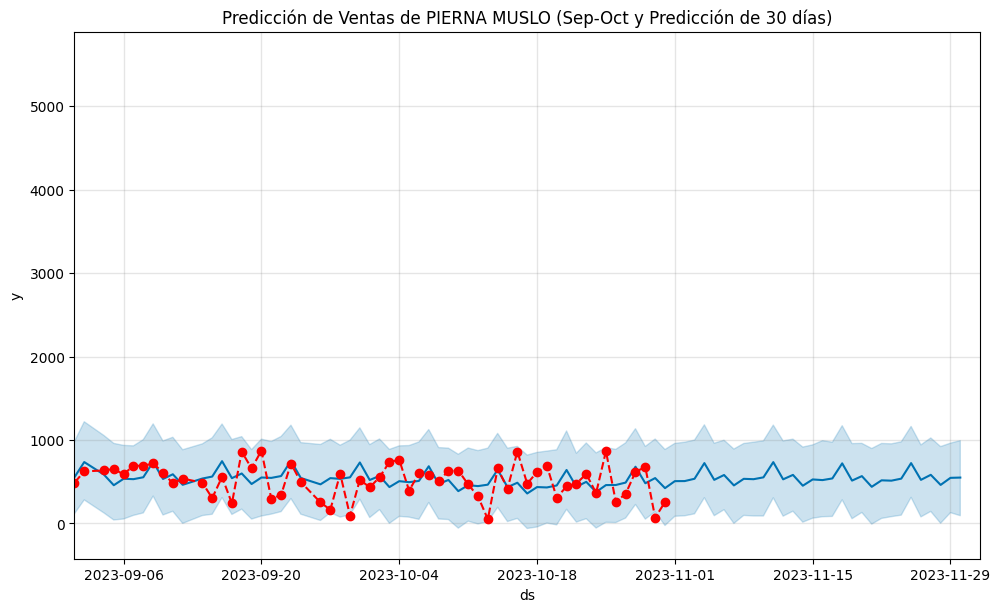

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/j3ll8g_a.json


Predicción con todos los valores para PIERNA MUSLO:
             ds     yhat
1385 2023-11-01 506.7092
1386 2023-11-02 507.5523
1387 2023-11-03 535.1856
1388 2023-11-04 722.9599
1389 2023-11-05 522.2006
1390 2023-11-06 580.3331
1391 2023-11-07 455.4611
1392 2023-11-08 534.3830
1393 2023-11-09 529.9994
1394 2023-11-10 552.2075
1395 2023-11-11 734.5205
1396 2023-11-12 528.4283
1397 2023-11-13 581.5189
1398 2023-11-14 452.0519
1399 2023-11-15 526.9709
1400 2023-11-16 519.3072
1401 2023-11-17 539.0704
1402 2023-11-18 719.8649
1403 2023-11-19 513.2473
1404 2023-11-20 566.8465
1405 2023-11-21 438.9357
1406 2023-11-22 516.4440
1407 2023-11-23 512.3600
1408 2023-11-24 536.6241
1409 2023-11-25 722.7452
1410 2023-11-26 522.1620
1411 2023-11-27 582.3645
1412 2023-11-28 461.4702
1413 2023-11-29 546.2396
1414 2023-11-30 549.4839
              ds   NombreProducto         y
0     2018-11-01  FILETE A GRANEL  273.2400
1     2018-11-02  FILETE A GRANEL  154.5600
2     2018-11-03  FILETE A GRANEL  274.06

DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/jxv8sfhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85246', 'data', 'file=/tmp/tmp80i8su6s/j3ll8g_a.json', 'init=/tmp/tmp80i8su6s/jxv8sfhe.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_model8nun6dip/prophet_model-20240222201254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


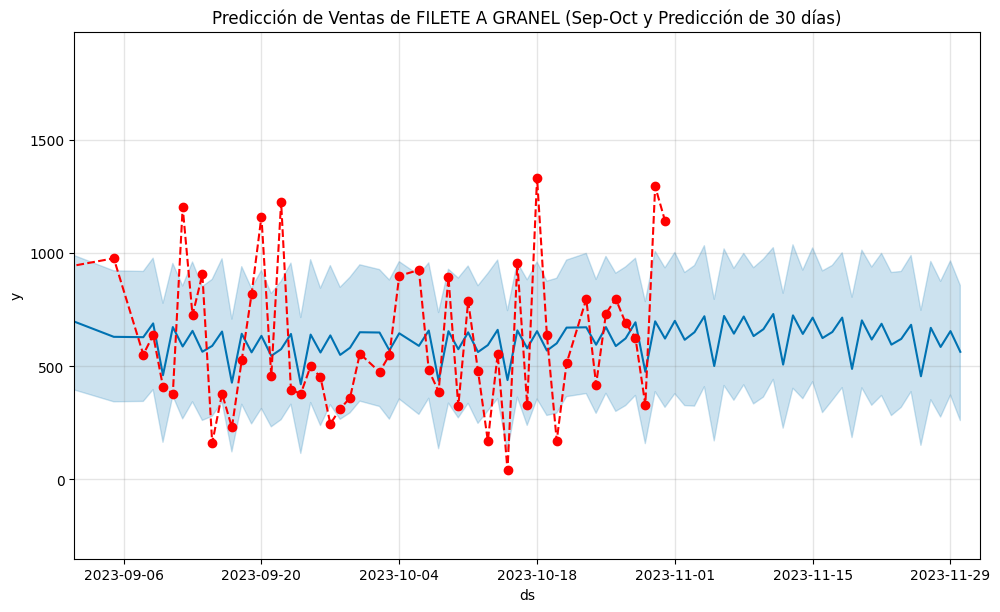

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/sr3es0x7.json


Predicción con todos los valores para FILETE A GRANEL:
             ds     yhat
1574 2023-11-01 700.5889
1575 2023-11-02 616.8279
1576 2023-11-03 650.5070
1577 2023-11-04 720.9068
1578 2023-11-05 500.7890
1579 2023-11-06 722.1726
1580 2023-11-07 643.9689
1581 2023-11-08 719.8028
1582 2023-11-09 633.2154
1583 2023-11-10 663.7626
1584 2023-11-11 730.7765
1585 2023-11-12 507.0757
1586 2023-11-13 724.7399
1587 2023-11-14 642.7434
1588 2023-11-15 714.7744
1589 2023-11-16 624.4372
1590 2023-11-17 651.3481
1591 2023-11-18 714.8965
1592 2023-11-19 487.9534
1593 2023-11-20 702.6453
1594 2023-11-21 617.9868
1595 2023-11-22 687.6993
1596 2023-11-23 595.4125
1597 2023-11-24 620.7604
1598 2023-11-25 683.1424
1599 2023-11-26 455.4320
1600 2023-11-27 669.7508
1601 2023-11-28 585.1018
1602 2023-11-29 655.1891
1603 2023-11-30 563.6198
              ds NombreProducto        y
0     2018-11-01         PIERNA 177.1000
1     2018-11-02         PIERNA 160.3560
2     2018-11-03         PIERNA 228.0680
3     

DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/1rf3bpg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42481', 'data', 'file=/tmp/tmp80i8su6s/sr3es0x7.json', 'init=/tmp/tmp80i8su6s/1rf3bpg9.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modelpgrgyy00/prophet_model-20240222201255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


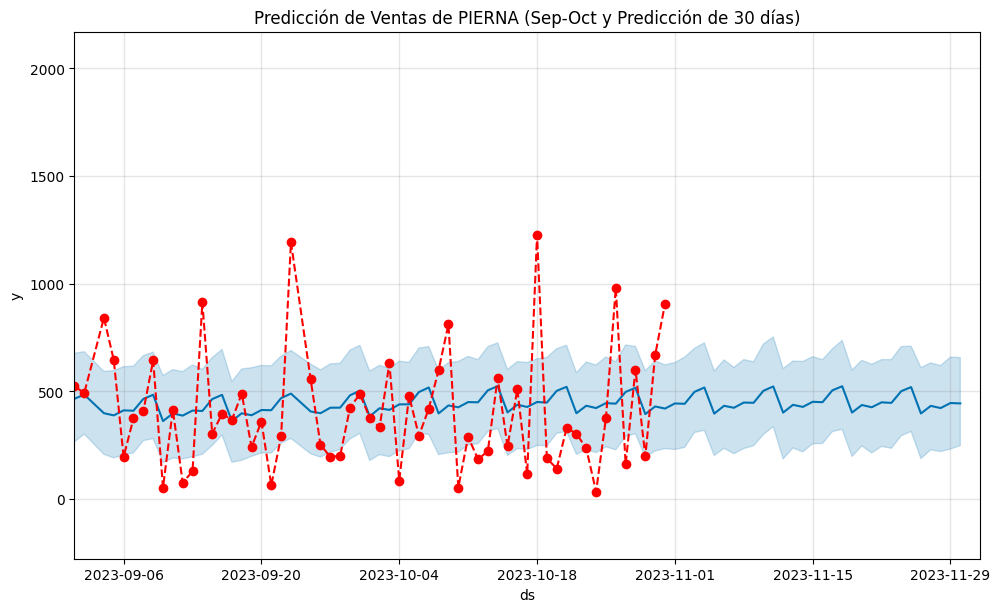

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/3kjon2vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/ffi6_eoa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61123', 'data', 'file=/tmp/tmp80i8su6s/3kjon2vm.json', 'init=/tmp/tmp80i8su6s/ffi6_eoa.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modelgt85npho/prophet_model-20240222201257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PIERNA:
             ds     yhat
1639 2023-11-01 443.8882
1640 2023-11-02 442.3443
1641 2023-11-03 497.9208
1642 2023-11-04 517.9047
1643 2023-11-05 396.6760
1644 2023-11-06 433.0667
1645 2023-11-07 423.8119
1646 2023-11-08 448.1294
1647 2023-11-09 446.9849
1648 2023-11-10 502.7922
1649 2023-11-11 522.8308
1650 2023-11-12 401.4791
1651 2023-11-13 437.5737
1652 2023-11-14 427.8607
1653 2023-11-15 451.5747
1654 2023-11-16 449.7036
1655 2023-11-17 504.6884
1656 2023-11-18 523.8396
1657 2023-11-19 401.5700
1658 2023-11-20 436.7527
1659 2023-11-21 426.1710
1660 2023-11-22 449.0967
1661 2023-11-23 446.5536
1662 2023-11-24 501.0161
1663 2023-11-25 519.8243
1664 2023-11-26 397.4162
1665 2023-11-27 432.6840
1666 2023-11-28 422.4244
1667 2023-11-29 445.9152
1668 2023-11-30 444.1790
              ds NombreProducto        y
0     2018-11-01          MUSLO  77.0960
1     2018-11-02          MUSLO 175.2600
2     2018-11-03          MUSLO 214.8200
3     2018-11-0

20:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


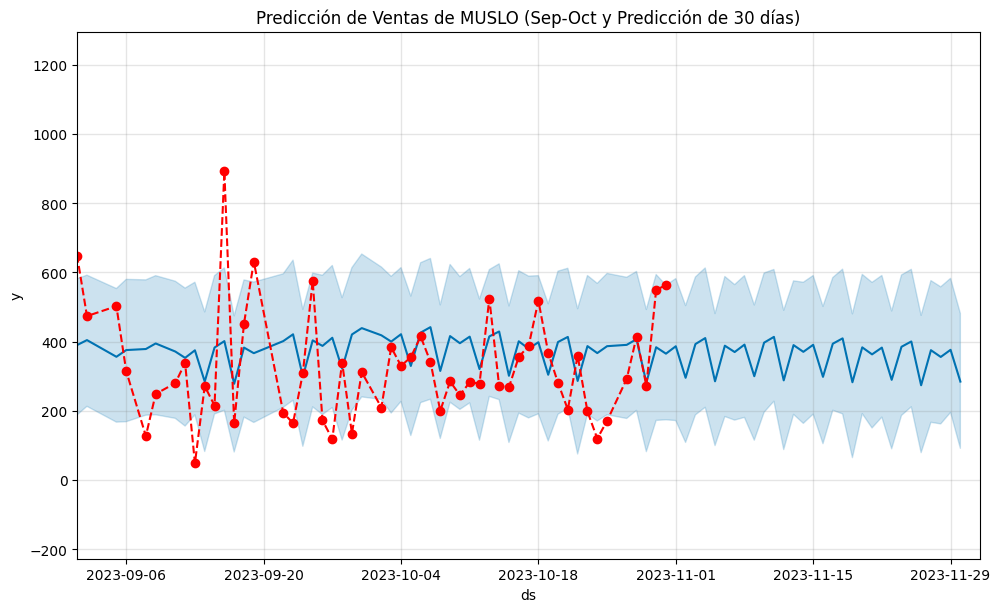

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/iwwxlvly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/vric384q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70011', 'data', 'file=/tmp/tmp80i8su6s/iwwxlvly.json', 'init=/tmp/tmp80i8su6s/vric384q.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_model2oo9exol/prophet_model-20240222201258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para MUSLO:
             ds     yhat
1556 2023-11-01 386.6455
1557 2023-11-02 295.5064
1558 2023-11-03 392.9552
1559 2023-11-04 410.2724
1560 2023-11-05 285.3744
1561 2023-11-06 388.2582
1562 2023-11-07 369.9671
1563 2023-11-08 391.3972
1564 2023-11-09 300.0549
1565 2023-11-10 397.0778
1566 2023-11-11 413.7632
1567 2023-11-12 288.0505
1568 2023-11-13 389.9640
1569 2023-11-14 370.5788
1570 2023-11-15 390.8259
1571 2023-11-16 298.2494
1572 2023-11-17 394.0260
1573 2023-11-18 409.4931
1574 2023-11-19 282.6298
1575 2023-11-20 383.4989
1576 2023-11-21 363.2118
1577 2023-11-22 382.7332
1578 2023-11-23 289.6366
1579 2023-11-24 385.1240
1580 2023-11-25 400.5527
1581 2023-11-26 273.9162
1582 2023-11-27 375.2854
1583 2023-11-28 355.7740
1584 2023-11-29 376.3422
1585 2023-11-30 284.5527
            ds            NombreProducto        y
0   2018-11-08  POLLO CON MENUDENCIA H-C 369.1720
1   2018-11-10  POLLO CON MENUDENCIA H-C 293.0770
2   2018-11-11  POLLO CON MENU

20:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


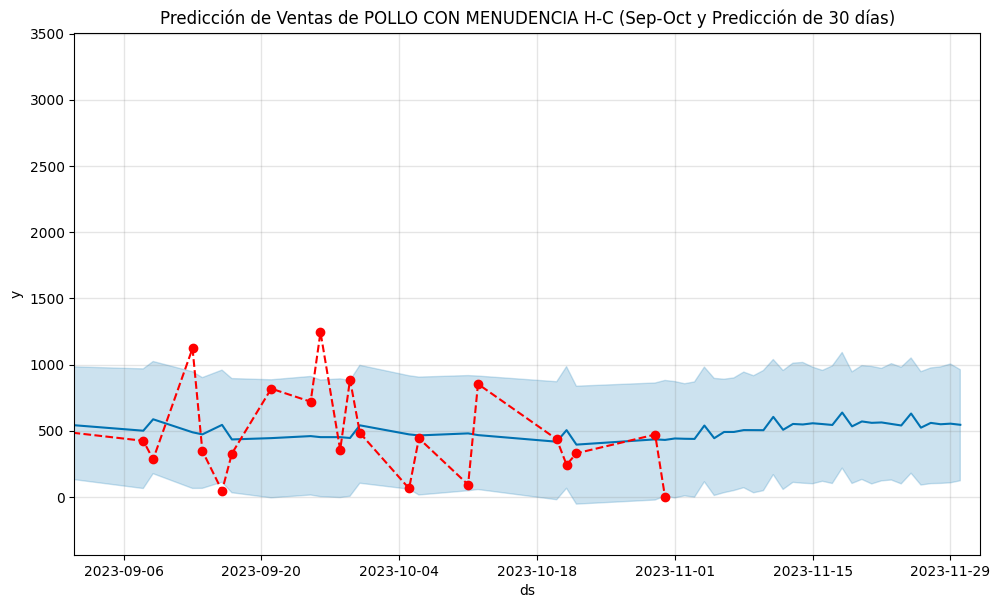

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/929yvaz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/cdcf2cn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18153', 'data', 'file=/tmp/tmp80i8su6s/929yvaz_.json', 'init=/tmp/tmp80i8su6s/cdcf2cn6.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modelggnclx5m/prophet_model-20240222201259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO CON MENUDENCIA H-C:
             ds     yhat
993  2023-11-01 441.3716
994  2023-11-02 439.1256
995  2023-11-03 437.9911
996  2023-11-04 539.2164
997  2023-11-05 443.4369
998  2023-11-06 490.4560
999  2023-11-07 490.6143
1000 2023-11-08 504.6465
1001 2023-11-09 504.3507
1002 2023-11-10 503.9117
1003 2023-11-11 604.5715
1004 2023-11-12 506.9955
1005 2023-11-13 551.0522
1006 2023-11-14 547.1812
1007 2023-11-15 556.2477
1008 2023-11-16 550.2080
1009 2023-11-17 543.4289
1010 2023-11-18 637.3532
1011 2023-11-19 532.8599
1012 2023-11-20 570.0384
1013 2023-11-21 559.5496
1014 2023-11-22 562.4751
1015 2023-11-23 550.9751
1016 2023-11-24 539.6029
1017 2023-11-25 629.9640
1018 2023-11-26 523.0717
1019 2023-11-27 559.1171
1020 2023-11-28 548.8269
1021 2023-11-29 553.3095
1022 2023-11-30 544.7125
            ds       NombreProducto         y
0   2018-11-01  PIERNA MUSLO OFERTA  802.3320
1   2018-11-02  PIERNA MUSLO OFERTA 1612.9440
2   2018-11-03  PIERNA 

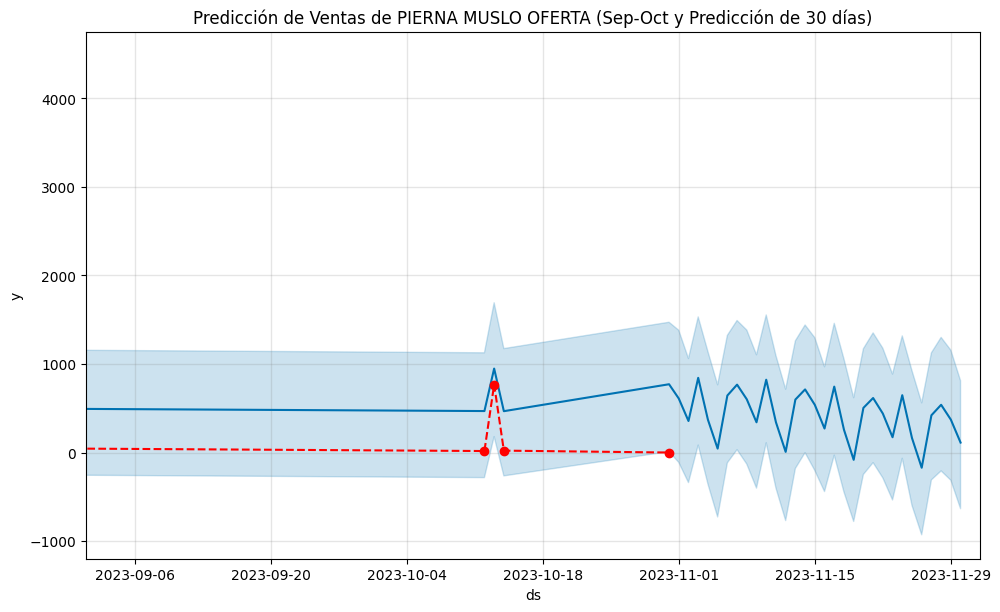

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/dse7v8su.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80i8su6s/ypmutbbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80427', 'data', 'file=/tmp/tmp80i8su6s/dse7v8su.json', 'init=/tmp/tmp80i8su6s/ypmutbbn.json', 'output', 'file=/tmp/tmp80i8su6s/prophet_modelztlpc3jp/prophet_model-20240222201300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Predicción con todos los valores para PIERNA MUSLO OFERTA:
            ds      yhat
442 2023-11-01  609.8340
443 2023-11-02  355.9598
444 2023-11-03  843.2263
445 2023-11-04  370.6718
446 2023-11-05   44.2347
447 2023-11-06  643.3974
448 2023-11-07  766.4471
449 2023-11-08  600.9263
450 2023-11-09  341.4148
451 2023-11-10  822.0115
452 2023-11-11  341.9514
453 2023-11-12    7.3962
454 2023-11-13  598.0712
455 2023-11-14  712.5187
456 2023-11-15  538.5404
457 2023-11-16  270.9712
458 2023-11-17  744.1534
459 2023-11-18  257.5465
460 2023-11-19  -82.4892
461 2023-11-20  503.9389
462 2023-11-21  615.5041
463 2023-11-22  440.0996
464 2023-11-23  172.6093
465 2023-11-24  647.3820
466 2023-11-25  163.8407
467 2023-11-26 -171.7318
468 2023-11-27  420.4419
469 2023-11-28  538.8858
470 2023-11-29  371.3146
471 2023-11-30  112.4115
              ds NombreProducto        y
0     2018-11-01    ALA PRIMERA 200.5600
1     2018-11-02    ALA PRIMERA 393.5760
2     2018-11-03    ALA PRIMERA 195.9600
3 

20:13:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


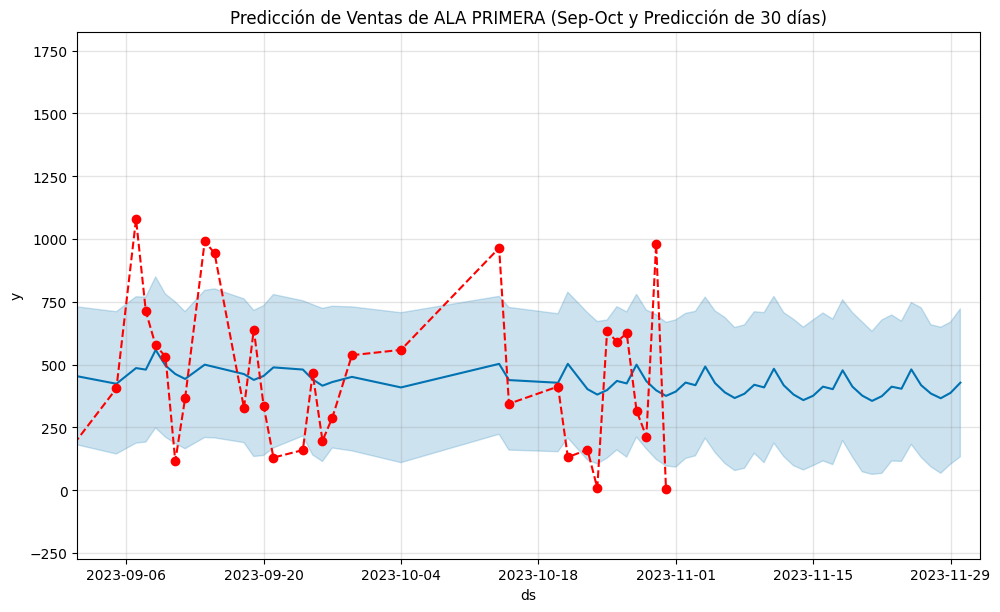

Predicción con todos los valores para ALA PRIMERA:
             ds     yhat
1294 2023-11-01 392.9908
1295 2023-11-02 428.8043
1296 2023-11-03 418.3142
1297 2023-11-04 492.5596
1298 2023-11-05 426.6593
1299 2023-11-06 389.7510
1300 2023-11-07 367.2800
1301 2023-11-08 384.3756
1302 2023-11-09 420.0594
1303 2023-11-10 409.5057
1304 2023-11-11 483.7567
1305 2023-11-12 417.9358
1306 2023-11-13 381.1870
1307 2023-11-14 358.9637
1308 2023-11-15 376.4055
1309 2023-11-16 412.5455
1310 2023-11-17 402.5711
1311 2023-11-18 477.5380
1312 2023-11-19 412.5837
1313 2023-11-20 376.8656
1314 2023-11-21 355.8491
1315 2023-11-22 374.6834
1316 2023-11-23 412.4084
1317 2023-11-24 404.2144
1318 2023-11-25 481.1549
1319 2023-11-26 418.3601
1320 2023-11-27 384.9736
1321 2023-11-28 366.4408
1322 2023-11-29 387.8839
1323 2023-11-30 428.3092


In [ ]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [ ]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Crear un nombre único para la columna de predicciones de Prophet
#     col_name = f'P-V_PROPHET_{product}'

#     # Convertir la columna de fecha a tipo datetime
#     product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

#     # Fusionar el DataFrame de ventas con el DataFrame de predicciones
#     product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

#     # Renombrar la columna yhat a Ventas_PROPHET
#     product_df.rename(columns={'yhat': col_name}, inplace=True)

#     # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
#     product_df.drop(columns=['ds'], inplace=True)

#     # Actualizar el DataFrame en el diccionario
#     dfs_noviembre_sumados[product] = product_df

In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                 NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL
FechaMovimiento                                                       
2023-11-01       POLLO ESPECIAL  1999.7321                   1918.6519
2023-11-02       POLLO ESPECIAL  1011.2892                   1794.0805
2023-11-03       POLLO ESPECIAL  2343.7883                   2008.2326
2023-11-04       POLLO ESPECIAL  1673.2089                   2429.0343
2023-11-05       POLLO ESPECIAL  1181.9289                   1684.4395
2023-11-06       POLLO ESPECIAL   863.7984                   1865.7316
2023-11-07       POLLO ESPECIAL  1648.4580                   1838.9538
2023-11-08       POLLO ESPECIAL  1434.6711                   1871.8651
2023-11-09       POLLO ESPECIAL  1680.6493                   1740.4964
2023-11-10       POLLO ESPECIAL  1767.7892                   1948.9530
2023-11-11       POLLO ESPECIAL  1634.3693                   2365.2701
2023-11-12       POLLO ESPECIAL   773.2943                   1617.4811
2023-1

In [ ]:
dfs_noviembre_sumados

{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL
 FechaMovimiento                                                       
 2023-11-01       POLLO ESPECIAL  1999.7321                   1918.6519
 2023-11-02       POLLO ESPECIAL  1011.2892                   1794.0805
 2023-11-03       POLLO ESPECIAL  2343.7883                   2008.2326
 2023-11-04       POLLO ESPECIAL  1673.2089                   2429.0343
 2023-11-05       POLLO ESPECIAL  1181.9289                   1684.4395
 2023-11-06       POLLO ESPECIAL   863.7984                   1865.7316
 2023-11-07       POLLO ESPECIAL  1648.4580                   1838.9538
 2023-11-08       POLLO ESPECIAL  1434.6711                   1871.8651
 2023-11-09       POLLO ESPECIAL  1680.6493                   1740.4964
 2023-11-10       POLLO ESPECIAL  1767.7892                   1948.9530
 2023-11-11       POLLO ESPECIAL  1634.3693                   2365.2701
 2023-11-12       POLLO ESPECIAL   773.2943   

# LSTM


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_lstm)

NombreProducto     object
MontoBase         float64
DayOW               int64
Month               int64
Year                int64
dtype: object
{'POLLO ESPECIAL':                  NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                               
2018-11-01       POLLO ESPECIAL  1140.6240      3     11  2018
2018-11-02       POLLO ESPECIAL  1645.2540      4     11  2018
2018-11-03       POLLO ESPECIAL   712.9790      5     11  2018
2018-11-04       POLLO ESPECIAL  1343.6330      6     11  2018
2018-11-05       POLLO ESPECIAL  1755.2580      0     11  2018
...                         ...        ...    ...    ...   ...
2023-10-27       POLLO ESPECIAL  2152.1624      4     10  2023
2023-10-28       POLLO ESPECIAL  2499.2891      5     10  2023
2023-10-29       POLLO ESPECIAL  1611.2471      6     10  2023
2023-10-30       POLLO ESPECIAL  3372.2990      0     10  2023
2023-10-31       POLLO ESPECIAL  2112.0323      1     10  2023

[1698 rows x 5 co

In [ ]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


In [ ]:
# #Otro enfoque creando anteriormente las fechas de noviembre para las predicciones
# def create_sequences(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         seq = data[i : i + seq_length]
#         label = data[i + seq_length]
#         X.append(seq)
#         y.append(label)
#     return np.array(X), np.array(y)

## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Epoch 1/50
42/42 - 4s - loss: 0.0179 - 4s/epoch - 84ms/step
Epoch 2/50
42/42 - 1s - loss: 0.0105 - 724ms/epoch - 17ms/step
Epoch 3/50
42/42 - 1s - loss: 0.0102 - 762ms/epoch - 18ms/step
Epoch 4/50
42/42 - 1s - loss: 0.0100 - 538ms/epoch - 13ms/step
Epoch 5/50
42/42 - 0s - loss: 0.0102 - 469ms/epoch - 11ms/step
Epoch 6/50
42/42 - 0s - loss: 0.0098 - 476ms/epoch - 11ms/step
Epoch 7/50
42/42 - 0s - loss: 0.0097 - 466ms/epoch - 11ms/step
Epoch 8/50
42/42 - 0s - loss: 0.0097 - 470ms/epoch - 11ms/step
Epoch 9/50
42/42 - 0s - loss: 0.0097 - 452ms/epoch - 11ms/step
Epoch 10/50
42/42 - 0s - loss: 0.0097 - 462ms/epoch - 11ms/step
Epoch 11/50
42/42 - 0s - loss: 0.0098 - 480ms/epoch - 11ms/step
Epoch 12/50
42/42 - 0s - loss: 0.0098 - 454ms/epoch - 11ms/step
Epoch 13/50
42/42 - 0s - loss: 0.0097 - 466ms/epoch - 11ms/step
Epoch 14/50
42/42 - 0s - loss: 0.0096 - 460ms/epoch - 11ms/step
Epoch 15/50
42/42 - 0s - loss: 0.0097 - 464ms/epoch - 11ms/step
Epoch 16/50
42/42 - 0s - loss: 0.0096 - 463ms/epoch 

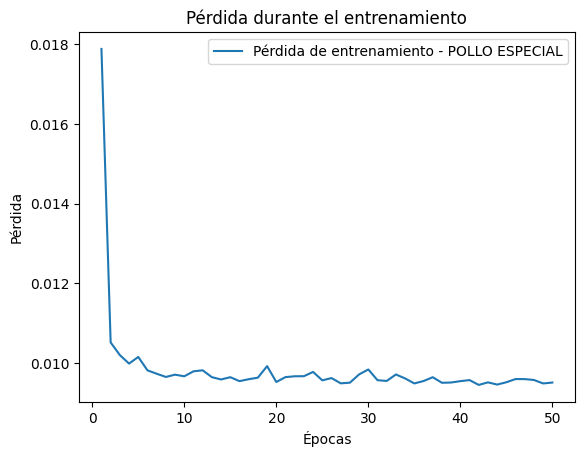

11/11 [==============================] - 1s 7ms/step


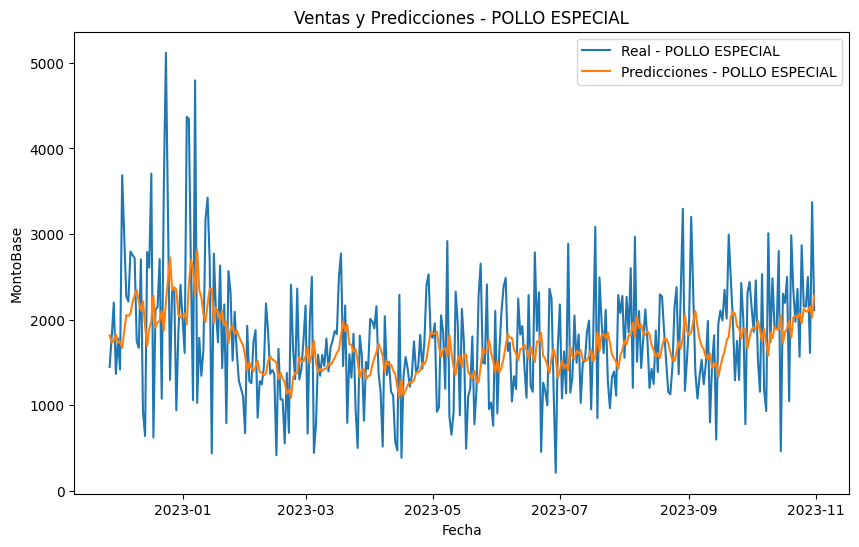

Dimensiones de fechas: (335,)
Dimensiones de predicciones: (334, 1)
La longitud de X_test es: 334 y la longitud de y_test es: 334
Forma de input_data: (30, 30, 1)
Forma de input_data después del reshape: (30, 30, 1)
1/1 [==============================] - 0s 34ms/step
                 P-V_LSTM_POLLO ESPECIAL
FechaMovimiento                         
2023-11-01                             0
2023-11-02                             0
2023-11-03                             0
2023-11-04                             0
2023-11-05                             0
2023-11-06                             0
2023-11-07                             0
2023-11-08                             0
2023-11-09                             0
2023-11-10                             0
2023-11-11                             0
2023-11-12                             0
2023-11-13                             0
2023-11-14                             0
2023-11-15                             0
2023-11-16                         

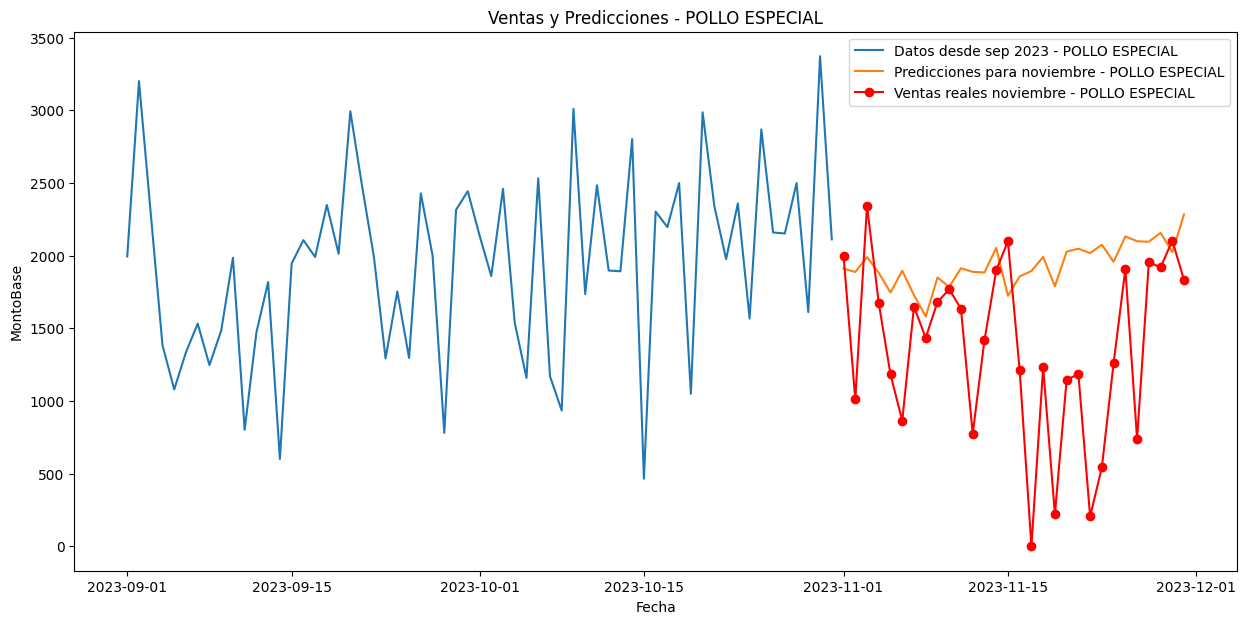

Epoch 1/50
40/40 - 3s - loss: 0.0109 - 3s/epoch - 69ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0091 - 431ms/epoch - 11ms/step
Epoch 3/50
40/40 - 0s - loss: 0.0091 - 436ms/epoch - 11ms/step
Epoch 4/50
40/40 - 0s - loss: 0.0089 - 445ms/epoch - 11ms/step
Epoch 5/50
40/40 - 0s - loss: 0.0090 - 450ms/epoch - 11ms/step
Epoch 6/50
40/40 - 0s - loss: 0.0089 - 443ms/epoch - 11ms/step
Epoch 7/50
40/40 - 0s - loss: 0.0089 - 463ms/epoch - 12ms/step
Epoch 8/50
40/40 - 0s - loss: 0.0090 - 440ms/epoch - 11ms/step
Epoch 9/50
40/40 - 0s - loss: 0.0089 - 455ms/epoch - 11ms/step
Epoch 10/50
40/40 - 0s - loss: 0.0090 - 451ms/epoch - 11ms/step
Epoch 11/50
40/40 - 0s - loss: 0.0089 - 440ms/epoch - 11ms/step
Epoch 12/50
40/40 - 0s - loss: 0.0091 - 439ms/epoch - 11ms/step
Epoch 13/50
40/40 - 0s - loss: 0.0089 - 438ms/epoch - 11ms/step
Epoch 14/50
40/40 - 0s - loss: 0.0090 - 443ms/epoch - 11ms/step
Epoch 15/50
40/40 - 0s - loss: 0.0089 - 433ms/epoch - 11ms/step
Epoch 16/50
40/40 - 0s - loss: 0.0089 - 432ms/epoch 

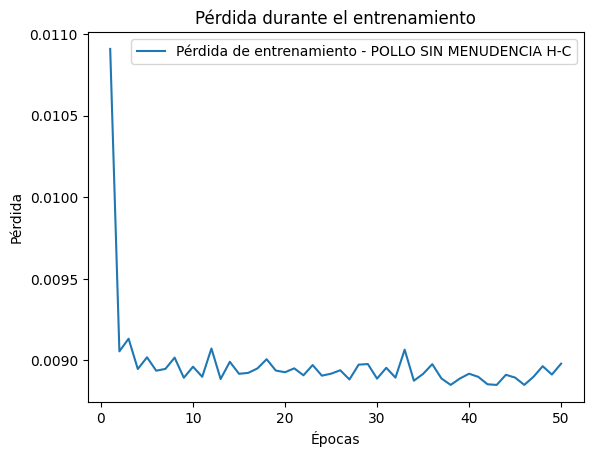

10/10 [==============================] - 1s 8ms/step


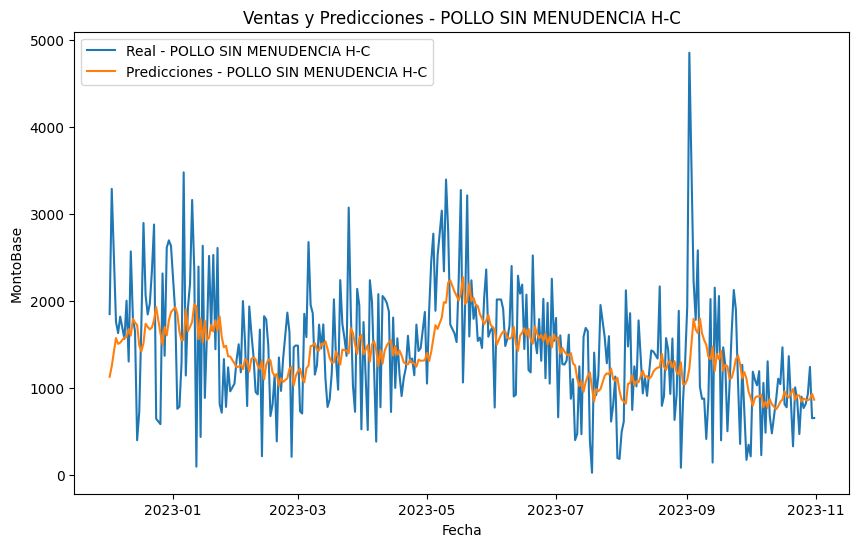

Dimensiones de fechas: (319,)
Dimensiones de predicciones: (318, 1)
La longitud de X_test es: 318 y la longitud de y_test es: 318
Forma de input_data: (28, 30, 1)
Forma de input_data después del reshape: (28, 30, 1)
1/1 [==============================] - 0s 26ms/step
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                                       0
2023-11-02                                       0
2023-11-03                                       0
2023-11-04                                       0
2023-11-05                                       0
2023-11-06                                       0
2023-11-07                                       0
2023-11-08                                       0
2023-11-09                                       0
2023-11-10                                       0
2023-11-11                                       0
2023-11-12                                       0
2023-11-13        

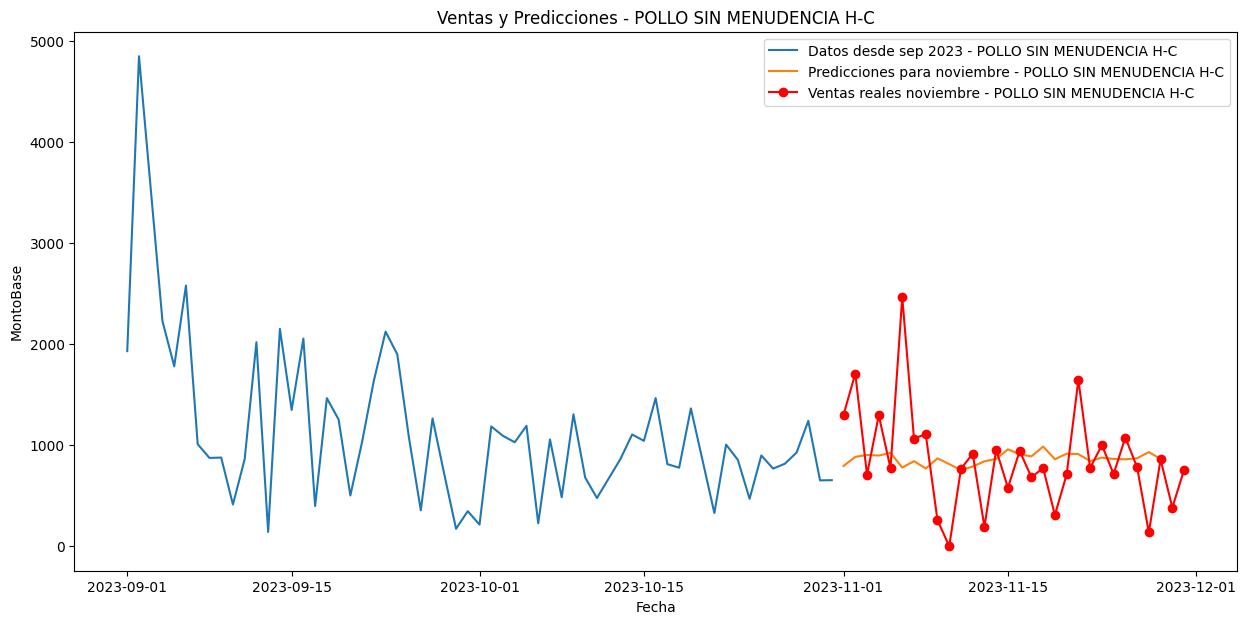

Epoch 1/50
34/34 - 2s - loss: 0.0317 - 2s/epoch - 68ms/step
Epoch 2/50
34/34 - 0s - loss: 0.0232 - 387ms/epoch - 11ms/step
Epoch 3/50
34/34 - 0s - loss: 0.0229 - 385ms/epoch - 11ms/step
Epoch 4/50
34/34 - 0s - loss: 0.0227 - 384ms/epoch - 11ms/step
Epoch 5/50
34/34 - 0s - loss: 0.0227 - 375ms/epoch - 11ms/step
Epoch 6/50
34/34 - 0s - loss: 0.0228 - 399ms/epoch - 12ms/step
Epoch 7/50
34/34 - 0s - loss: 0.0227 - 377ms/epoch - 11ms/step
Epoch 8/50
34/34 - 0s - loss: 0.0226 - 377ms/epoch - 11ms/step
Epoch 9/50
34/34 - 0s - loss: 0.0226 - 390ms/epoch - 11ms/step
Epoch 10/50
34/34 - 0s - loss: 0.0226 - 373ms/epoch - 11ms/step
Epoch 11/50
34/34 - 0s - loss: 0.0226 - 391ms/epoch - 11ms/step
Epoch 12/50
34/34 - 0s - loss: 0.0227 - 394ms/epoch - 12ms/step
Epoch 13/50
34/34 - 0s - loss: 0.0228 - 400ms/epoch - 12ms/step
Epoch 14/50
34/34 - 0s - loss: 0.0225 - 408ms/epoch - 12ms/step
Epoch 15/50
34/34 - 0s - loss: 0.0228 - 384ms/epoch - 11ms/step
Epoch 16/50
34/34 - 0s - loss: 0.0225 - 381ms/epoch 

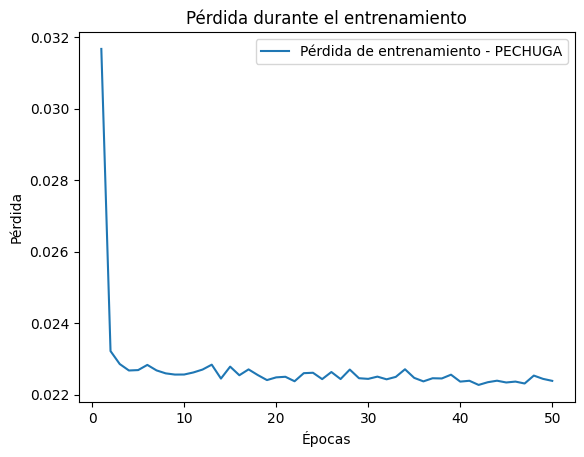

9/9 [==============================] - 0s 5ms/step


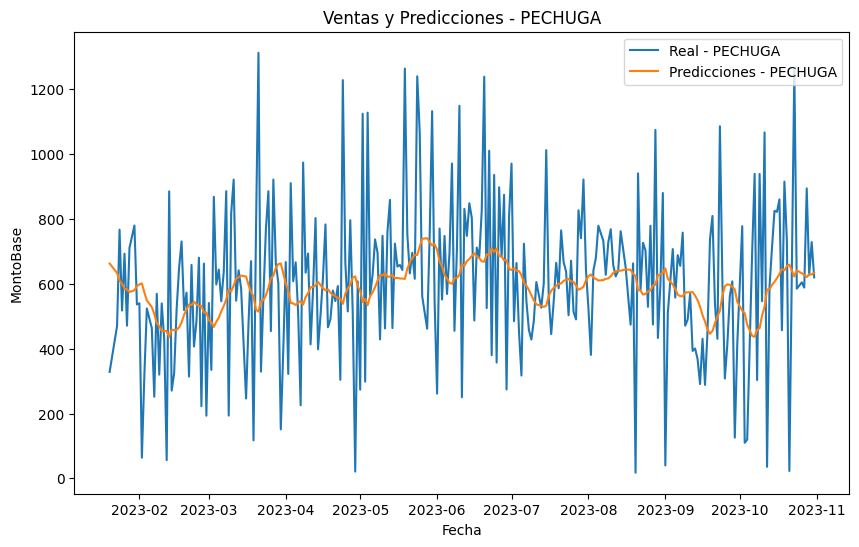

Dimensiones de fechas: (271,)
Dimensiones de predicciones: (270, 1)
La longitud de X_test es: 270 y la longitud de y_test es: 270
Forma de input_data: (26, 30, 1)
Forma de input_data después del reshape: (26, 30, 1)
1/1 [==============================] - 0s 23ms/step
                 P-V_LSTM_PECHUGA
FechaMovimiento                  
2023-11-01                      0
2023-11-02                      0
2023-11-03                      0
2023-11-04                      0
2023-11-05                      0
2023-11-06                      0
2023-11-07                      0
2023-11-08                      0
2023-11-09                      0
2023-11-10                      0
2023-11-11                      0
2023-11-12                      0
2023-11-13                      0
2023-11-14                      0
2023-11-15                      0
2023-11-16                      0
2023-11-17                      0
2023-11-18                      0
2023-11-19                      0
2023-11-20        

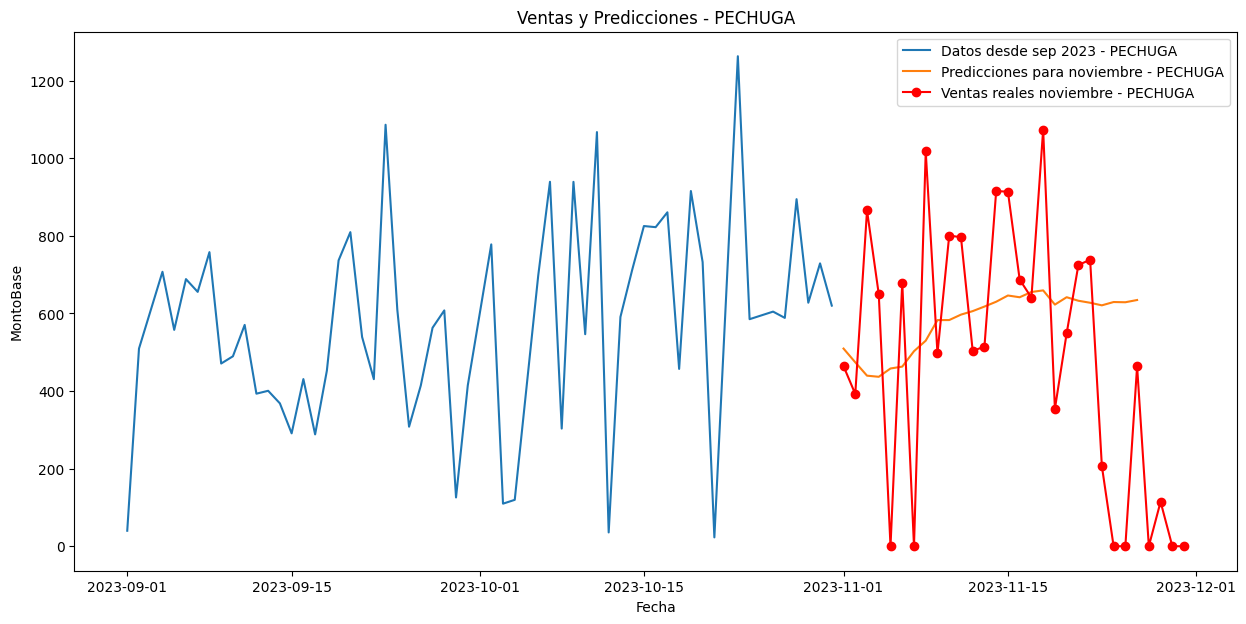

Epoch 1/50
34/34 - 2s - loss: 0.0056 - 2s/epoch - 69ms/step
Epoch 2/50
34/34 - 1s - loss: 0.0038 - 619ms/epoch - 18ms/step
Epoch 3/50
34/34 - 1s - loss: 0.0038 - 614ms/epoch - 18ms/step
Epoch 4/50
34/34 - 1s - loss: 0.0038 - 596ms/epoch - 18ms/step
Epoch 5/50
34/34 - 1s - loss: 0.0038 - 619ms/epoch - 18ms/step
Epoch 6/50
34/34 - 1s - loss: 0.0038 - 591ms/epoch - 17ms/step
Epoch 7/50
34/34 - 1s - loss: 0.0039 - 609ms/epoch - 18ms/step
Epoch 8/50
34/34 - 0s - loss: 0.0038 - 385ms/epoch - 11ms/step
Epoch 9/50
34/34 - 0s - loss: 0.0038 - 389ms/epoch - 11ms/step
Epoch 10/50
34/34 - 0s - loss: 0.0038 - 394ms/epoch - 12ms/step
Epoch 11/50
34/34 - 0s - loss: 0.0038 - 377ms/epoch - 11ms/step
Epoch 12/50
34/34 - 0s - loss: 0.0038 - 404ms/epoch - 12ms/step
Epoch 13/50
34/34 - 0s - loss: 0.0038 - 380ms/epoch - 11ms/step
Epoch 14/50
34/34 - 0s - loss: 0.0038 - 380ms/epoch - 11ms/step
Epoch 15/50
34/34 - 0s - loss: 0.0038 - 400ms/epoch - 12ms/step
Epoch 16/50
34/34 - 0s - loss: 0.0038 - 374ms/epoch 

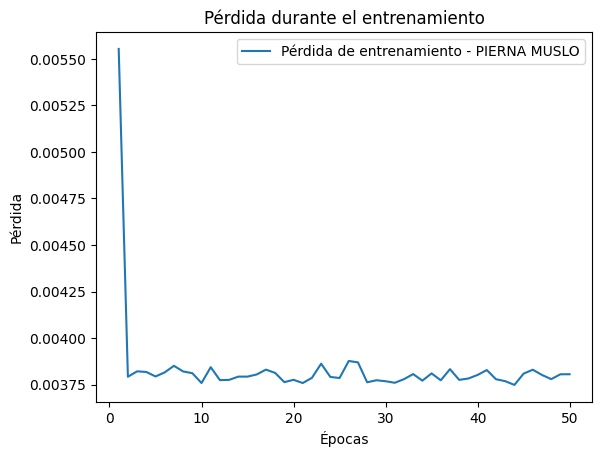

9/9 [==============================] - 0s 5ms/step


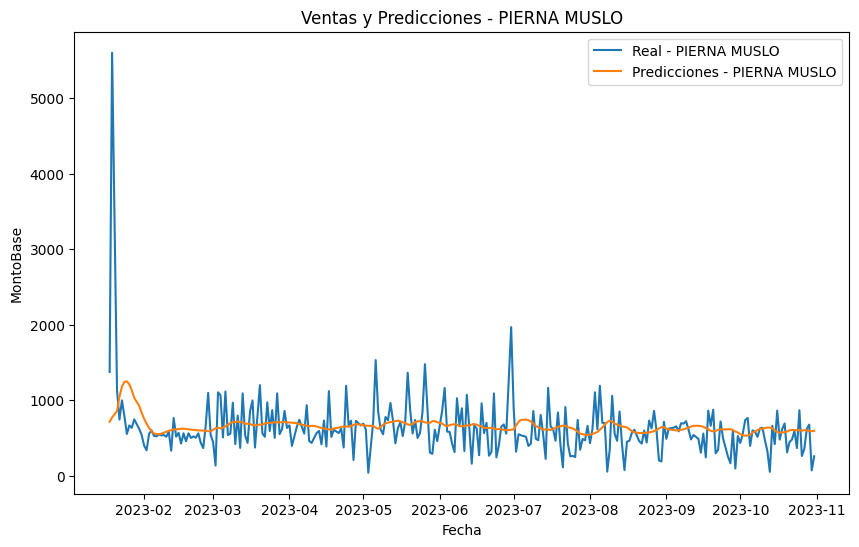

Dimensiones de fechas: (272,)
Dimensiones de predicciones: (271, 1)
La longitud de X_test es: 271 y la longitud de y_test es: 271
Forma de input_data: (28, 30, 1)
Forma de input_data después del reshape: (28, 30, 1)
1/1 [==============================] - 0s 25ms/step
                 P-V_LSTM_PIERNA MUSLO
FechaMovimiento                       
2023-11-01                           0
2023-11-02                           0
2023-11-03                           0
2023-11-04                           0
2023-11-05                           0
2023-11-06                           0
2023-11-07                           0
2023-11-08                           0
2023-11-09                           0
2023-11-10                           0
2023-11-11                           0
2023-11-12                           0
2023-11-13                           0
2023-11-14                           0
2023-11-15                           0
2023-11-16                           0
2023-11-17                    

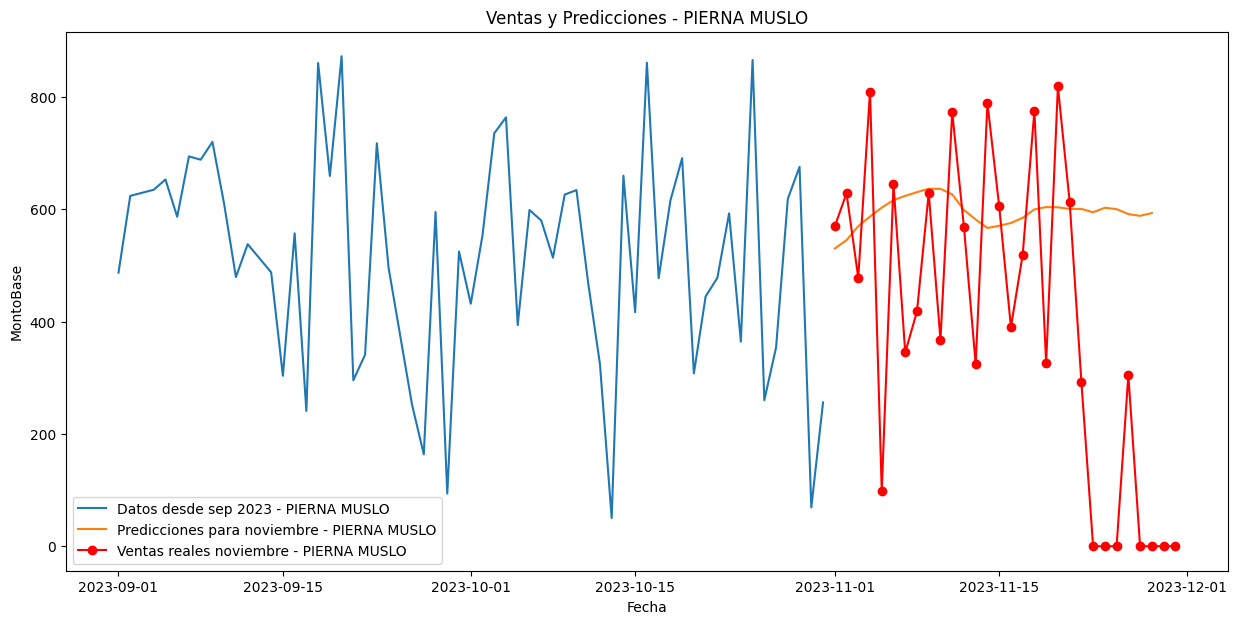

Epoch 1/50
39/39 - 3s - loss: 0.0233 - 3s/epoch - 72ms/step
Epoch 2/50
39/39 - 0s - loss: 0.0132 - 441ms/epoch - 11ms/step
Epoch 3/50
39/39 - 1s - loss: 0.0130 - 609ms/epoch - 16ms/step
Epoch 4/50
39/39 - 1s - loss: 0.0130 - 677ms/epoch - 17ms/step
Epoch 5/50
39/39 - 1s - loss: 0.0129 - 694ms/epoch - 18ms/step
Epoch 6/50
39/39 - 1s - loss: 0.0131 - 686ms/epoch - 18ms/step
Epoch 7/50
39/39 - 1s - loss: 0.0129 - 732ms/epoch - 19ms/step
Epoch 8/50
39/39 - 1s - loss: 0.0130 - 677ms/epoch - 17ms/step
Epoch 9/50
39/39 - 1s - loss: 0.0131 - 641ms/epoch - 16ms/step
Epoch 10/50
39/39 - 0s - loss: 0.0129 - 439ms/epoch - 11ms/step
Epoch 11/50
39/39 - 0s - loss: 0.0128 - 465ms/epoch - 12ms/step
Epoch 12/50
39/39 - 0s - loss: 0.0129 - 444ms/epoch - 11ms/step
Epoch 13/50
39/39 - 0s - loss: 0.0129 - 475ms/epoch - 12ms/step
Epoch 14/50
39/39 - 0s - loss: 0.0130 - 438ms/epoch - 11ms/step
Epoch 15/50
39/39 - 0s - loss: 0.0129 - 437ms/epoch - 11ms/step
Epoch 16/50
39/39 - 0s - loss: 0.0129 - 463ms/epoch 

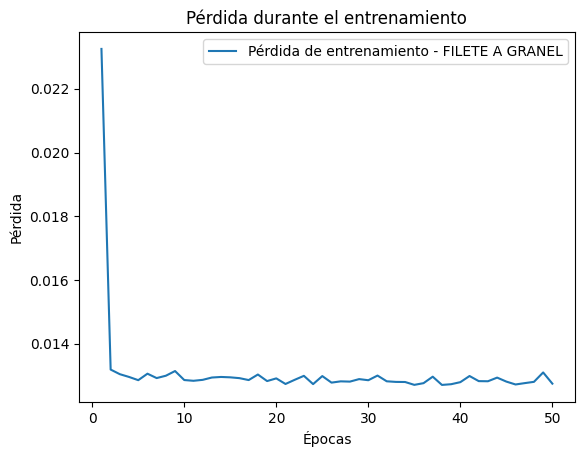

10/10 [==============================] - 1s 8ms/step


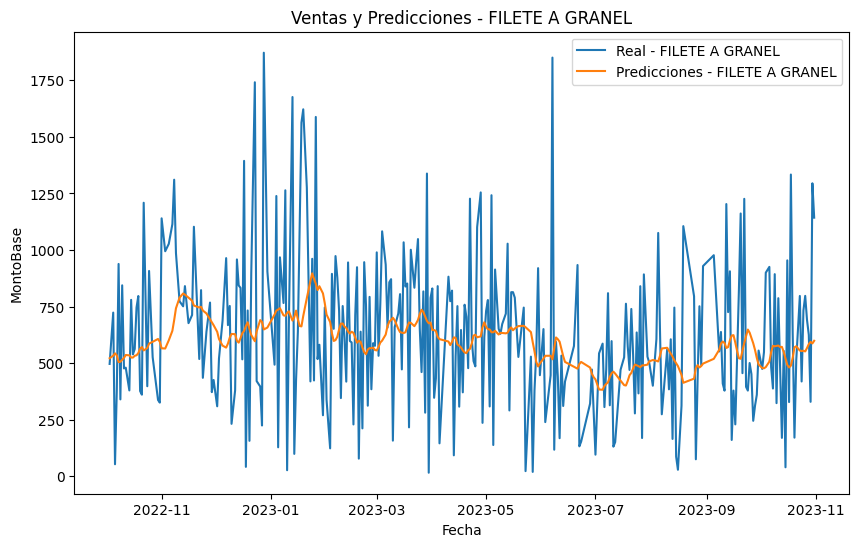

Dimensiones de fechas: (310,)
Dimensiones de predicciones: (309, 1)
La longitud de X_test es: 309 y la longitud de y_test es: 309
Forma de input_data: (22, 30, 1)
Forma de input_data después del reshape: (22, 30, 1)
1/1 [==============================] - 0s 41ms/step
                 P-V_LSTM_FILETE A GRANEL
FechaMovimiento                          
2023-11-01                              0
2023-11-02                              0
2023-11-03                              0
2023-11-04                              0
2023-11-05                              0
2023-11-06                              0
2023-11-07                              0
2023-11-08                              0
2023-11-09                              0
2023-11-10                              0
2023-11-11                              0
2023-11-12                              0
2023-11-13                              0
2023-11-14                              0
2023-11-15                              0
2023-11-16        

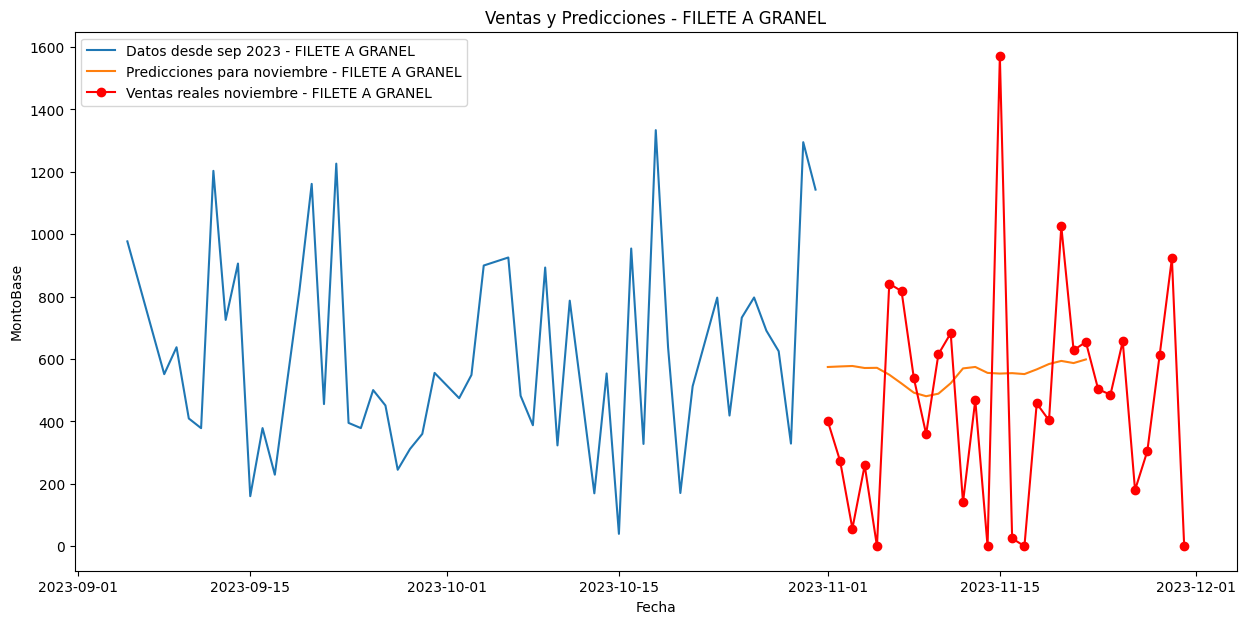

Epoch 1/50
41/41 - 2s - loss: 0.0070 - 2s/epoch - 58ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0043 - 482ms/epoch - 12ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0041 - 468ms/epoch - 11ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0041 - 473ms/epoch - 12ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0040 - 460ms/epoch - 11ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0041 - 485ms/epoch - 12ms/step
Epoch 7/50
41/41 - 1s - loss: 0.0041 - 620ms/epoch - 15ms/step
Epoch 8/50
41/41 - 1s - loss: 0.0041 - 1s/epoch - 25ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0041 - 475ms/epoch - 12ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0040 - 469ms/epoch - 11ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0041 - 480ms/epoch - 12ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0041 - 469ms/epoch - 11ms/step
Epoch 13/50
41/41 - 0s - loss: 0.0040 - 461ms/epoch - 11ms/step
Epoch 14/50
41/41 - 0s - loss: 0.0041 - 488ms/epoch - 12ms/step
Epoch 15/50
41/41 - 0s - loss: 0.0040 - 499ms/epoch - 12ms/step
Epoch 16/50
41/41 - 1s - loss: 0.0041 - 745ms/epoch - 1

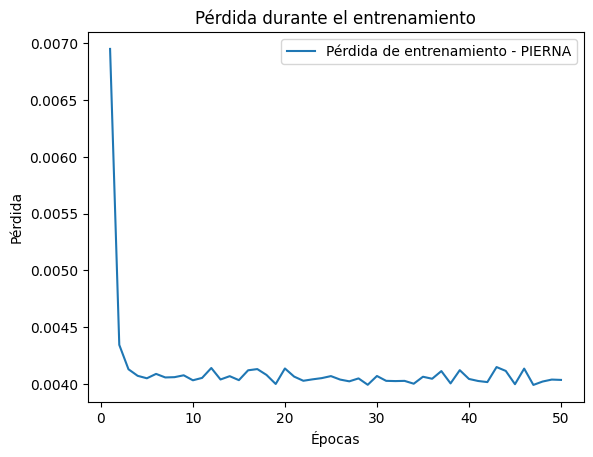

11/11 [==============================] - 0s 5ms/step


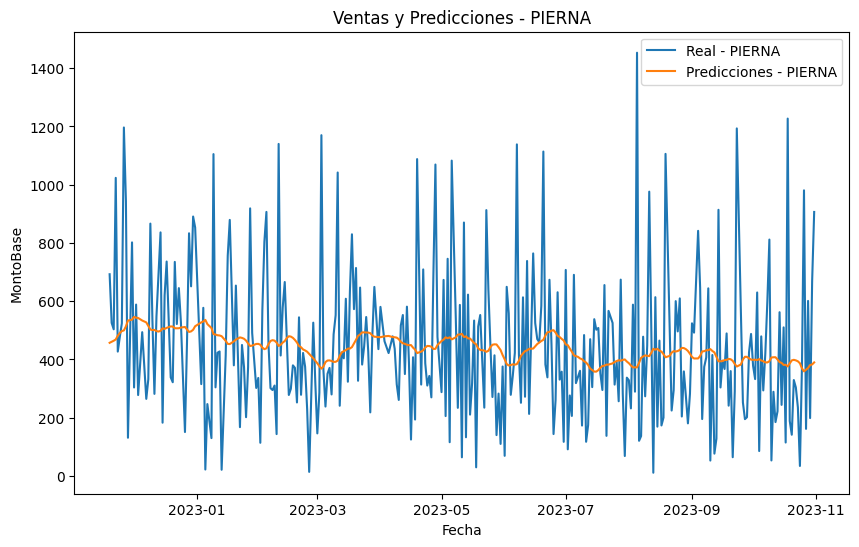

Dimensiones de fechas: (323,)
Dimensiones de predicciones: (322, 1)
La longitud de X_test es: 322 y la longitud de y_test es: 322
Forma de input_data: (29, 30, 1)
Forma de input_data después del reshape: (29, 30, 1)
1/1 [==============================] - 0s 23ms/step
                 P-V_LSTM_PIERNA
FechaMovimiento                 
2023-11-01                     0
2023-11-02                     0
2023-11-03                     0
2023-11-04                     0
2023-11-05                     0
2023-11-06                     0
2023-11-07                     0
2023-11-08                     0
2023-11-09                     0
2023-11-10                     0
2023-11-11                     0
2023-11-12                     0
2023-11-13                     0
2023-11-14                     0
2023-11-15                     0
2023-11-16                     0
2023-11-17                     0
2023-11-18                     0
2023-11-19                     0
2023-11-20                     0
2023-1

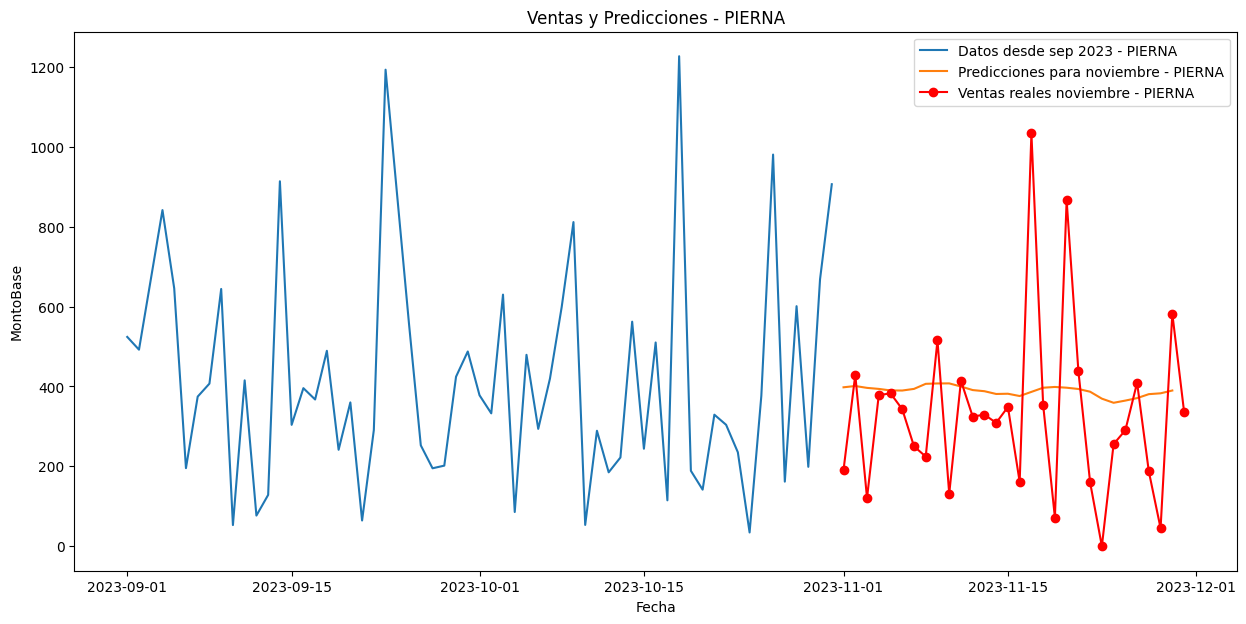

Epoch 1/50
39/39 - 2s - loss: 0.0176 - 2s/epoch - 61ms/step
Epoch 2/50
39/39 - 0s - loss: 0.0134 - 472ms/epoch - 12ms/step
Epoch 3/50
39/39 - 0s - loss: 0.0136 - 446ms/epoch - 11ms/step
Epoch 4/50
39/39 - 0s - loss: 0.0133 - 445ms/epoch - 11ms/step
Epoch 5/50
39/39 - 0s - loss: 0.0132 - 468ms/epoch - 12ms/step
Epoch 6/50
39/39 - 0s - loss: 0.0133 - 445ms/epoch - 11ms/step
Epoch 7/50
39/39 - 1s - loss: 0.0138 - 517ms/epoch - 13ms/step
Epoch 8/50
39/39 - 1s - loss: 0.0135 - 702ms/epoch - 18ms/step
Epoch 9/50
39/39 - 1s - loss: 0.0135 - 700ms/epoch - 18ms/step
Epoch 10/50
39/39 - 1s - loss: 0.0133 - 707ms/epoch - 18ms/step
Epoch 11/50
39/39 - 1s - loss: 0.0133 - 660ms/epoch - 17ms/step
Epoch 12/50
39/39 - 1s - loss: 0.0134 - 724ms/epoch - 19ms/step
Epoch 13/50
39/39 - 0s - loss: 0.0132 - 492ms/epoch - 13ms/step
Epoch 14/50
39/39 - 0s - loss: 0.0132 - 464ms/epoch - 12ms/step
Epoch 15/50
39/39 - 0s - loss: 0.0133 - 460ms/epoch - 12ms/step
Epoch 16/50
39/39 - 0s - loss: 0.0133 - 459ms/epoch 

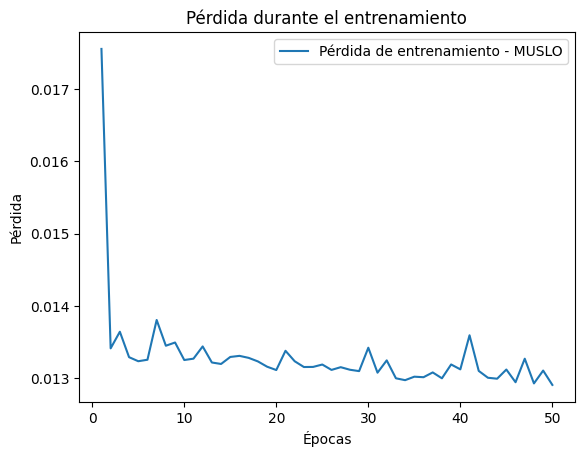

10/10 [==============================] - 0s 7ms/step


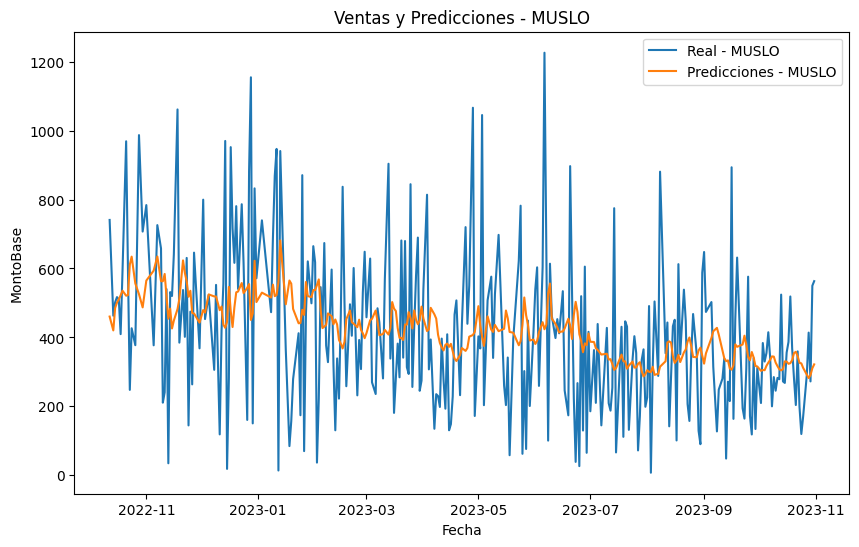

Dimensiones de fechas: (307,)
Dimensiones de predicciones: (306, 1)
La longitud de X_test es: 306 y la longitud de y_test es: 306
Forma de input_data: (23, 30, 1)
Forma de input_data después del reshape: (23, 30, 1)
1/1 [==============================] - 0s 24ms/step
                 P-V_LSTM_MUSLO
FechaMovimiento                
2023-11-01                    0
2023-11-02                    0
2023-11-03                    0
2023-11-04                    0
2023-11-05                    0
2023-11-06                    0
2023-11-07                    0
2023-11-08                    0
2023-11-09                    0
2023-11-10                    0
2023-11-11                    0
2023-11-12                    0
2023-11-13                    0
2023-11-14                    0
2023-11-15                    0
2023-11-16                    0
2023-11-17                    0
2023-11-18                    0
2023-11-19                    0
2023-11-20                    0
2023-11-21                  

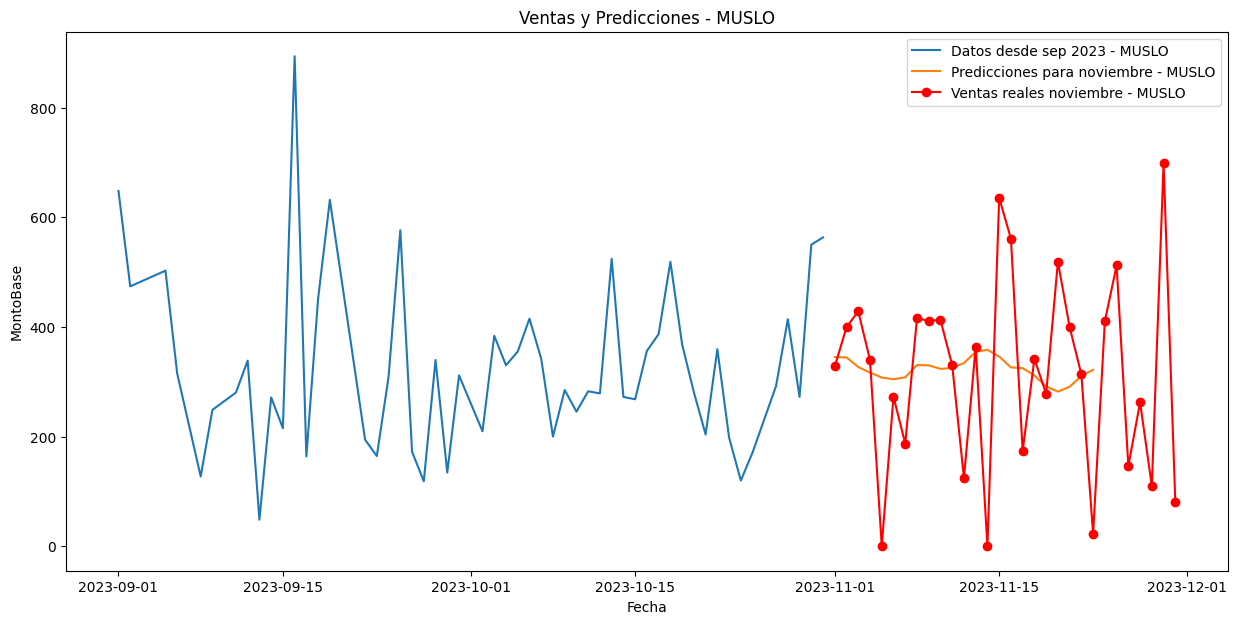

Epoch 1/50
25/25 - 2s - loss: 0.0131 - 2s/epoch - 93ms/step
Epoch 2/50
25/25 - 0s - loss: 0.0106 - 324ms/epoch - 13ms/step
Epoch 3/50
25/25 - 0s - loss: 0.0102 - 440ms/epoch - 18ms/step
Epoch 4/50
25/25 - 0s - loss: 0.0102 - 468ms/epoch - 19ms/step
Epoch 5/50
25/25 - 0s - loss: 0.0103 - 442ms/epoch - 18ms/step
Epoch 6/50
25/25 - 0s - loss: 0.0102 - 476ms/epoch - 19ms/step
Epoch 7/50
25/25 - 0s - loss: 0.0102 - 443ms/epoch - 18ms/step
Epoch 8/50
25/25 - 0s - loss: 0.0105 - 498ms/epoch - 20ms/step
Epoch 9/50
25/25 - 0s - loss: 0.0101 - 480ms/epoch - 19ms/step
Epoch 10/50
25/25 - 0s - loss: 0.0102 - 474ms/epoch - 19ms/step
Epoch 11/50
25/25 - 0s - loss: 0.0103 - 346ms/epoch - 14ms/step
Epoch 12/50
25/25 - 0s - loss: 0.0101 - 303ms/epoch - 12ms/step
Epoch 13/50
25/25 - 0s - loss: 0.0101 - 320ms/epoch - 13ms/step
Epoch 14/50
25/25 - 0s - loss: 0.0102 - 341ms/epoch - 14ms/step
Epoch 15/50
25/25 - 0s - loss: 0.0101 - 294ms/epoch - 12ms/step
Epoch 16/50
25/25 - 0s - loss: 0.0101 - 318ms/epoch 

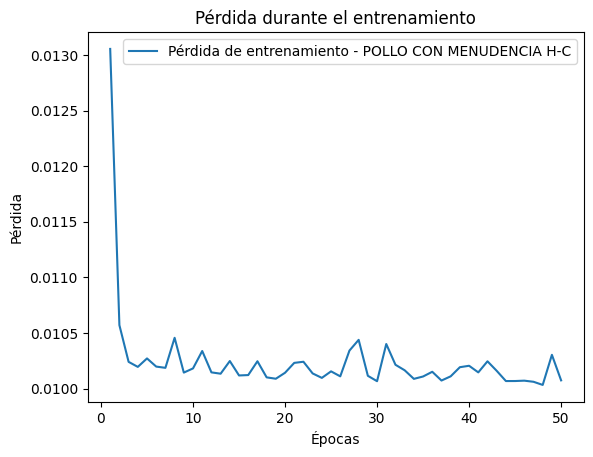

7/7 [==============================] - 0s 6ms/step


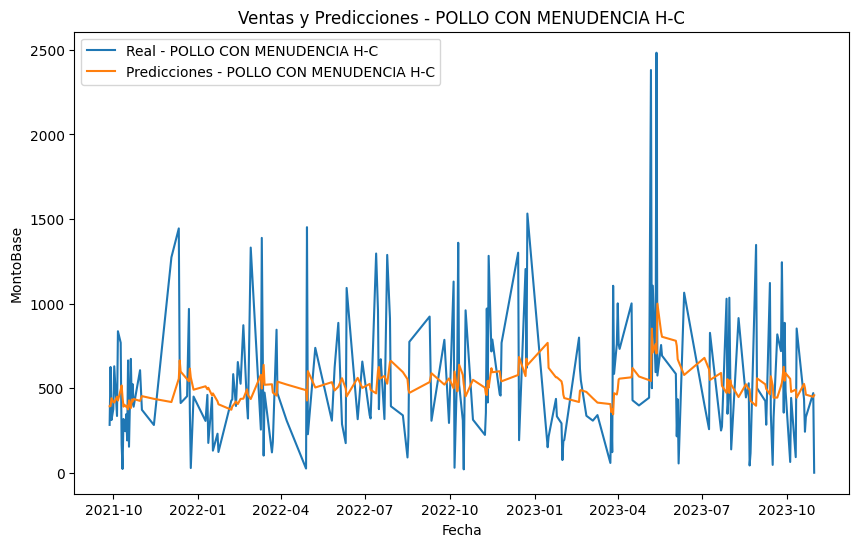

Dimensiones de fechas: (194,)
Dimensiones de predicciones: (193, 1)
La longitud de X_test es: 193 y la longitud de y_test es: 193
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
11/11 - 2s - loss: 0.0361 - 2s/epoch - 192ms/step
Epoch 2/50
11/11 - 0s - loss: 0.0217 - 163ms/epoch - 15ms/step
Epoch 3/50
11/11 - 0s - loss: 0.0206 - 153ms/epoch - 14ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0193 - 156ms/epoch - 14ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0191 - 151ms/epoch - 14ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0192 - 154ms/epoch - 14ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0196 - 148ms/epoch - 13ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0193 - 149ms/epoch - 14ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0197 - 164ms/epoch - 15ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0193 - 151ms/epoch - 14ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0192 - 160ms/epoch - 15ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0191 - 146ms/epoch - 13ms/step
Epoch 13/50
11/11 - 0s - loss: 

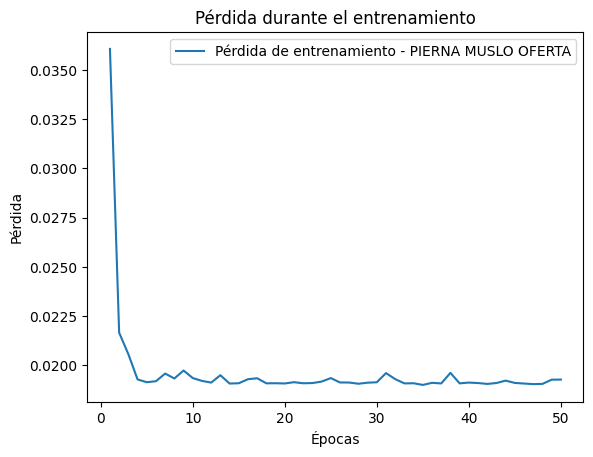

3/3 [==============================] - 1s 12ms/step


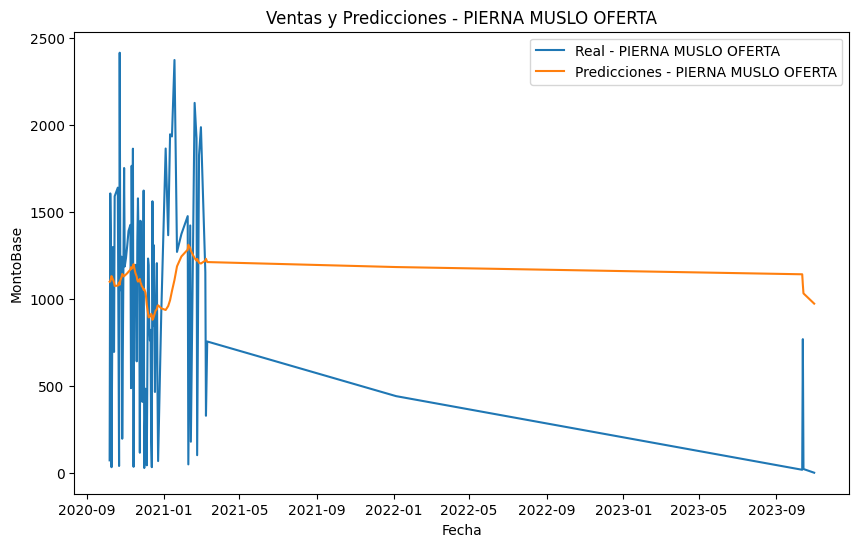

Dimensiones de fechas: (84,)
Dimensiones de predicciones: (83, 1)
La longitud de X_test es: 83 y la longitud de y_test es: 83
No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.
Epoch 1/50
32/32 - 2s - loss: 0.0181 - 2s/epoch - 74ms/step
Epoch 2/50
32/32 - 0s - loss: 0.0138 - 433ms/epoch - 14ms/step
Epoch 3/50
32/32 - 0s - loss: 0.0136 - 386ms/epoch - 12ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0135 - 394ms/epoch - 12ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0135 - 408ms/epoch - 13ms/step
Epoch 6/50
32/32 - 0s - loss: 0.0136 - 385ms/epoch - 12ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0136 - 406ms/epoch - 13ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0134 - 393ms/epoch - 12ms/step
Epoch 9/50
32/32 - 0s - loss: 0.0137 - 394ms/epoch - 12ms/step
Epoch 10/50
32/32 - 0s - loss: 0.0137 - 397ms/epoch - 12ms/step
Epoch 11/50
32/32 - 0s - loss: 0.0137 - 388ms/epoch - 12ms/step
Epoch 12/50
32/32 - 0s - loss: 0.0139 - 399ms/epoch - 12ms/step
Epoch 13/50
32/32 - 0s - loss: 0.013

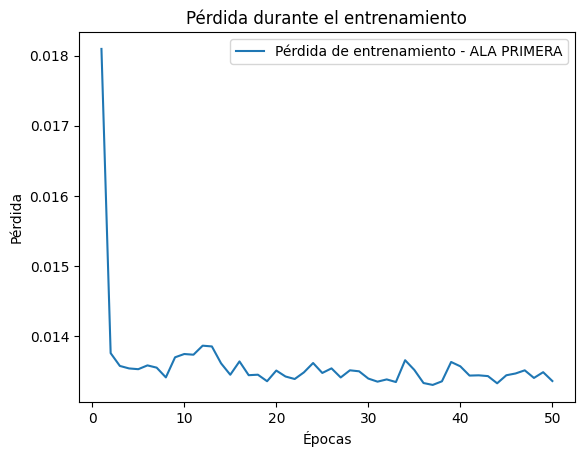

8/8 [==============================] - 0s 6ms/step


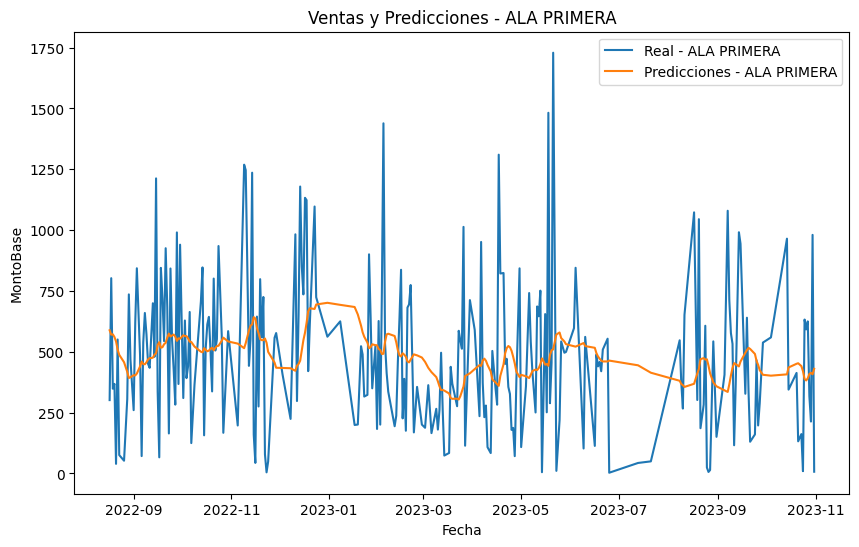

Dimensiones de fechas: (254,)
Dimensiones de predicciones: (253, 1)
La longitud de X_test es: 253 y la longitud de y_test es: 253
Forma de input_data: (2, 30, 1)
Forma de input_data después del reshape: (2, 30, 1)
1/1 [==============================] - 0s 24ms/step
                 P-V_LSTM_ALA PRIMERA
FechaMovimiento                      
2023-11-01                          0
2023-11-02                          0
2023-11-03                          0
2023-11-04                          0
2023-11-05                          0
2023-11-06                          0
2023-11-07                          0
2023-11-08                          0
2023-11-09                          0
2023-11-10                          0
2023-11-11                          0
2023-11-12                          0
2023-11-13                          0
2023-11-14                          0
2023-11-15                          0
2023-11-16                          0
2023-11-17                          0
2023-11-18  

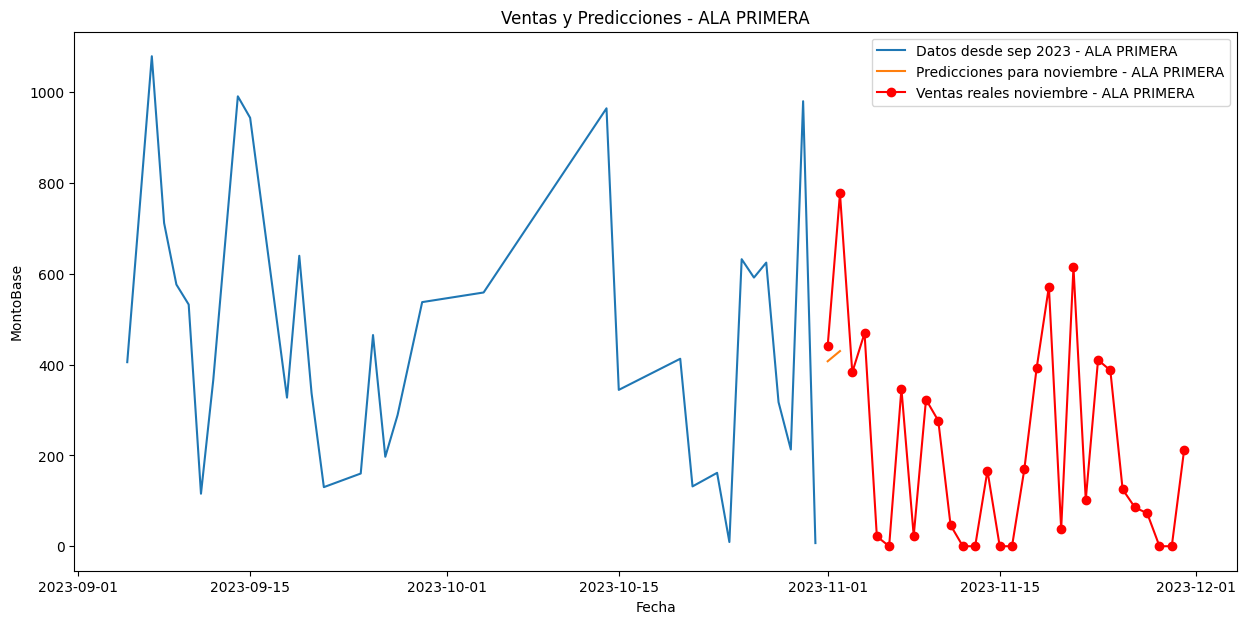

In [ ]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_data = product_df_lstm[product_df_lstm.index >= '2023-09-01']['MontoBase'].values


    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)

    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    # Verificar si hay datos disponibles después de '2023-09-01'
    if len(last_data) >= seq_length:
        last_data = scaler.transform(last_data.reshape(-1, 1))
        input_data, _ = create_sequences(last_data, seq_length)

        # Imprimir la forma de input_data para depuración
        print("Forma de input_data:", input_data.shape)

        # Verificar si input_data está vacío antes del reshape
        if input_data.shape[0] == 0:
            print("¡Error! input_data está vacío.")
        else:
            # Reshape para el modelo LSTM
            input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
            # Imprimir la forma después del reshape para depuración
            print("Forma de input_data después del reshape:", input_data.shape)

        # Hacer predicciones para el futuro
        predictions_future = model.predict(input_data)
        #predictions_future_nov = model.predict(last_data)

#df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])

        # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
        fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
        predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
        predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
        predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
        predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

        # Imprimir el DataFrame inicial para depuración
        print(predicciones_df_lstm)

        # Desnormalizar las predicciones
        predictions_future = scaler.inverse_transform(predictions_future)

        # Actualizar las predicciones reales en las fechas correspondientes
        predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

        # Imprimir el DataFrame actualizado para depuración
        print(predicciones_df_lstm)

        # Agregar la columna al DataFrame original
        dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

        # Visualizar los resultados
        plt.figure(figsize=(15, 7))
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = '2023-09-01'
        end_date = '2023-11-30'
        plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
        plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
        # Datos reales de noviembre
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title('Ventas y Predicciones - ' + product)
        plt.xlabel('Fecha')
        plt.ylabel('MontoBase')
        plt.legend()
        plt.show()
    else:
        print("No hay suficientes datos después de '2023-09-01' para hacer predicciones futuras.")
        # # Almacenar las predicciones en el objeto principal
        # dfs_noviembre_sumados[product] = pd.merge(dfs_noviembre_sumados[product], predictions_df_lstm, on='FechaMovimiento', how='left')

In [ ]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float64
dtype: object
{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
FechaMovimiento                                                          
2023-11-01       POLLO ESPECIAL  1999.7321                   1918.6519   
2023-11-02       POLLO ESPECIAL  1011.2892                   1794.0805   
2023-11-03       POLLO ESPECIAL  2343.7883                   2008.2326   
2023-11-04       POLLO ESPECIAL  1673.2089                   2429.0343   
2023-11-05       POLLO ESPECIAL  1181.9289                   1684.4395   
2023-11-06       POLLO ESPECIAL   863.7984                   1865.7316   
2023-11-07       POLLO ESPECIAL  1648.4580                   1838.9538   
2023-11-08       POLLO ESPECIAL  1434.6711                   1871.8651   
2023-11-09       POLLO ESPECIAL  16

## Evaluar LSTM




In [ ]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 698927.842865503
MAE is : 636.0269437760418
R2 is : -0.9243572256149362 %
------------------------------
RMSE is : 836.0190445590956
MAPE is : 102.61877194260518 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 274144.40654220653
MAE is : 385.0045628710938
R2 is : -0.12212586453370755 %
------------------------------
RMSE is : 523.5880122216383
MAPE is : 73.12104928323929 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 84401.63062878289
MAE is : 222.98988499023437
R2 is : 0.2734185166038443 %
------------------------------
RMSE is :

# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [ ]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, 2018-11-08 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  1618 non-null   object 
 1   MontoBase       1618 non-null   float64
dtypes: float64(1), object(1)
memory usage: 37.9+ KB


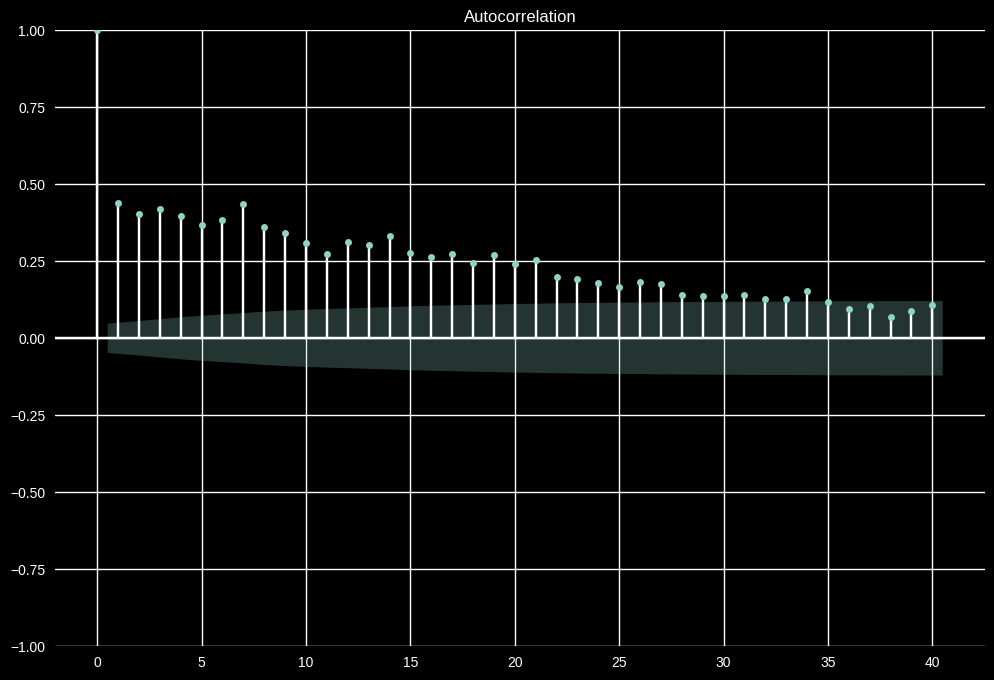

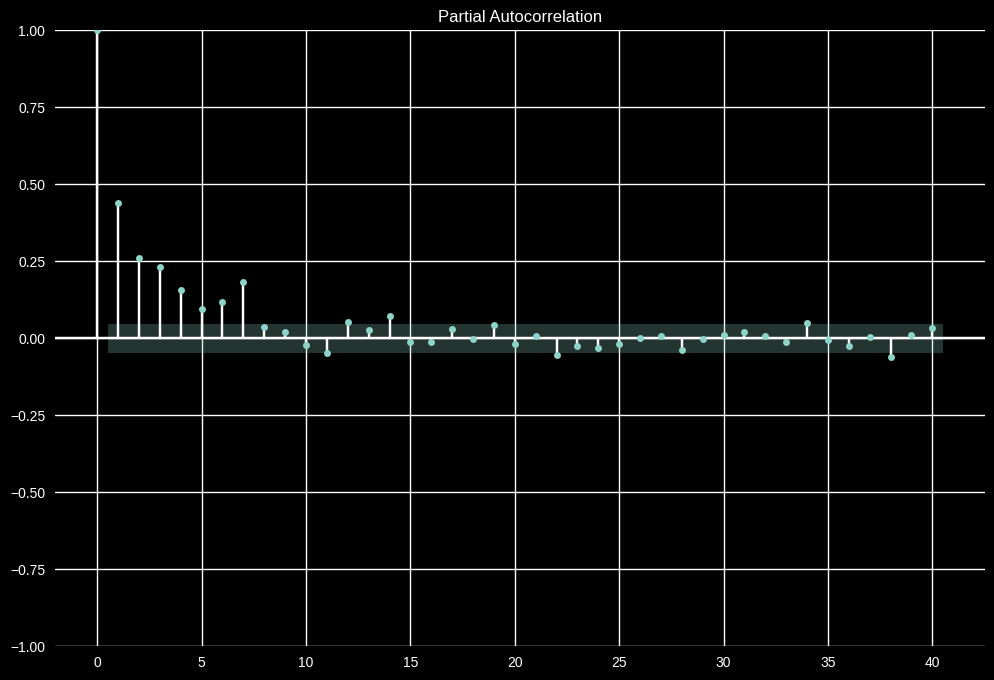

(1667, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=26567.081, Time=4.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=27384.705, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26988.798, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=26562.124, Time=6.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=27382.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=26560.133, Time=1.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=26562.125, Time=4.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=7.69 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=26560.880, Time=1.40 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=26562.279, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=26987.008, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=26561.531, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=26558.155, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=26560.146, Time=0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1667,
se supone que deeria acabar 30 despues, pero la funcion indica: 1696 

2023-10-01   1938.7217
2023-10-02   1938.7217
2023-10-03   1938.7217
2023-10-04   1938.7217
2023-10-05   1938.7217
2023-10-06   1938.7217
2023-10-07   1938.7217
2023-10-08   1938.7217
2023-10-09   1938.7217
2023-10-10   1938.7217
2023-10-11   1938.7217
2023-10-12   1938.7217
2023-10-13   1938.7217
2023-10-14   1938.7217
2023-10-15   1938.7217
2023-10-16   1938.7217
2023-10-17   1938.7217
2023-10-18   1938.7217
2023-10-19   1938.7217
2023-10-20   1938.7217
2023-10-21   1938.7217
2023-10-22   1938.7217
2023-10-23   1938.7217
2023-10-24   1938.7217
2023-10-25   1938.7217
2023-10-26   1938.7217
2023-10-27   1938.7217
2023-10-28   1938.7217
2023-10-29   1938.7217
2023-10-30   1938.7217
Freq: D, Name: ARIMA Predictions POLLO ESPECIAL, dtype: float64

Ventas reales y predicciones ARIMA para POLLO ESPECIAL:
                 MontoBase  P-V_ARIMA_POLLO ESPECIAL
FechaMovimie

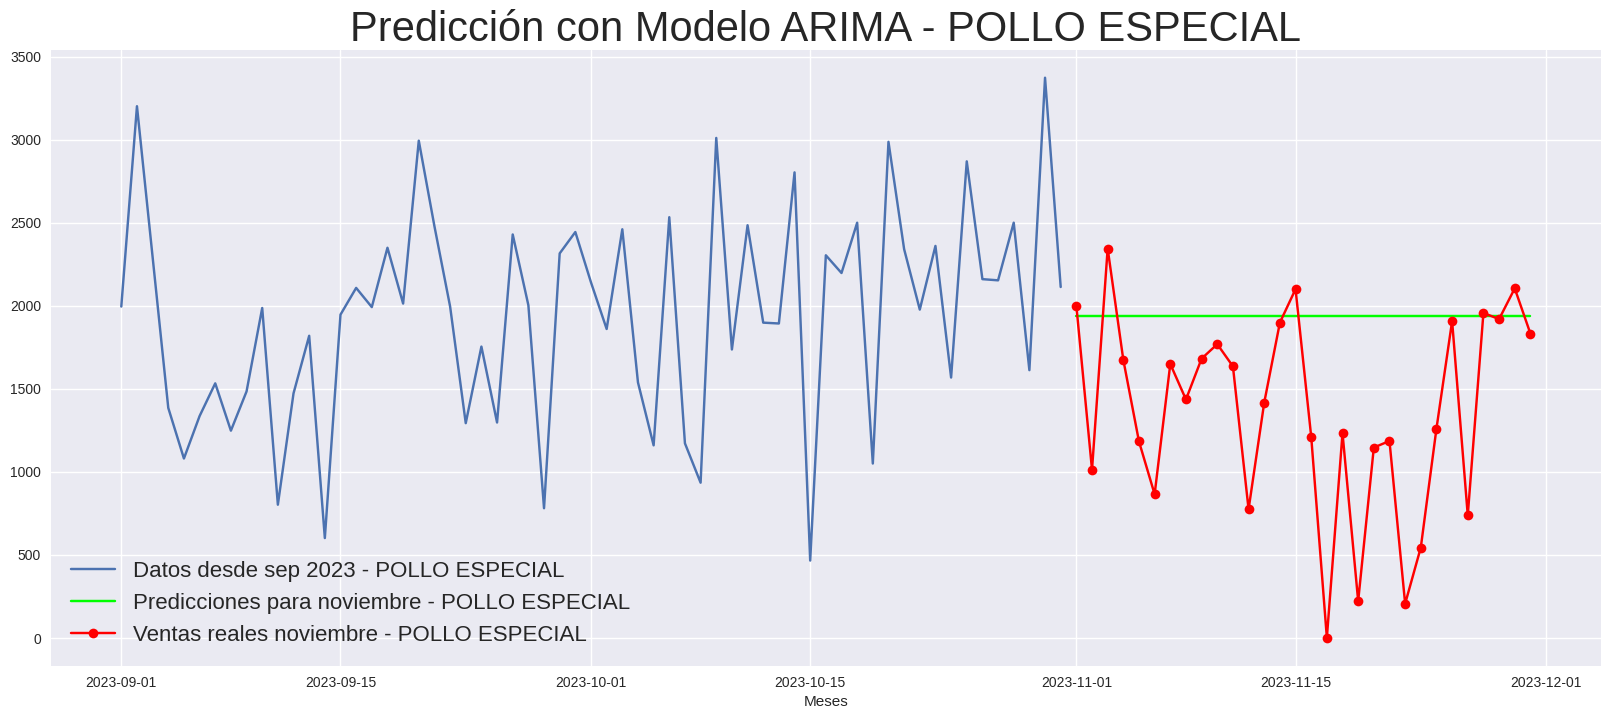

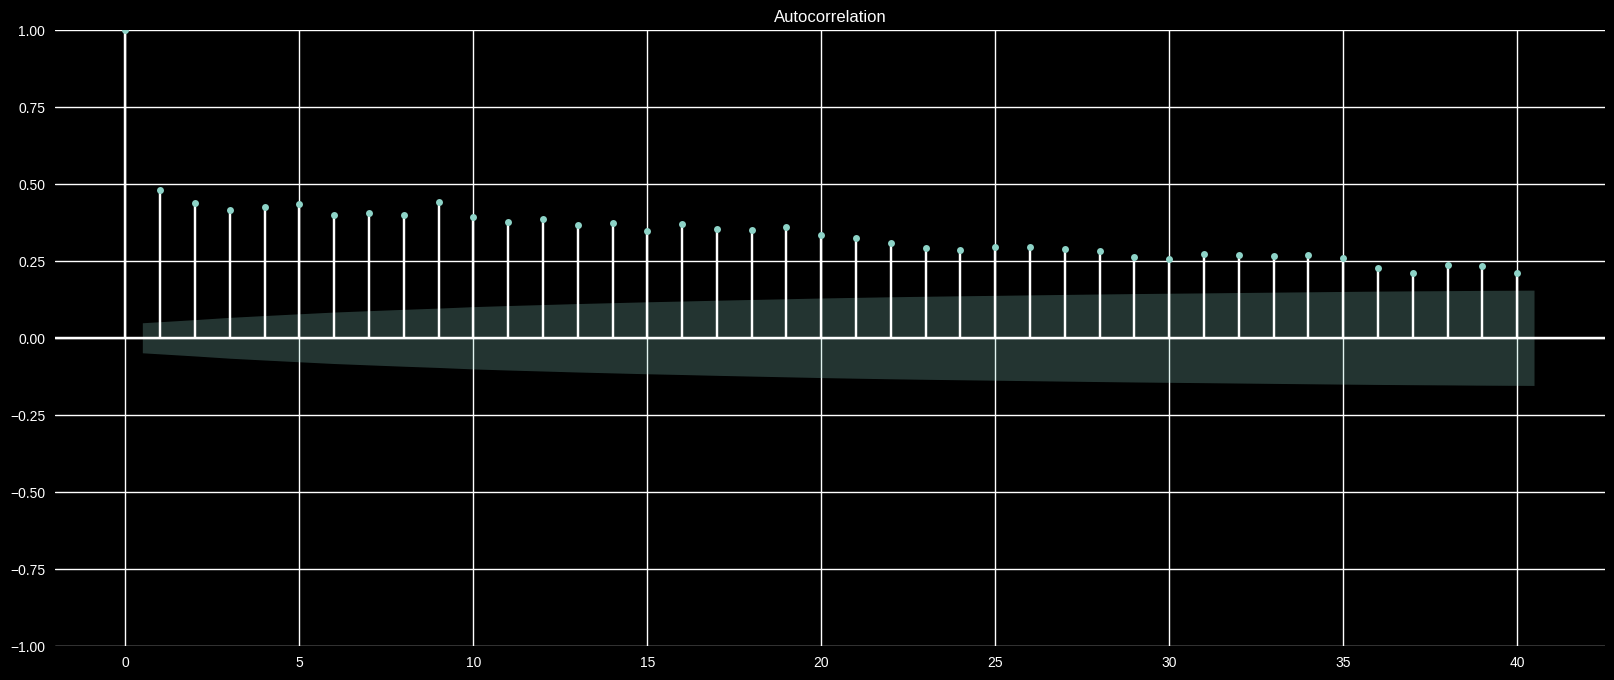

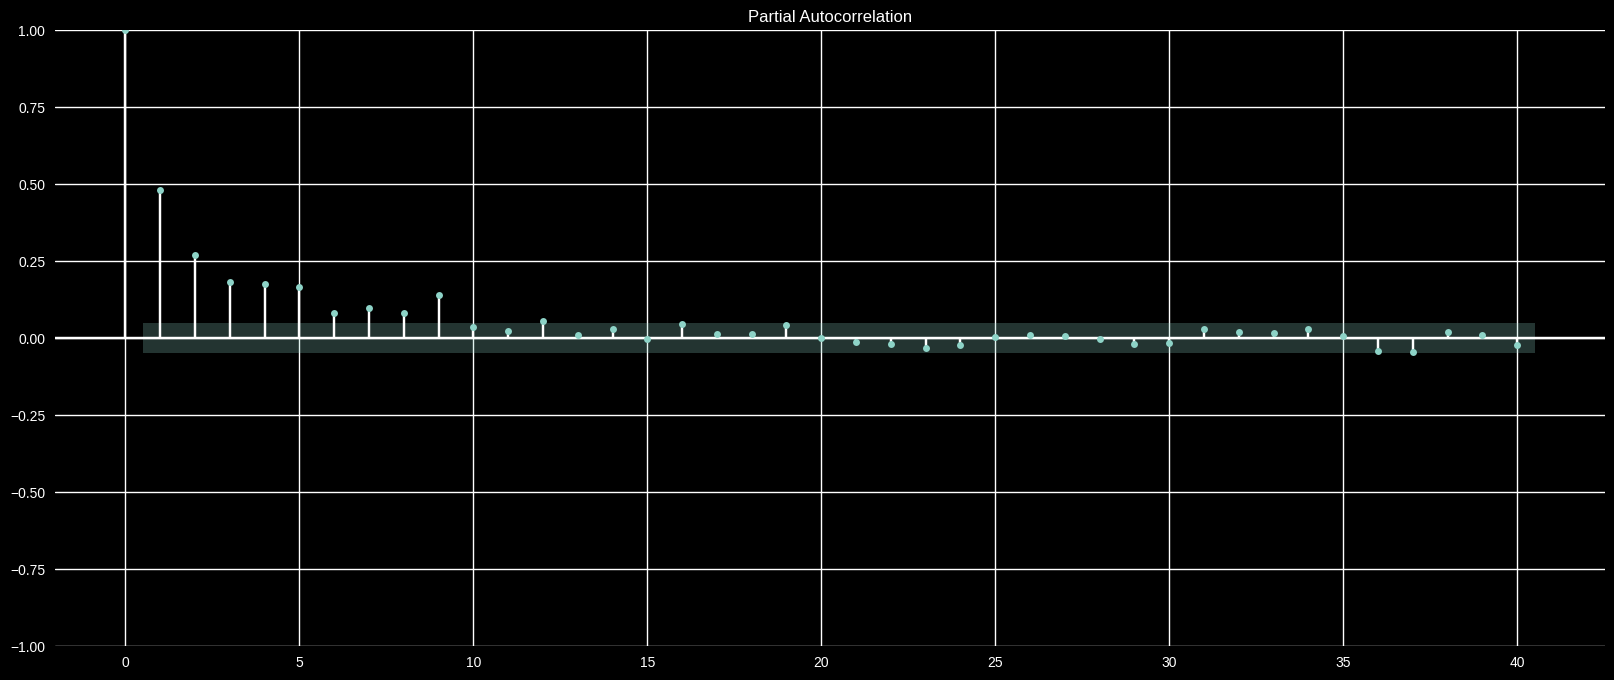

(1587, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=24781.316, Time=3.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=25572.292, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=25197.159, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=24777.389, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=25570.292, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=24775.527, Time=0.81 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=24777.398, Time=2.51 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=7.73 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=24772.072, Time=1.33 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=24773.701, Time=3.60 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=24773.675, Time=5.84 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=24774.725, Time=5.58 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=25195.561, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=24774.072, Time=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1587,
se supone que deeria acabar 30 despues, pero la funcion indica: 1616 

2023-09-29   1157.7512
2023-09-30   1187.8130
2023-10-01   1189.8454
2023-10-02   1189.9828
2023-10-03   1189.9921
2023-10-04   1189.9927
2023-10-05   1189.9927
2023-10-06   1189.9927
2023-10-07   1189.9927
2023-10-08   1189.9927
2023-10-09   1189.9927
2023-10-10   1189.9927
2023-10-11   1189.9927
2023-10-12   1189.9927
2023-10-13   1189.9927
2023-10-14   1189.9927
2023-10-15   1189.9927
2023-10-16   1189.9927
2023-10-17   1189.9927
2023-10-18   1189.9927
2023-10-19   1189.9927
2023-10-20   1189.9927
2023-10-21   1189.9927
2023-10-22   1189.9927
2023-10-23   1189.9927
2023-10-24   1189.9927
2023-10-25   1189.9927
2023-10-26   1189.9927
2023-10-27   1189.9927
2023-10-28   1189.9927
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO S

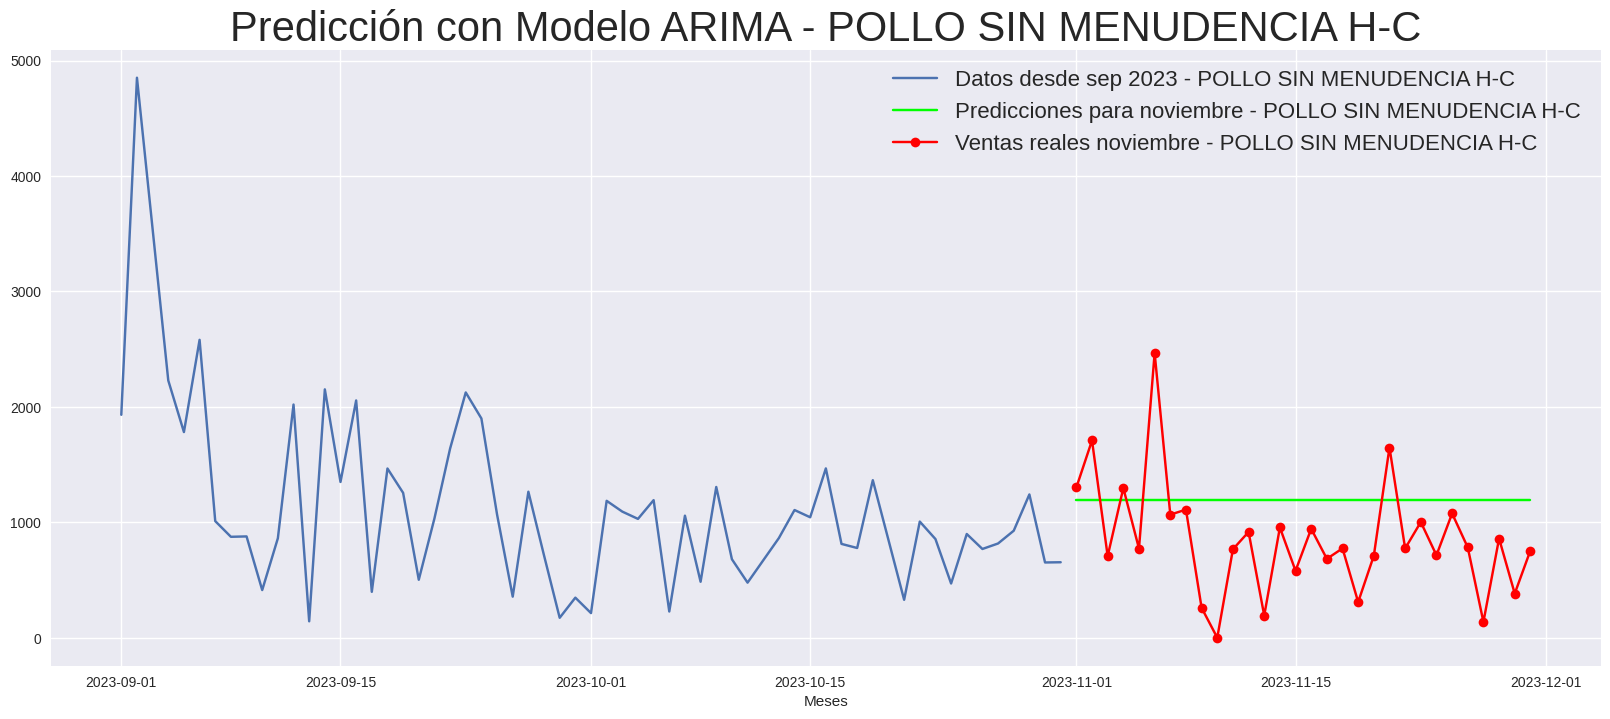

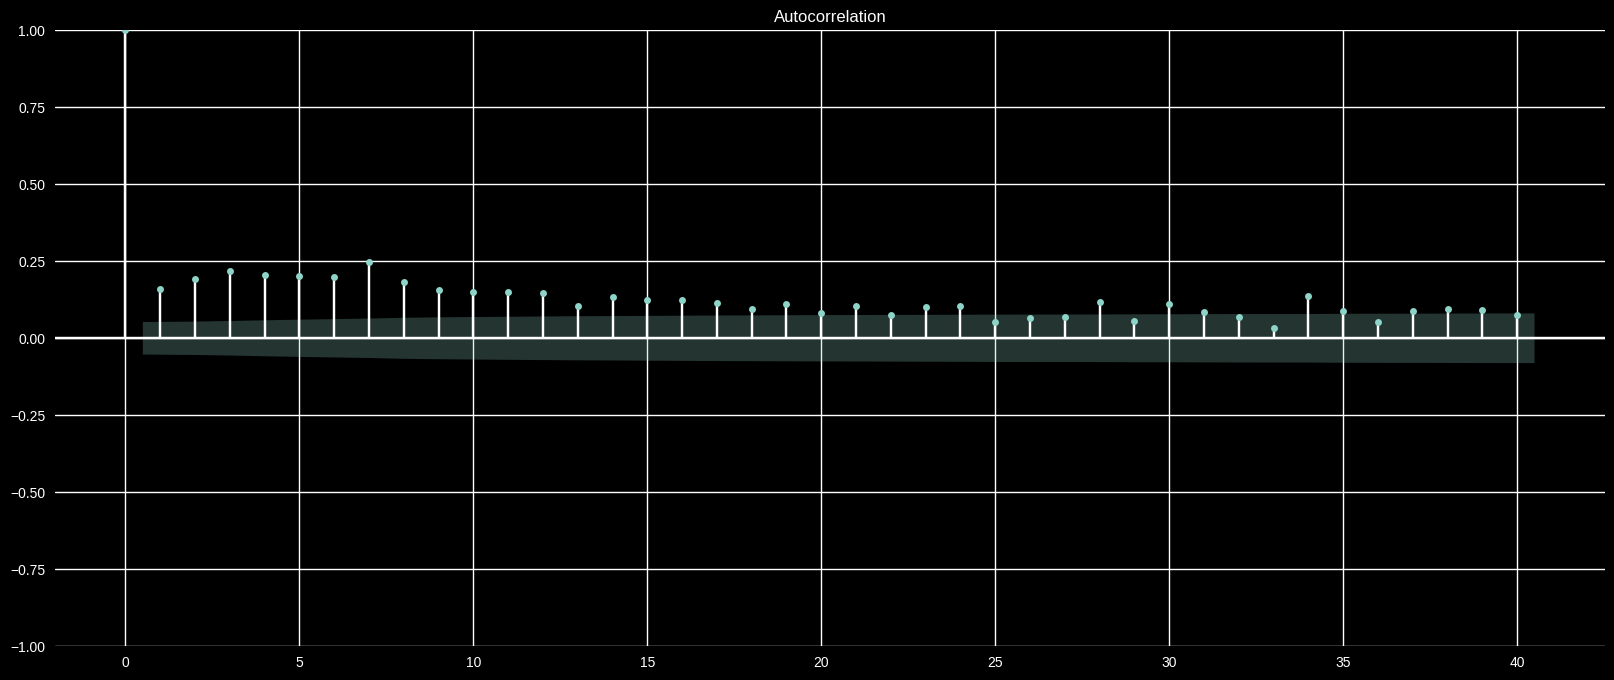

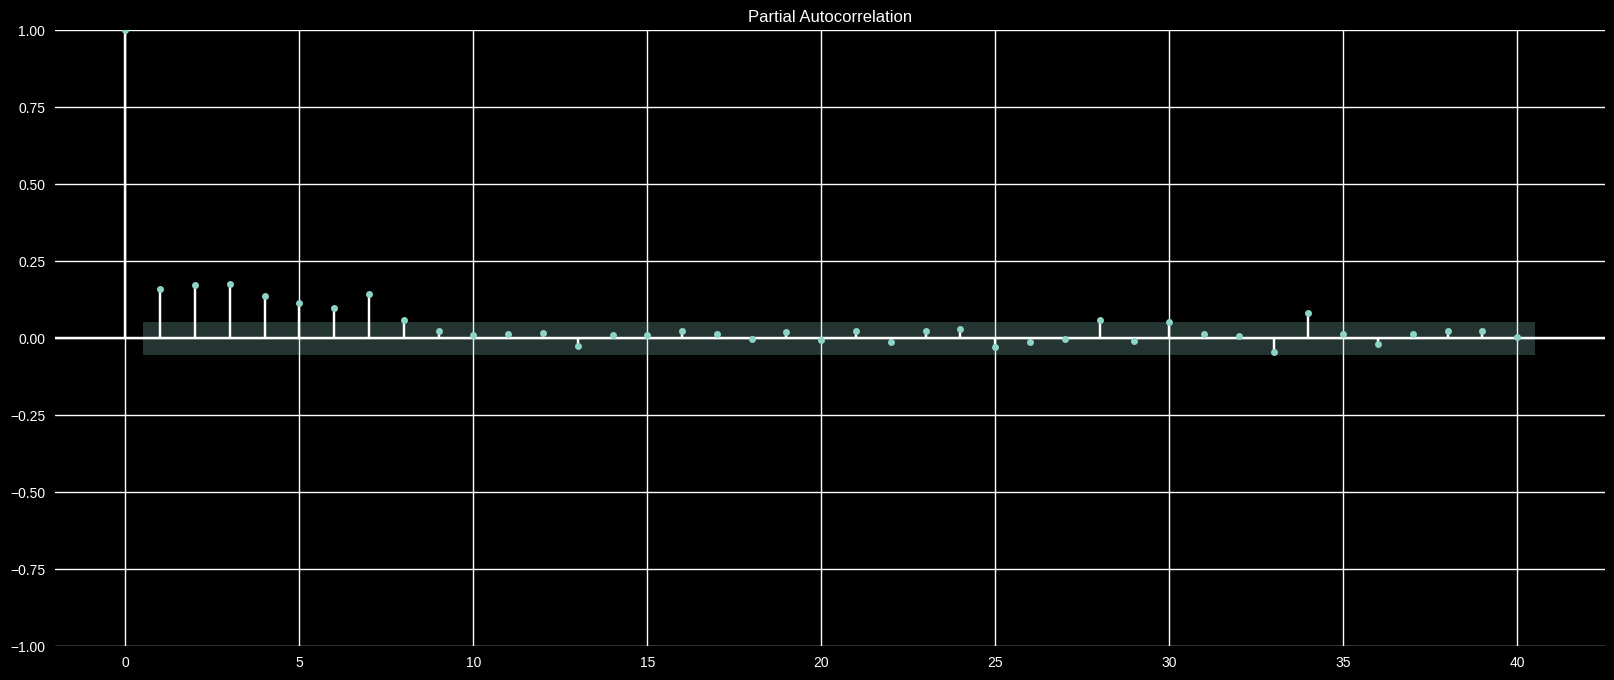

(1345, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=18875.560, Time=8.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=19724.927, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=19312.999, Time=0.88 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=18871.772, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=19722.927, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=18869.782, Time=0.41 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=18871.772, Time=1.68 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=18872.894, Time=3.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=18869.150, Time=0.89 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=18871.043, Time=2.98 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=18871.042, Time=5.19 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=18872.105, Time=3.80 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=19311.166, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=18870.530, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1345,
se supone que deeria acabar 30 despues, pero la funcion indica: 1374 

2023-09-27   551.1160
2023-09-28   543.0282
2023-09-29   543.0282
2023-09-30   543.0282
2023-10-01   543.0282
2023-10-02   543.0282
2023-10-03   543.0282
2023-10-04   543.0282
2023-10-05   543.0282
2023-10-06   543.0282
2023-10-07   543.0282
2023-10-08   543.0282
2023-10-09   543.0282
2023-10-10   543.0282
2023-10-11   543.0282
2023-10-12   543.0282
2023-10-13   543.0282
2023-10-14   543.0282
2023-10-15   543.0282
2023-10-16   543.0282
2023-10-17   543.0282
2023-10-18   543.0282
2023-10-19   543.0282
2023-10-20   543.0282
2023-10-21   543.0282
2023-10-22   543.0282
2023-10-23   543.0282
2023-10-24   543.0282
2023-10-25   543.0282
2023-10-26   543.0282
Freq: D, Name: ARIMA Predictions PECHUGA, dtype: float64

Ventas reales y predicciones ARIMA para PECHUGA:
                 MontoBase  P-V_ARIMA_PECHUGA
FechaMovimiento                              
2023-11-01       

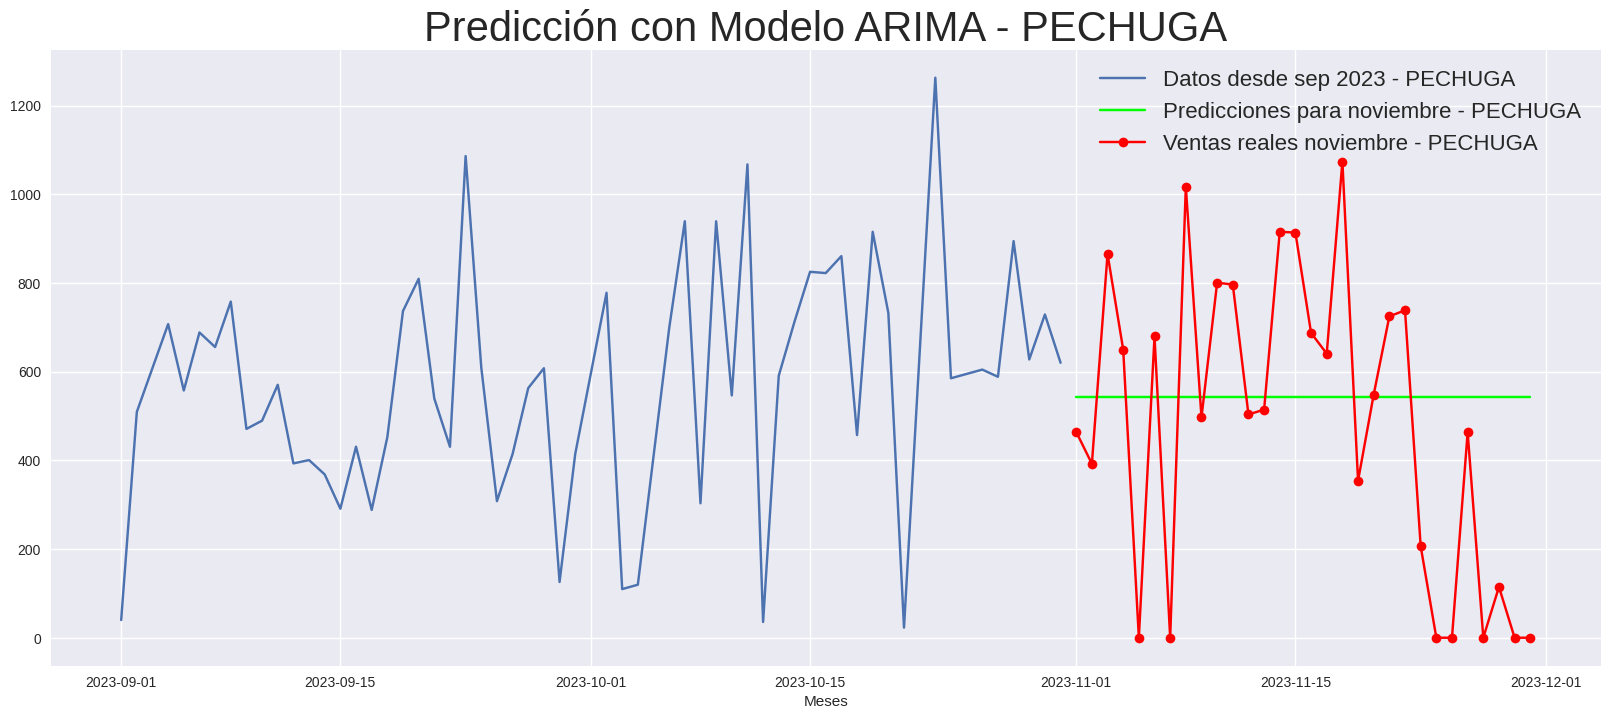

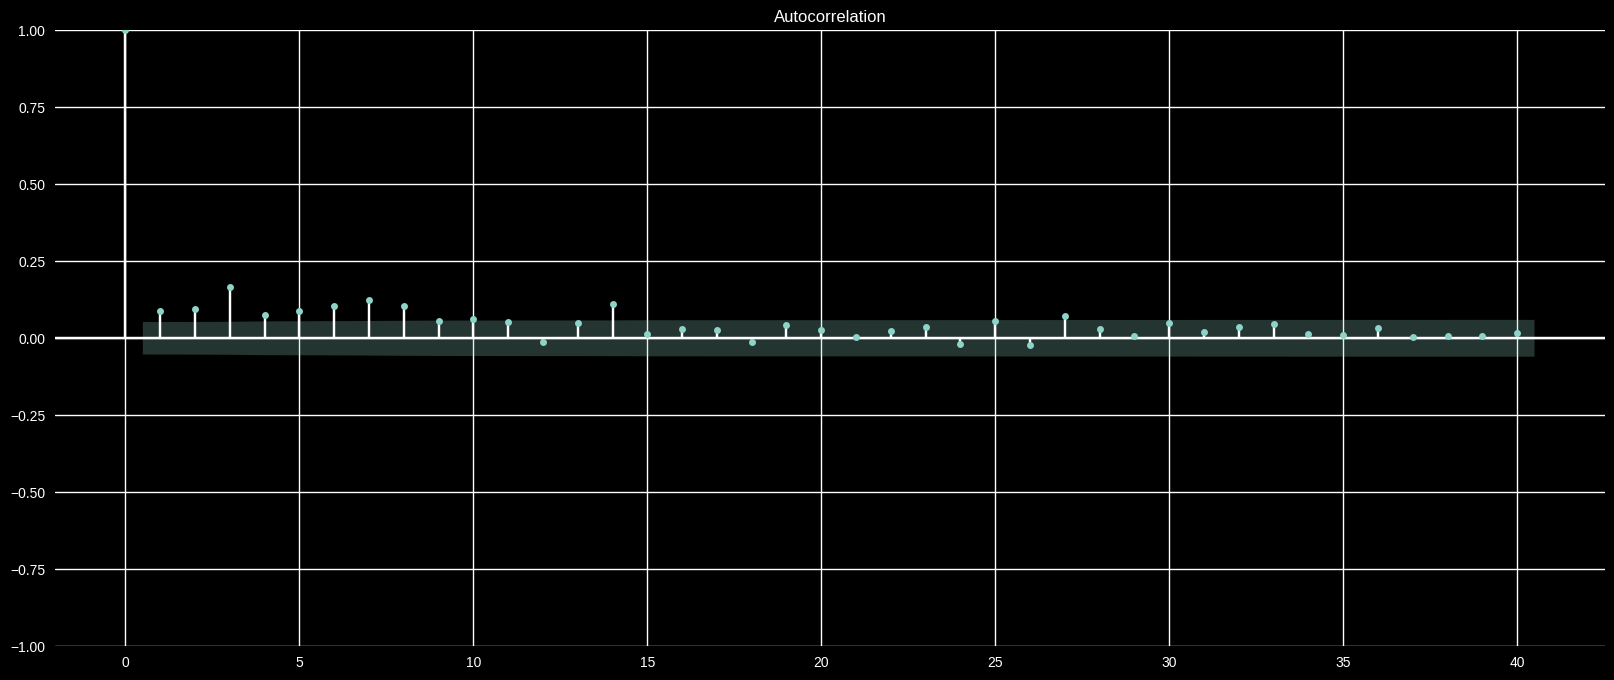

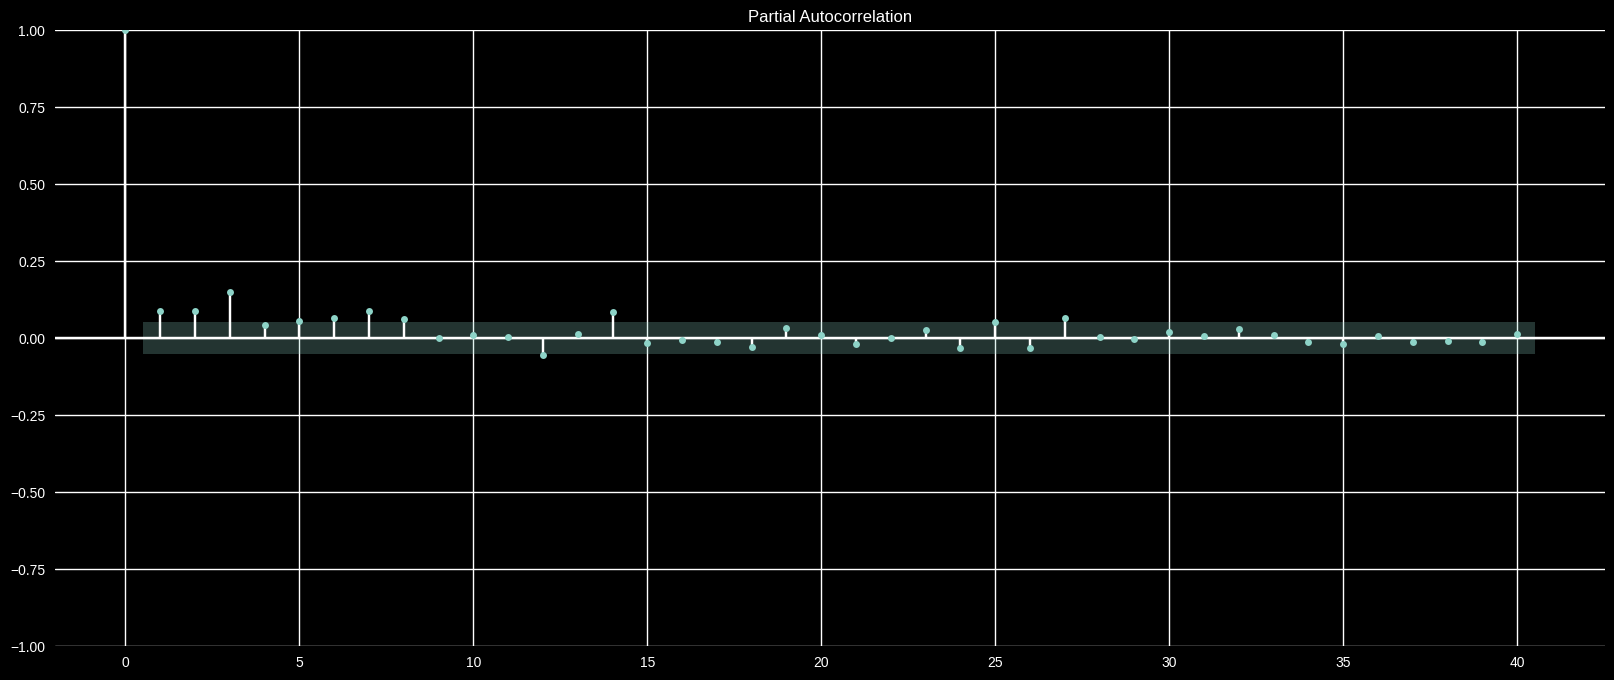

(1354, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=19779.675, Time=8.84 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=20636.135, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=20231.916, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=19775.865, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=20634.135, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=19784.689, Time=0.65 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=19773.982, Time=5.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=19777.428, Time=2.39 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=19774.079, Time=9.19 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=19774.337, Time=12.49 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=19772.337, Time=9.10 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=20627.605, Time=1.13 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=19774.328, Time=11.40 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=19774.328,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1354,
se supone que deeria acabar 30 despues, pero la funcion indica: 1383 

2023-10-01   455.3263
2023-10-02   483.1751
2023-10-03   452.7025
2023-10-04   505.1188
2023-10-05   498.1575
2023-10-06   476.0369
2023-10-07   508.9427
2023-10-08   526.3336
2023-10-09   531.5356
2023-10-10   508.0685
2023-10-11   535.2264
2023-10-12   518.5295
2023-10-13   478.5515
2023-10-14   492.7136
2023-10-15   477.3414
2023-10-16   513.9866
2023-10-17   510.1653
2023-10-18   488.3207
2023-10-19   504.6935
2023-10-20   519.5807
2023-10-21   523.1590
2023-10-22   498.0410
2023-10-23   527.8253
2023-10-24   502.4283
2023-10-25   502.7697
2023-10-26   502.7697
2023-10-27   502.7697
2023-10-28   502.7697
2023-10-29   502.7697
2023-10-30   502.7697
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
                 MontoBase  P-V_ARIMA_PIERNA MUSLO
FechaMovimiento                                 

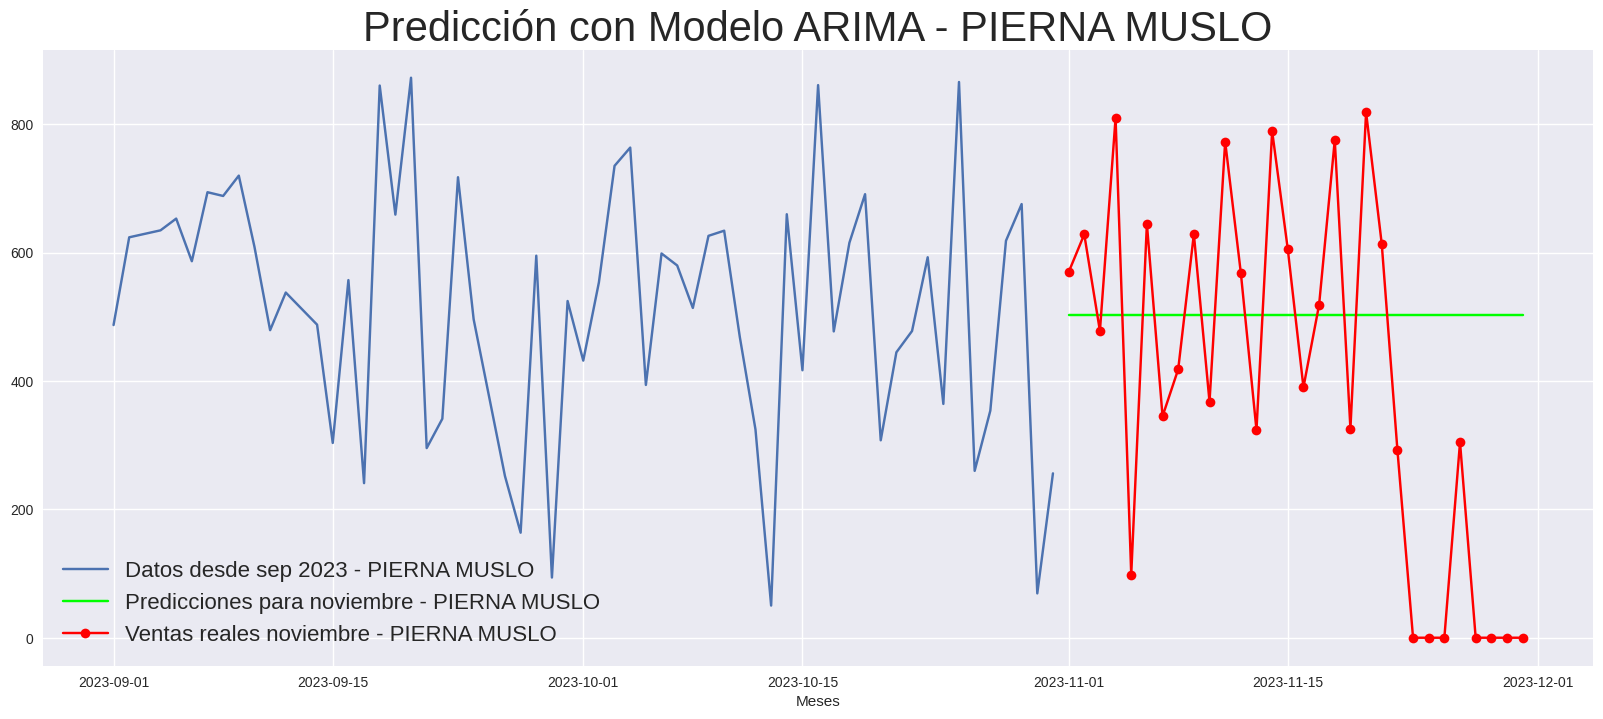

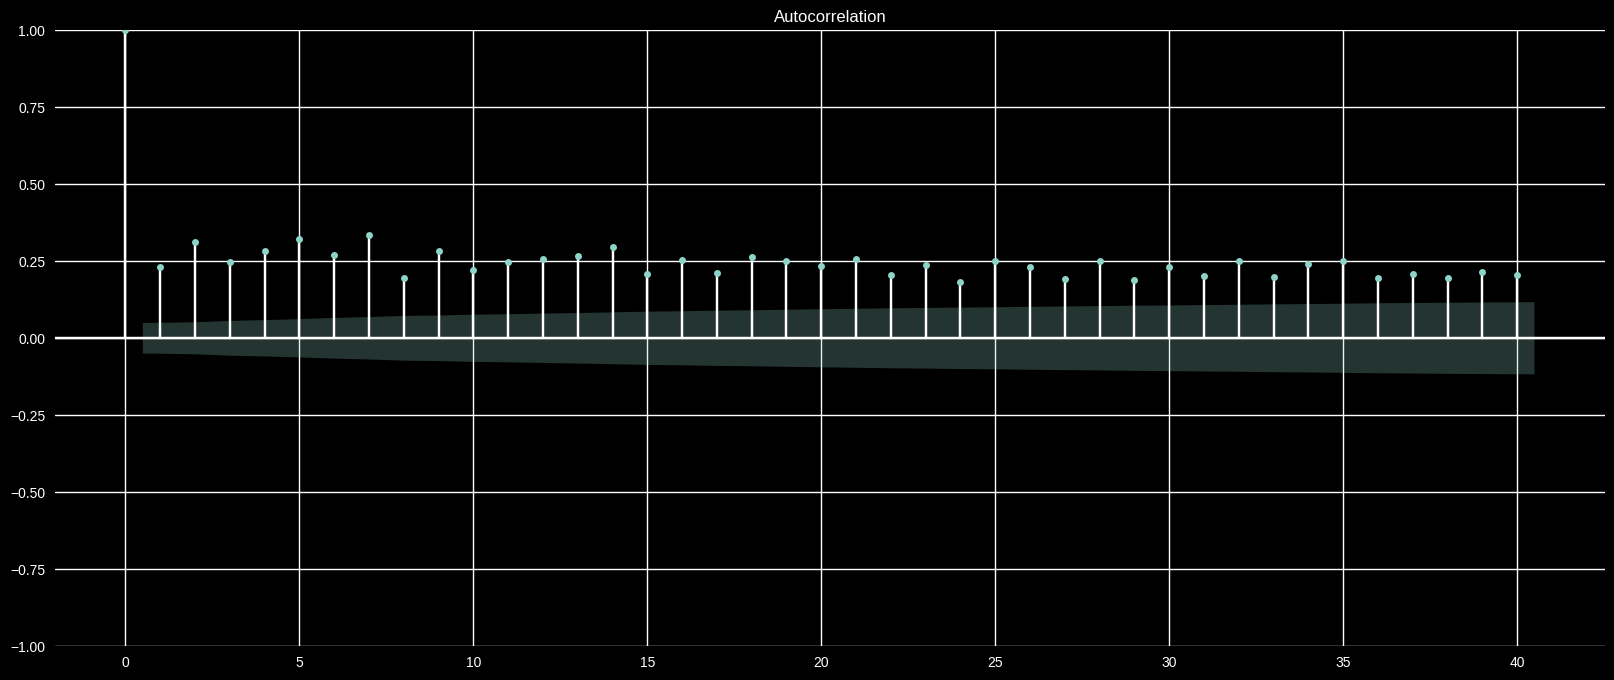

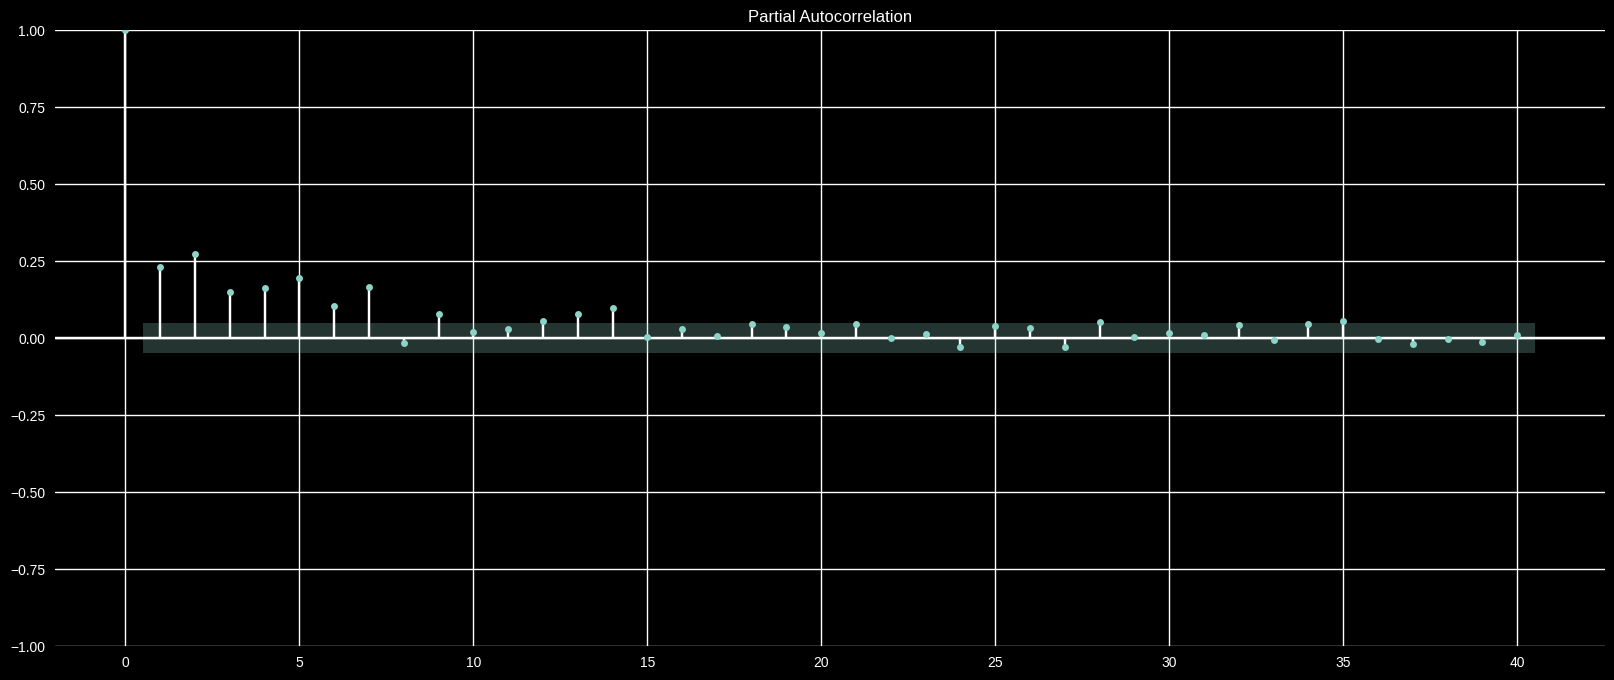

(1543, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=21281.741, Time=10.05 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22346.530, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=21783.002, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=21291.562, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22344.531, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=8.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=7.89 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=21279.309, Time=25.54 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=21279.685, Time=23.61 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=21280.484, Time=25.70 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=21279.327, Time=21.37 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=21274.284, Time=19.75 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=21277.350, Time=8.21 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=21275.207, Time=16

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

el ultimo indice_valor de los datos reales es: 1543,
se supone que deeria acabar 30 despues, pero la funcion indica: 1572 

2023-09-28   542.0961
2023-09-29   590.4264
2023-09-30   513.1915
2023-10-01   544.7294
2023-10-02   523.4975
2023-10-03   568.5616
2023-10-04   549.5211
2023-10-05   573.7510
2023-10-06   526.5347
2023-10-07   531.3947
2023-10-08   553.8540
2023-10-09   585.1941
2023-10-10   580.2255
2023-10-11   578.7199
2023-10-12   558.8418
2023-10-13   548.1341
2023-10-14   506.5493
2023-10-15   579.0151
2023-10-16   505.0556
2023-10-17   579.6654
2023-10-18   563.1711
2023-10-19   561.3699
2023-10-20   571.6003
2023-10-21   575.7823
2023-10-22   567.3977
2023-10-23   549.8249
2023-10-24   566.6768
2023-10-25   553.4834
2023-10-26   560.9510
2023-10-27   560.1046
Freq: D, Name: ARIMA Predictions FILETE A GRANEL, dtype: float64

Ventas reales y predicciones ARIMA para FILETE A GRANEL:
                 MontoBase  P-V_ARIMA_FILETE A GRANEL
FechaMovimiento                        

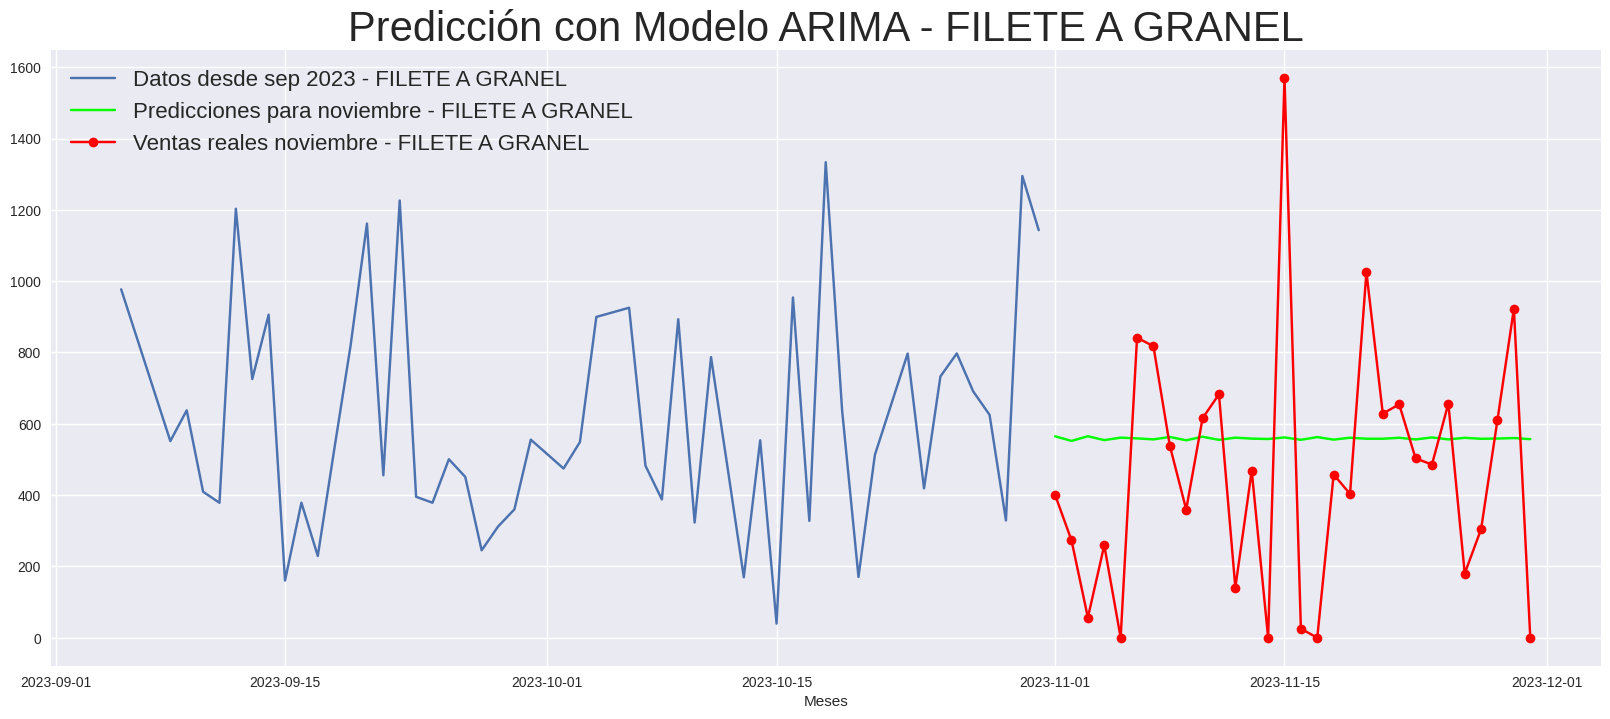

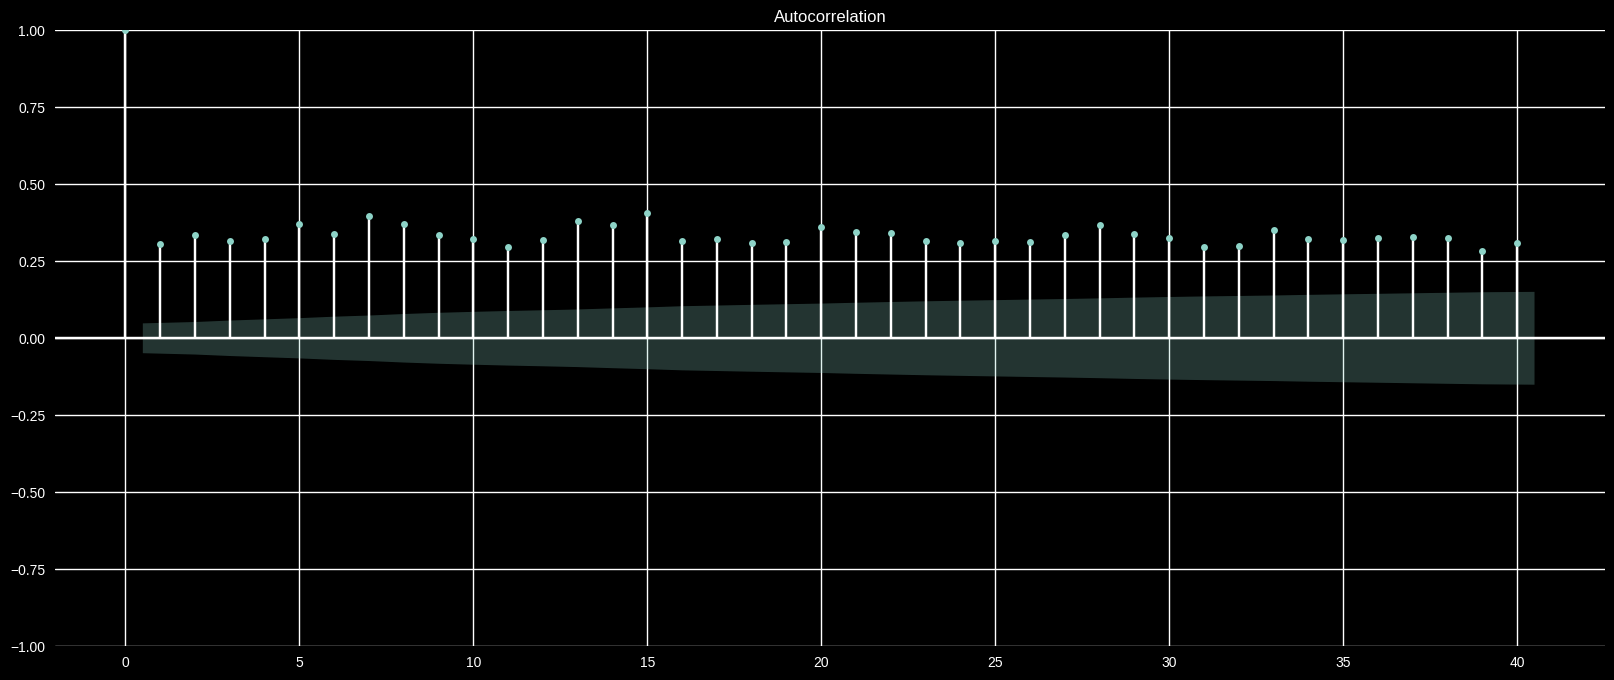

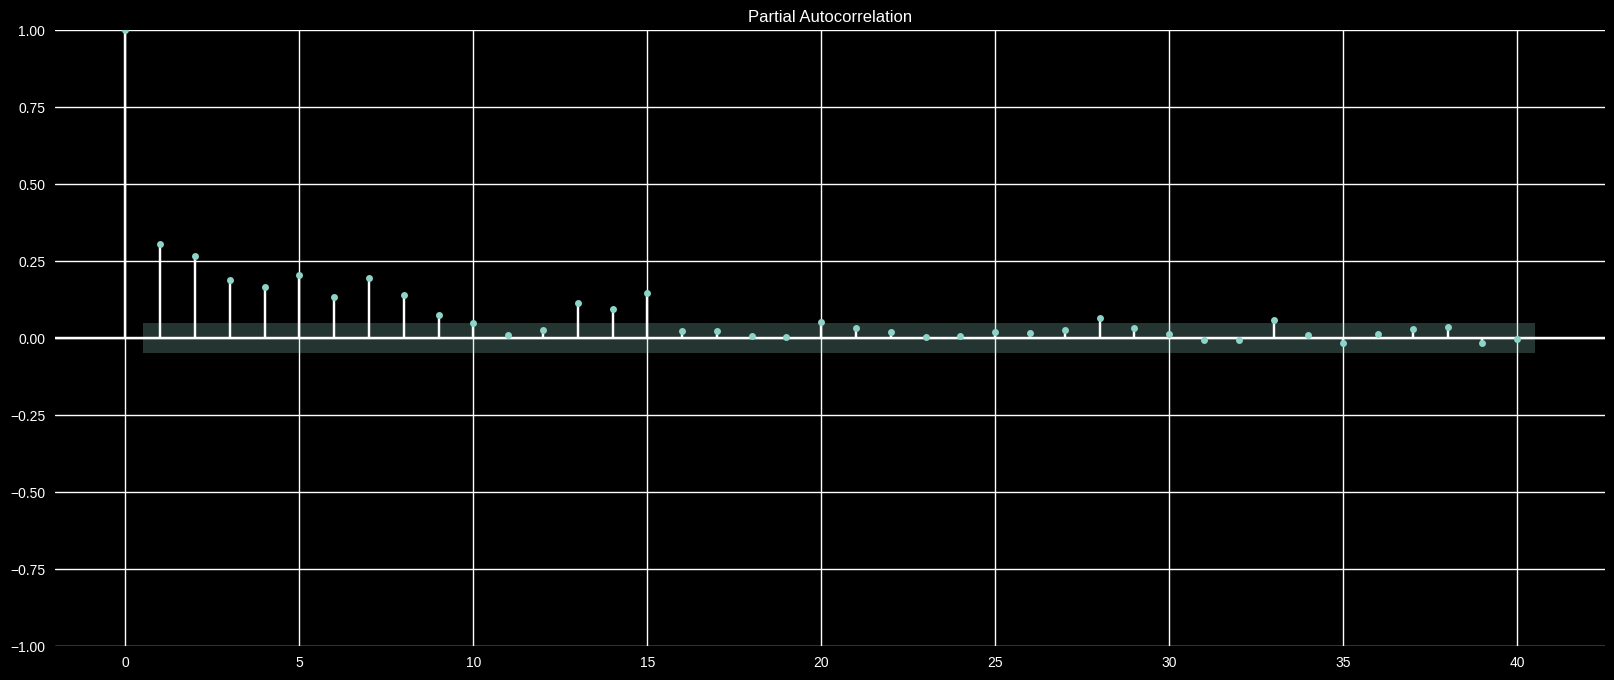

(1608, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=10.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22008.234, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=21513.984, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=20882.999, Time=2.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22006.236, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=20883.128, Time=0.74 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=20881.051, Time=8.03 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=12.00 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=22009.603, Time=1.29 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=20877.842, Time=10.29 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=20880.723, Time=3.17 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=16.17 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=8.64 sec
 ARIMA(1,1,0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

el ultimo indice_valor de los datos reales es: 1608,
se supone que deeria acabar 30 despues, pero la funcion indica: 1637 

2023-10-01   478.6489
2023-10-02   465.9200
2023-10-03   391.9475
2023-10-04   349.5043
2023-10-05   338.2962
2023-10-06   346.8877
2023-10-07   438.5127
2023-10-08   479.7700
2023-10-09   455.1350
2023-10-10   398.8477
2023-10-11   343.8890
2023-10-12   341.4762
2023-10-13   384.5519
2023-10-14   437.0017
2023-10-15   461.3782
2023-10-16   440.7747
2023-10-17   392.8123
2023-10-18   354.5083
2023-10-19   353.8240
2023-10-20   389.3524
2023-10-21   432.8585
2023-10-22   451.6191
2023-10-23   432.9584
2023-10-24   392.6433
2023-10-25   361.7230
2023-10-26   362.6873
2023-10-27   393.1965
2023-10-28   429.0836
2023-10-29   443.4171
2023-10-30   426.6474
Freq: D, Name: ARIMA Predictions PIERNA, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA:
                 MontoBase  P-V_ARIMA_PIERNA
FechaMovimiento                             
2023-11-01        191

<ipython-input-124-a3762d212a94>:70: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-124-a3762d212a94>:75: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)


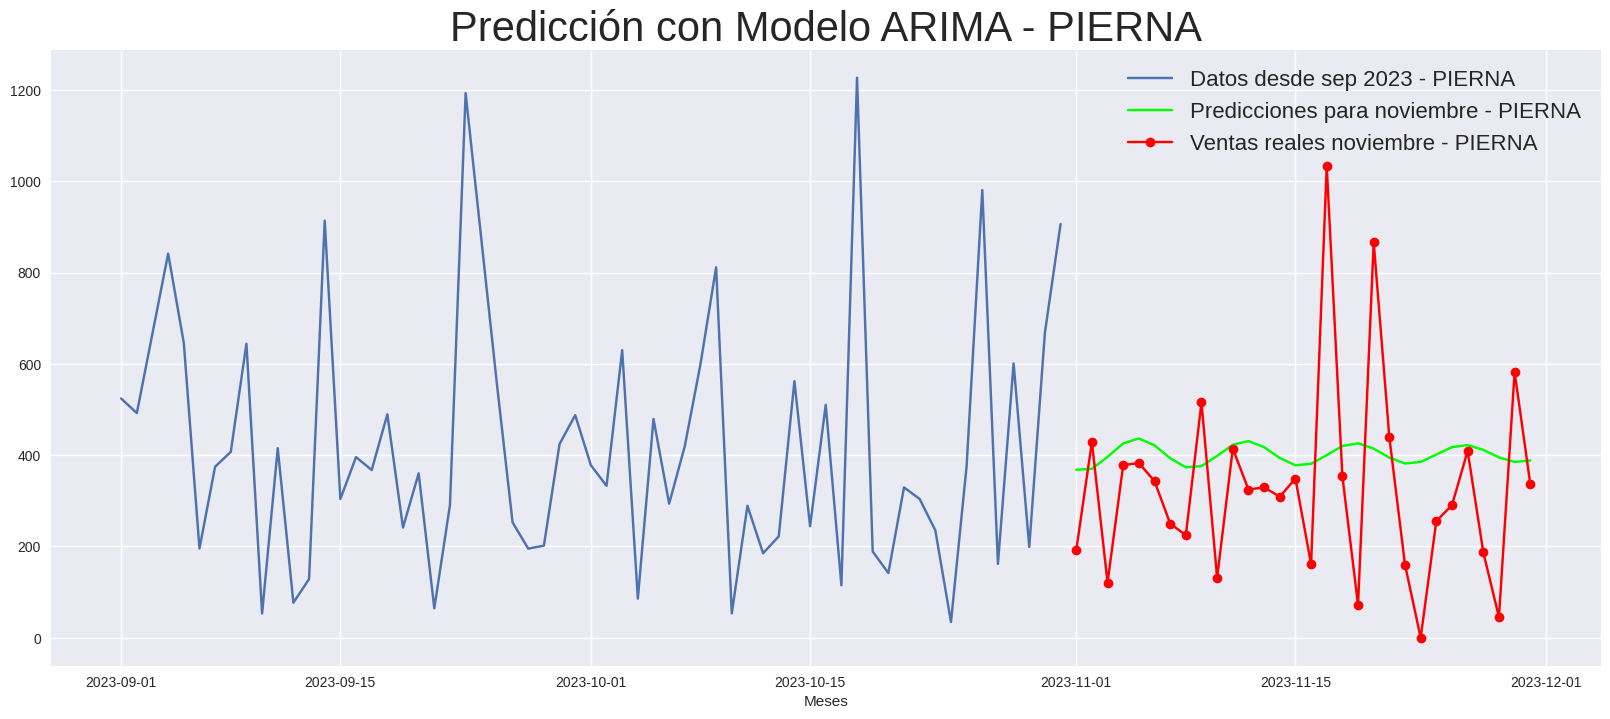

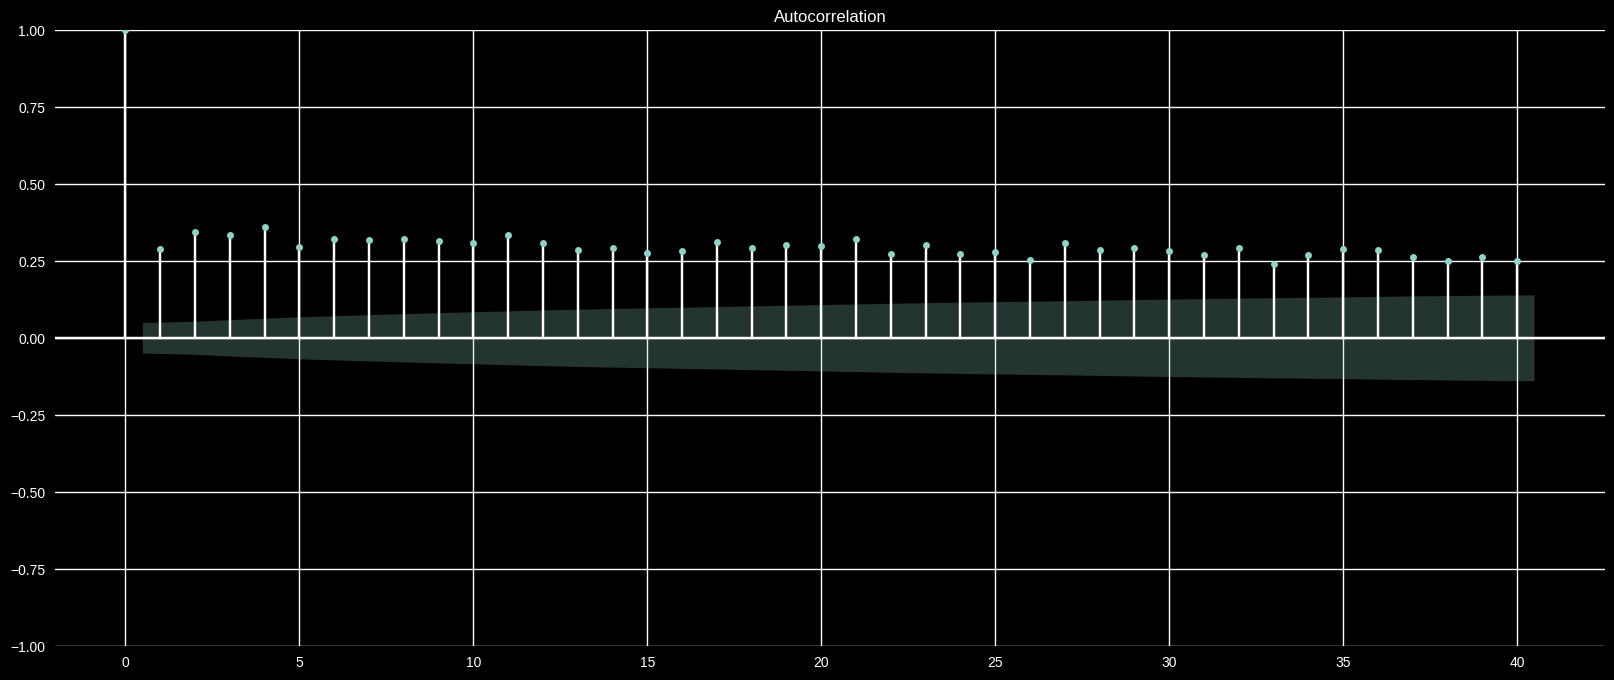

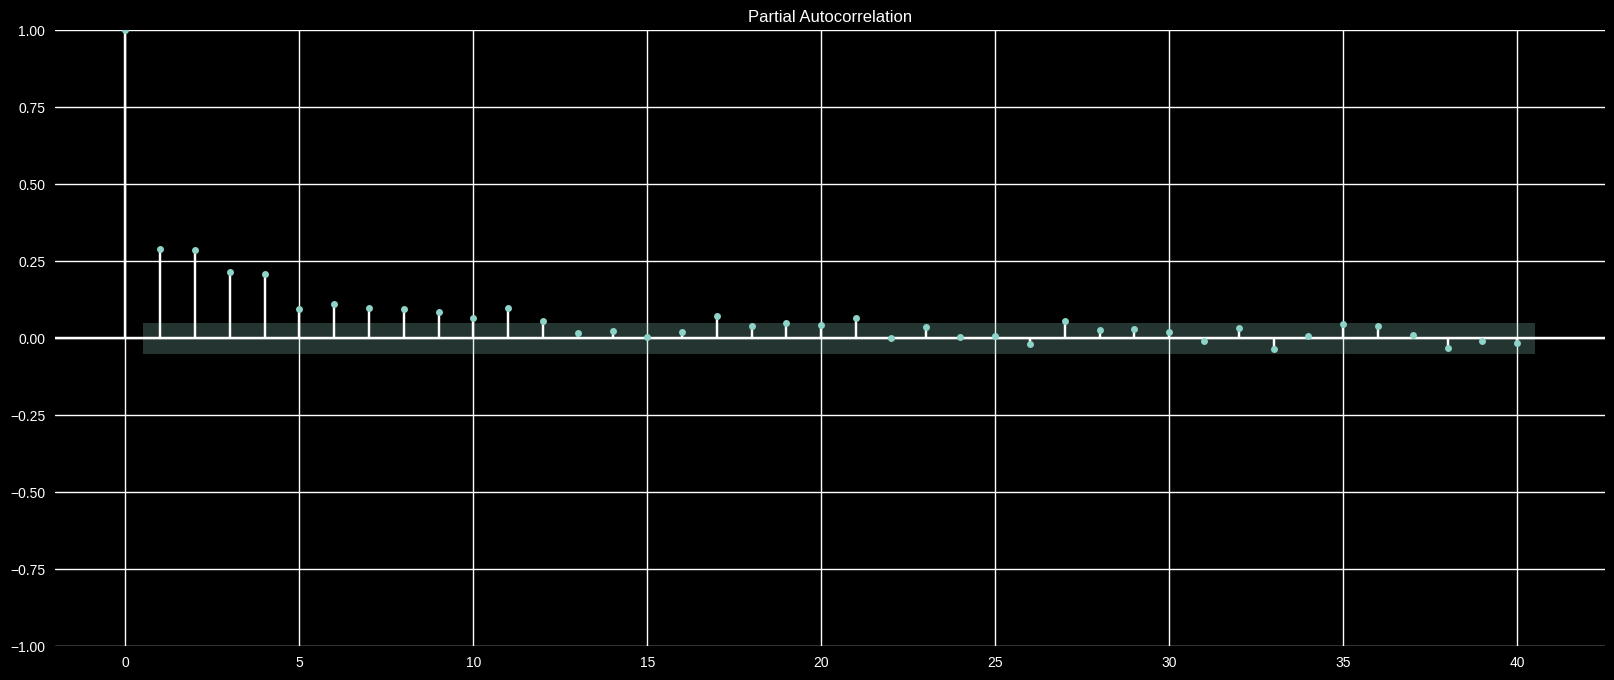

(1525, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=9.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=20860.885, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=20339.795, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=19820.235, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=20858.886, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=19818.235, Time=0.48 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=19820.235, Time=1.41 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=19822.140, Time=2.44 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=19815.669, Time=0.88 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=19817.640, Time=3.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=19817.638, Time=3.71 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=19819.653, Time=4.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=20337.862, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=19816.694, Time=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

el ultimo indice_valor de los datos reales es: 1525,
se supone que deeria acabar 30 despues, pero la funcion indica: 1554 

2023-09-29   328.3319
2023-09-30   329.0268
2023-10-01   328.9842
2023-10-02   328.9868
2023-10-03   328.9867
2023-10-04   328.9867
2023-10-05   328.9867
2023-10-06   328.9867
2023-10-07   328.9867
2023-10-08   328.9867
2023-10-09   328.9867
2023-10-10   328.9867
2023-10-11   328.9867
2023-10-12   328.9867
2023-10-13   328.9867
2023-10-14   328.9867
2023-10-15   328.9867
2023-10-16   328.9867
2023-10-17   328.9867
2023-10-18   328.9867
2023-10-19   328.9867
2023-10-20   328.9867
2023-10-21   328.9867
2023-10-22   328.9867
2023-10-23   328.9867
2023-10-24   328.9867
2023-10-25   328.9867
2023-10-26   328.9867
2023-10-27   328.9867
2023-10-28   328.9867
Freq: D, Name: ARIMA Predictions MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para MUSLO:
                 MontoBase  P-V_ARIMA_MUSLO
FechaMovimiento                            
2023-11-01        327.888

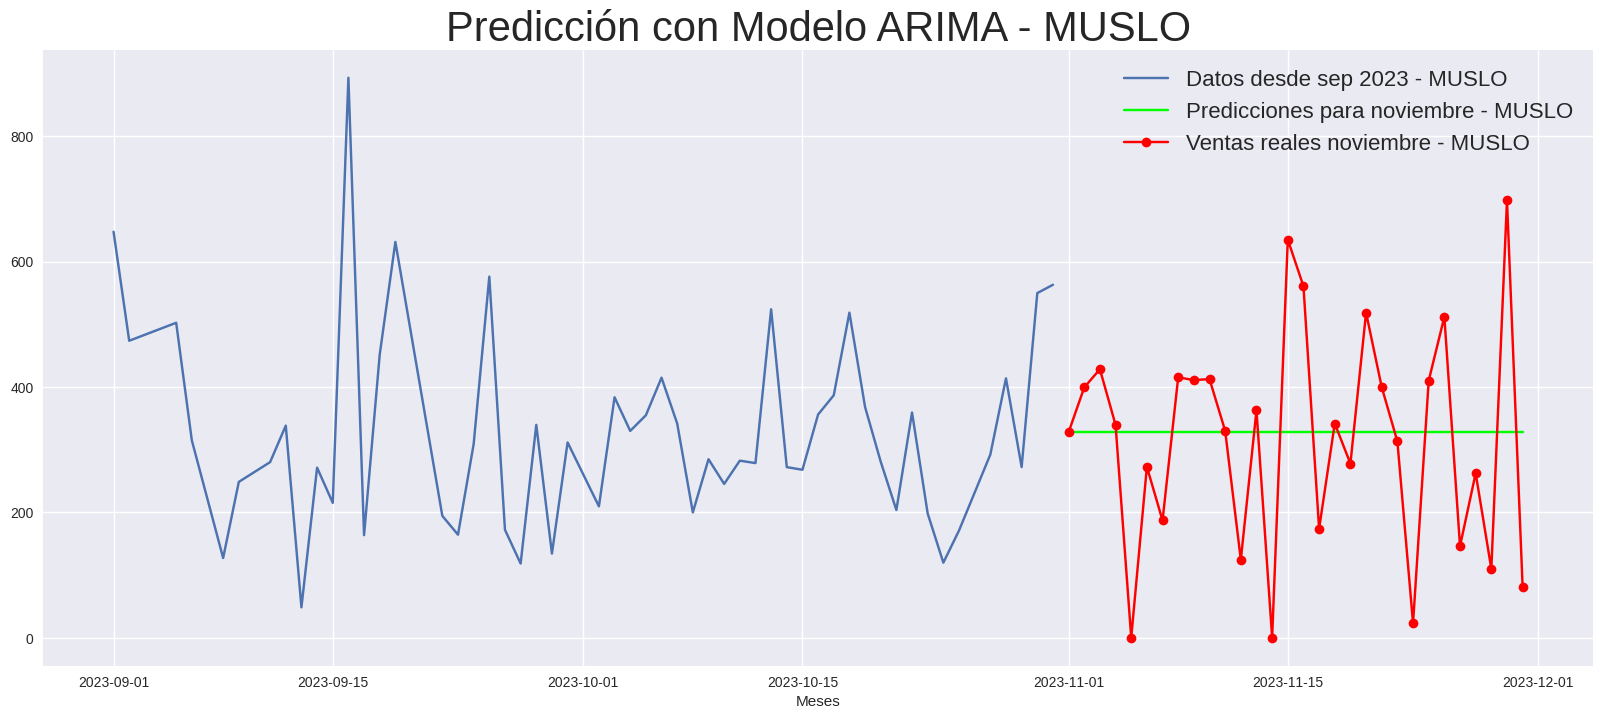

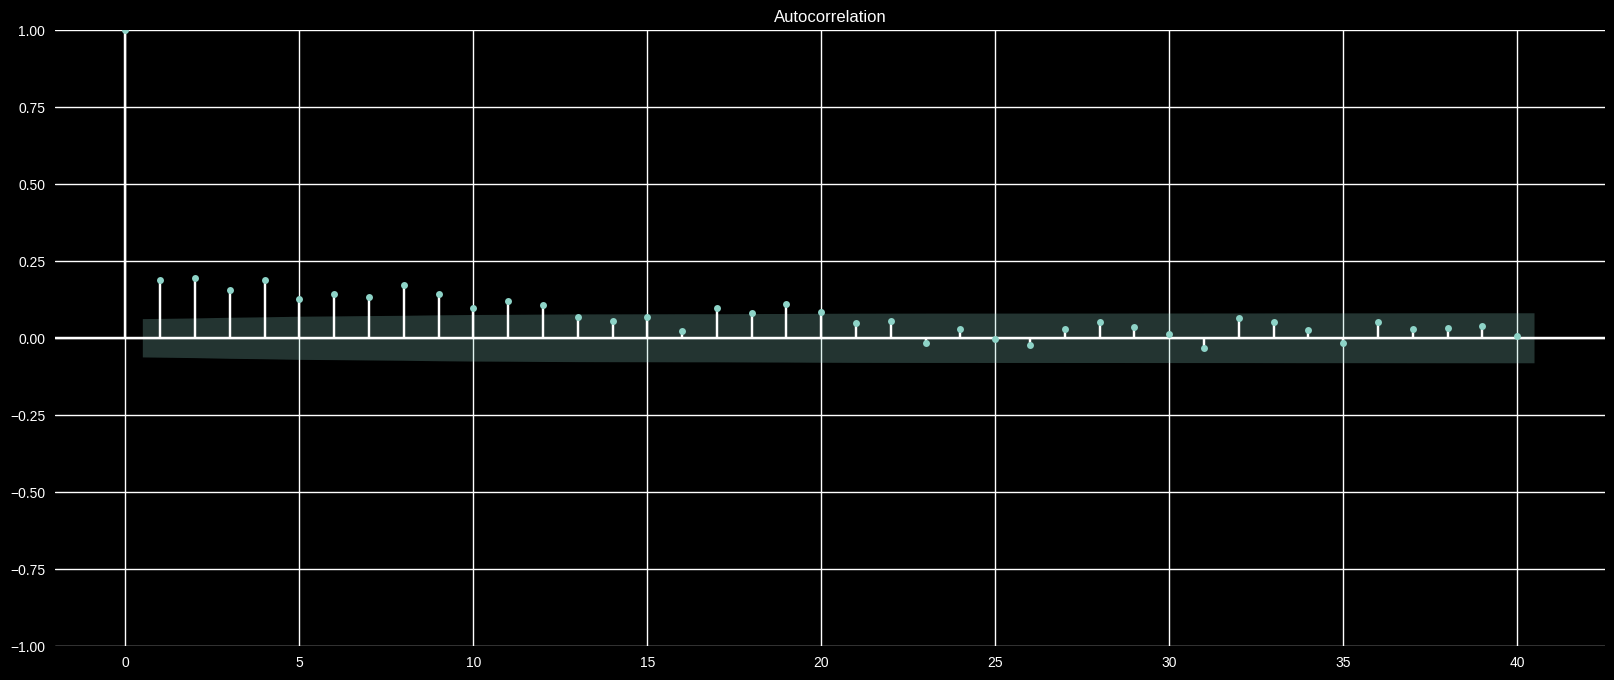

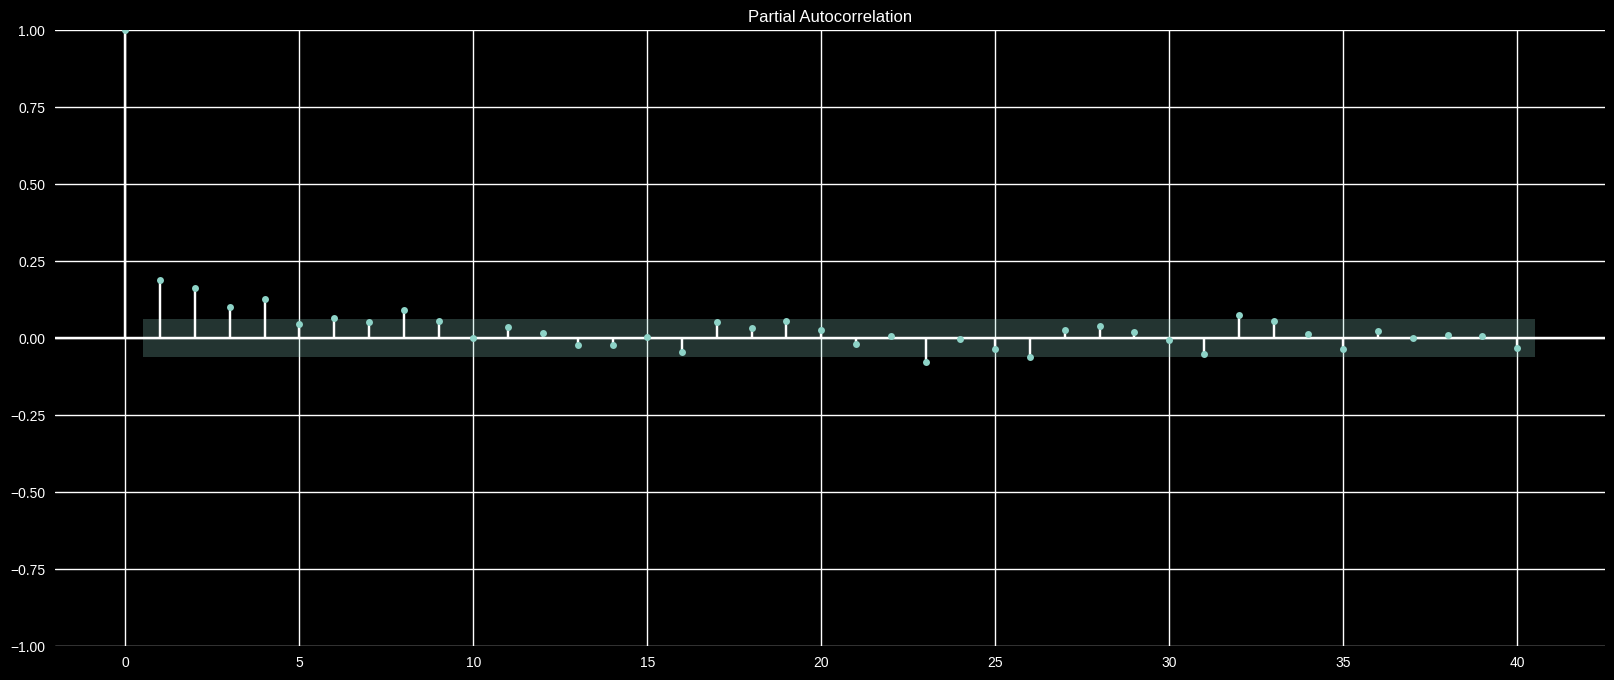

(962, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14522.491, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14244.429, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=13988.042, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14520.492, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=13986.044, Time=0.34 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=13988.042, Time=1.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=13989.419, Time=3.93 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=13987.647, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=13987.688, Time=1.43 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=14243.196, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=13984.055, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=13986.053, Time=0.48 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

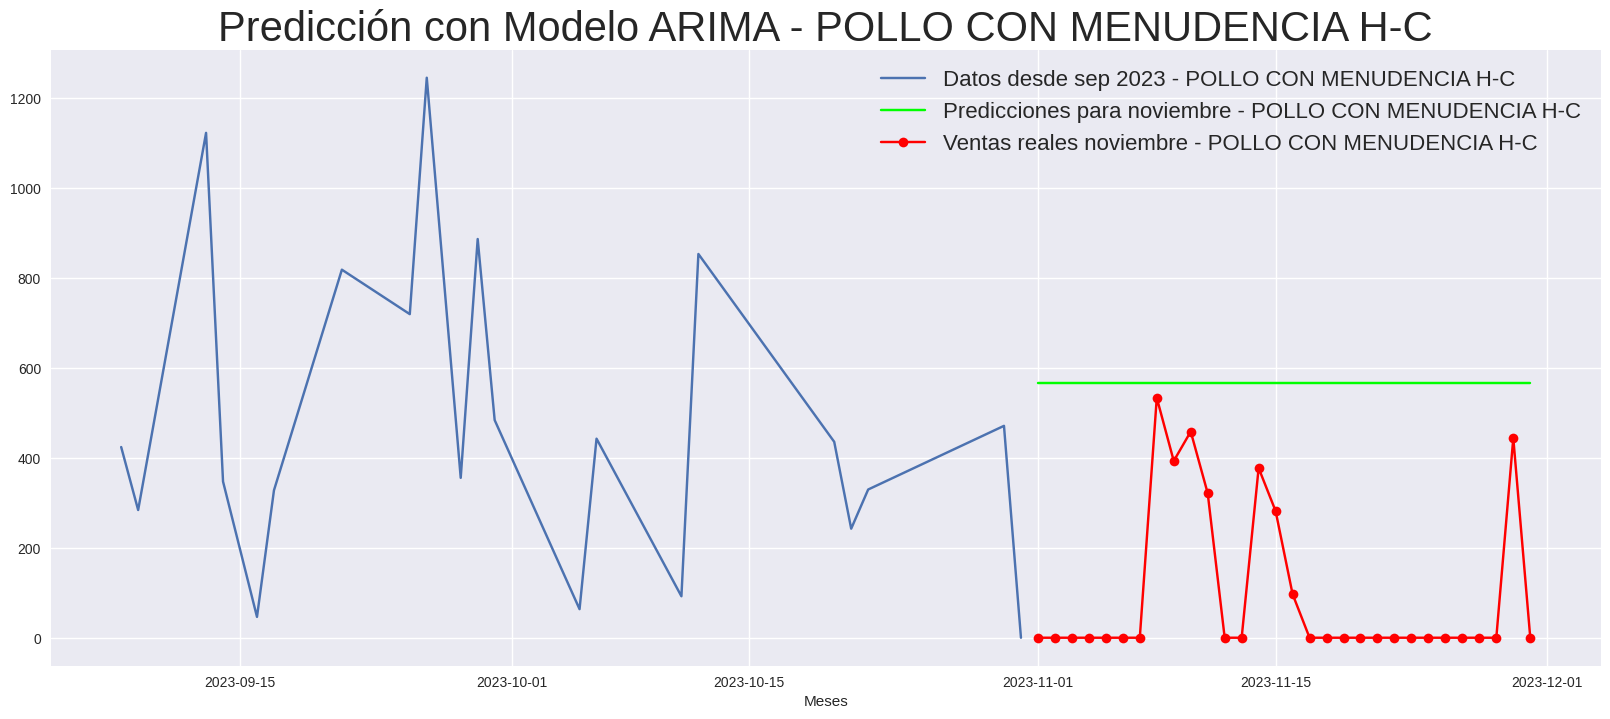

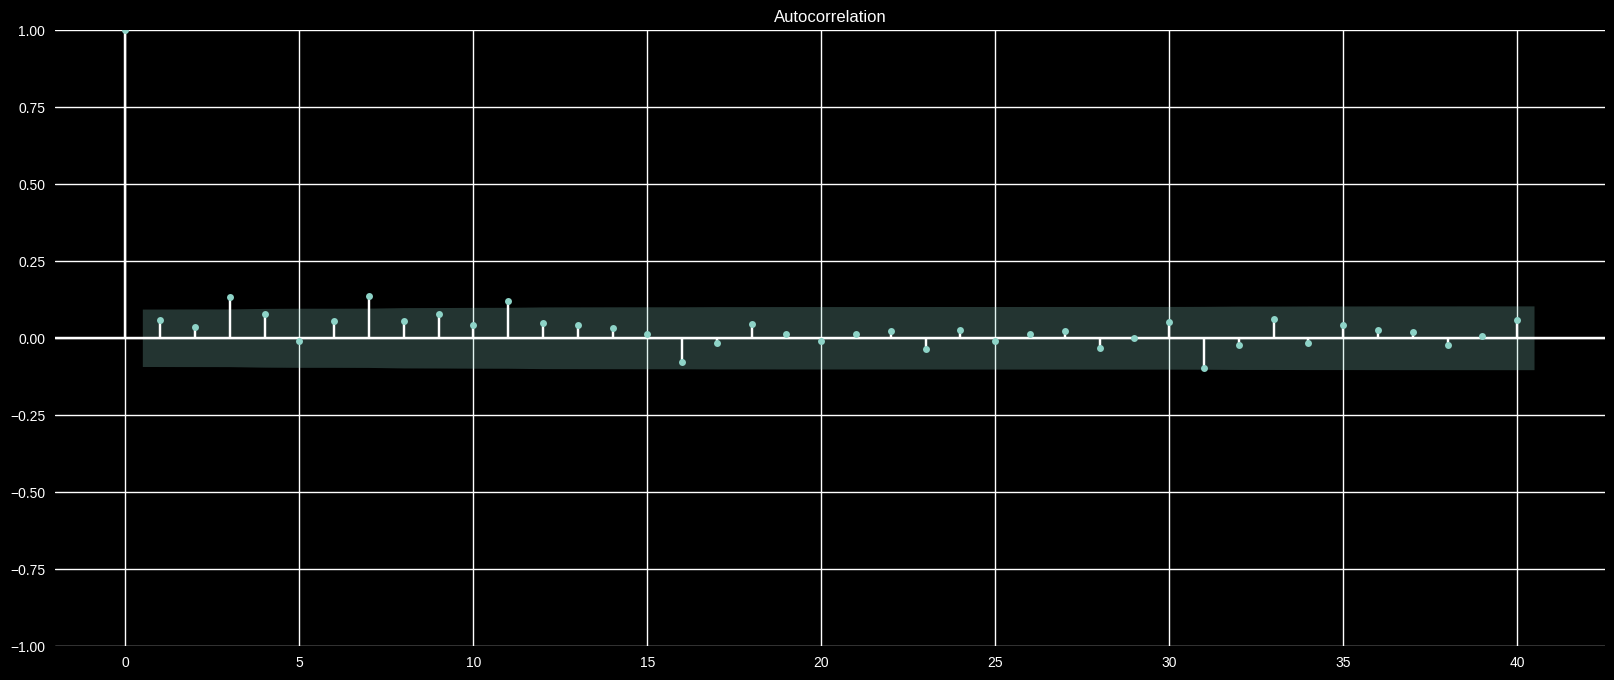

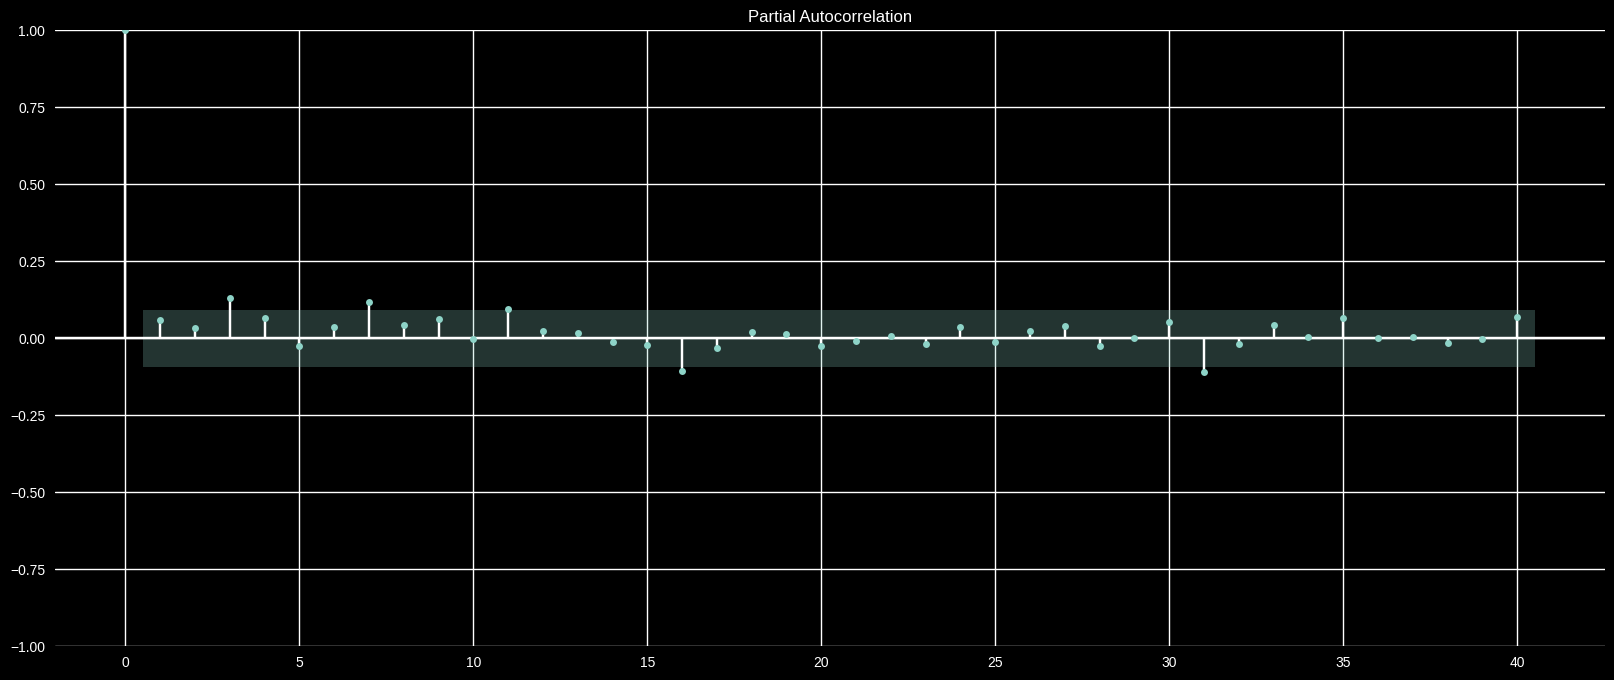

(411, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6718.621, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6610.589, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6450.114, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6716.622, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6448.136, Time=0.48 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=6450.114, Time=1.67 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6449.761, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=6449.703, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6608.835, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=6446.273, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=6448.249, Time=0.42 sec
 ARIMA(0,1,1)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

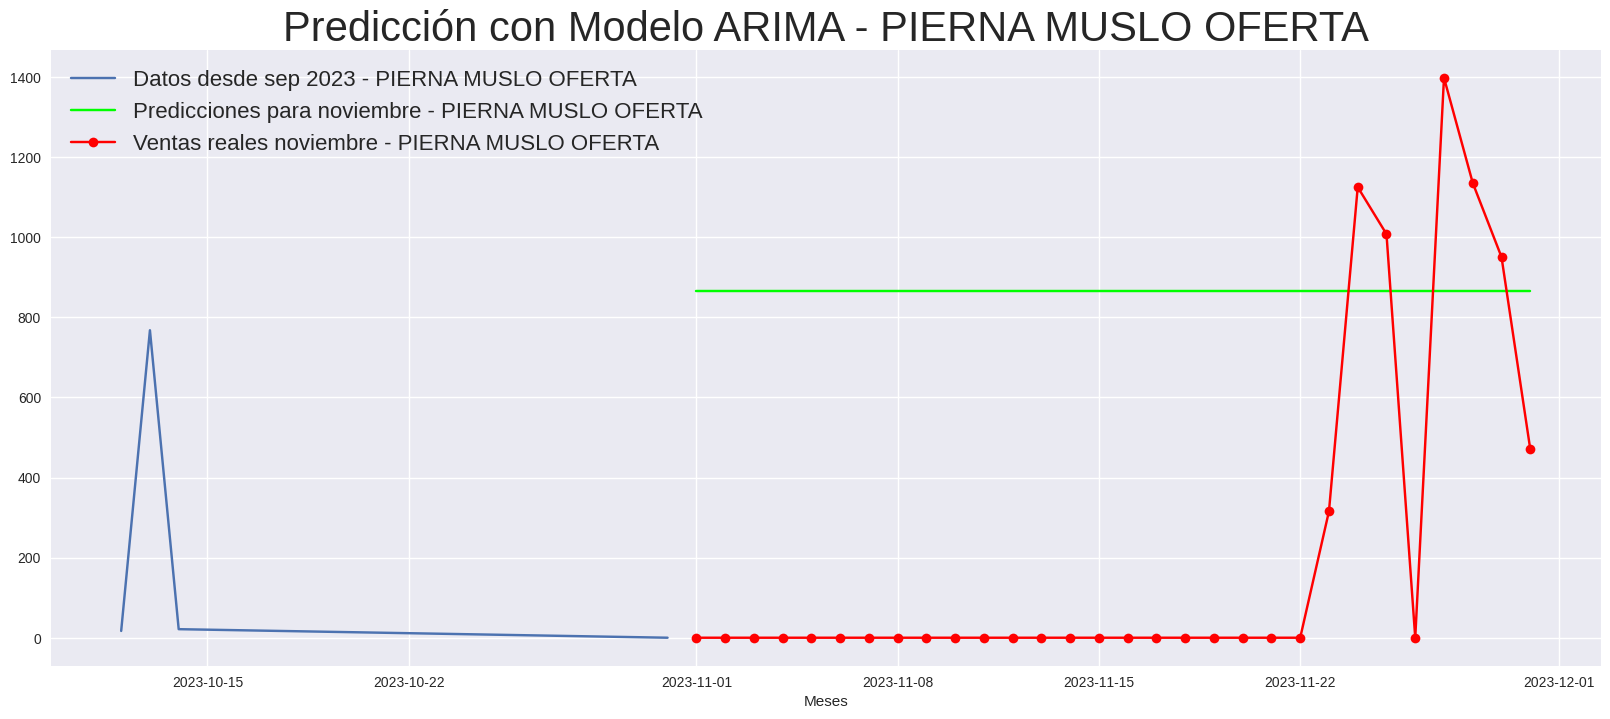

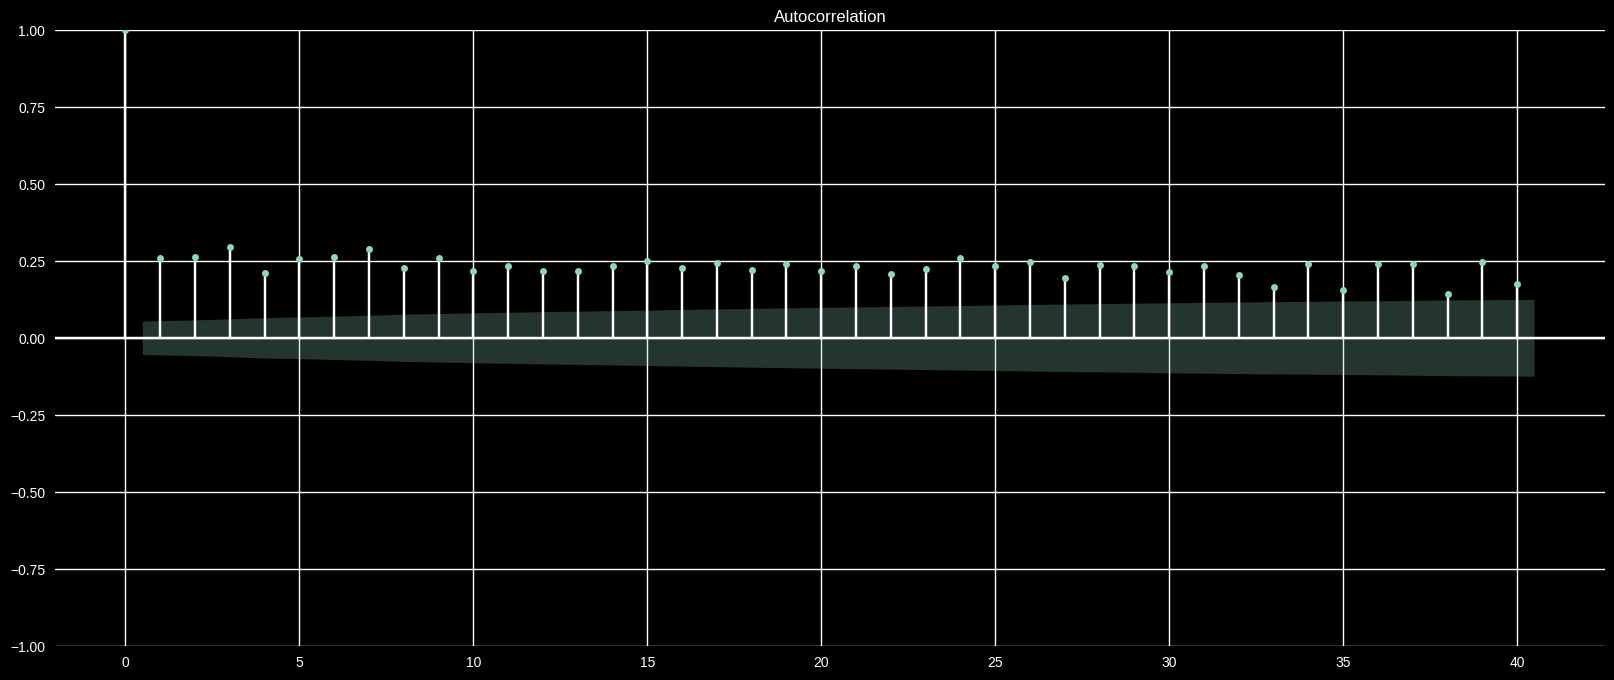

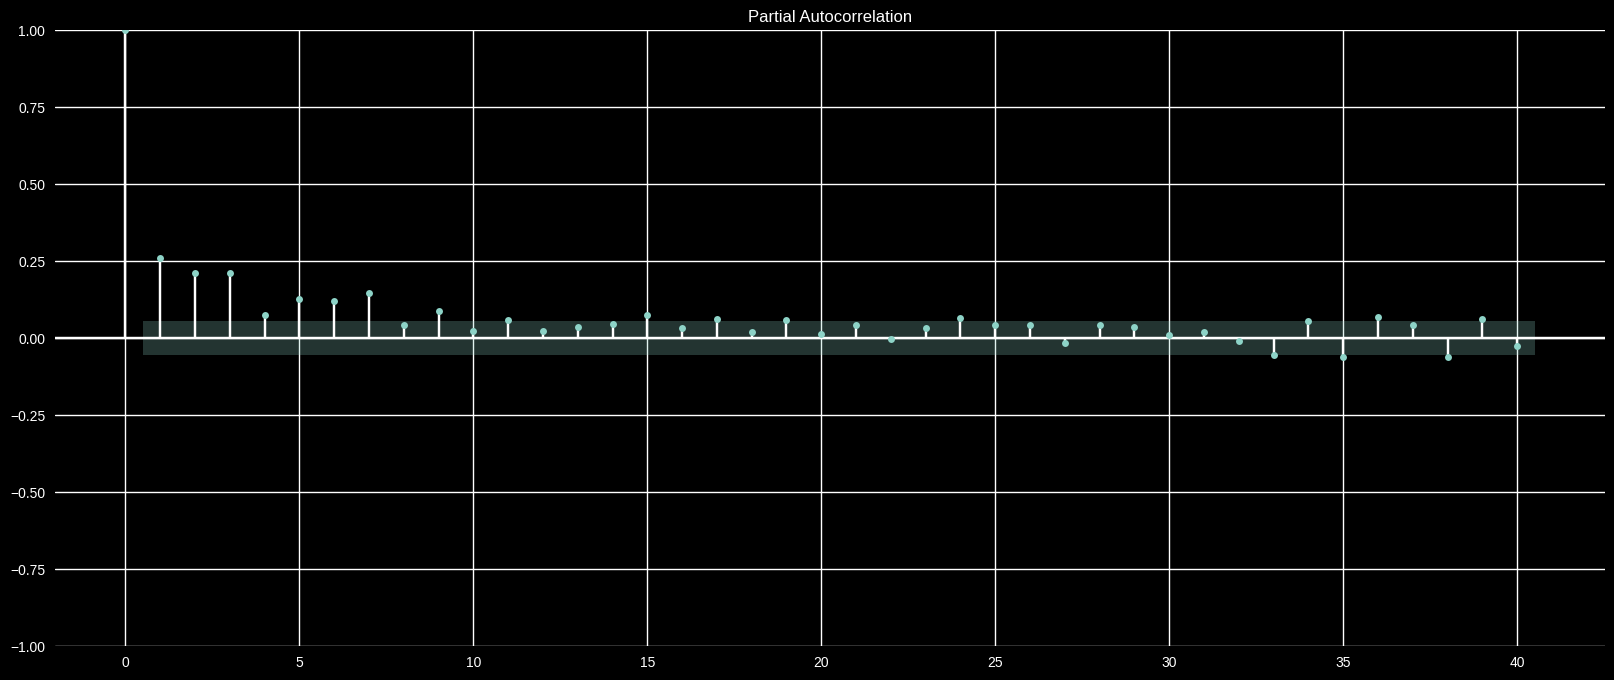

(1263, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=17257.249, Time=7.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18060.476, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17686.901, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17259.229, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18058.477, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=17256.855, Time=5.71 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=17256.058, Time=3.39 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=17256.676, Time=5.97 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=17256.382, Time=1.11 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=17262.353, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=17254.691, Time=2.69 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=17255.614, Time=7.34 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=17255.798, Time=6.63 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=17256.885, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

el ultimo indice_valor de los datos reales es: 1263,
se supone que deeria acabar 30 despues, pero la funcion indica: 1292 

2023-09-06   367.0864
2023-09-07   385.0122
2023-09-08   381.2907
2023-09-09   371.3184
2023-09-10   394.0573
2023-09-11   359.8476
2023-09-12   403.9217
2023-09-13   351.8349
2023-09-14   409.9077
2023-09-15   347.9778
2023-09-16   411.6066
2023-09-17   348.3960
2023-09-18   409.1786
2023-09-19   352.6666
2023-09-20   403.2840
2023-09-21   359.9240
2023-09-22   394.9571
2023-09-23   369.0058
2023-09-24   385.4454
2023-09-25   378.6233
2023-09-26   376.0355
2023-09-27   387.5328
2023-09-28   367.8899
2023-09-29   394.6868
2023-09-30   361.9130
2023-10-01   399.3470
2023-10-02   358.6607
2023-10-03   401.1496
2023-10-04   358.3014
2023-10-05   400.1181
Freq: D, Name: ARIMA Predictions ALA PRIMERA, dtype: float64

Ventas reales y predicciones ARIMA para ALA PRIMERA:
                 MontoBase  P-V_ARIMA_ALA PRIMERA
FechaMovimiento                                  
2

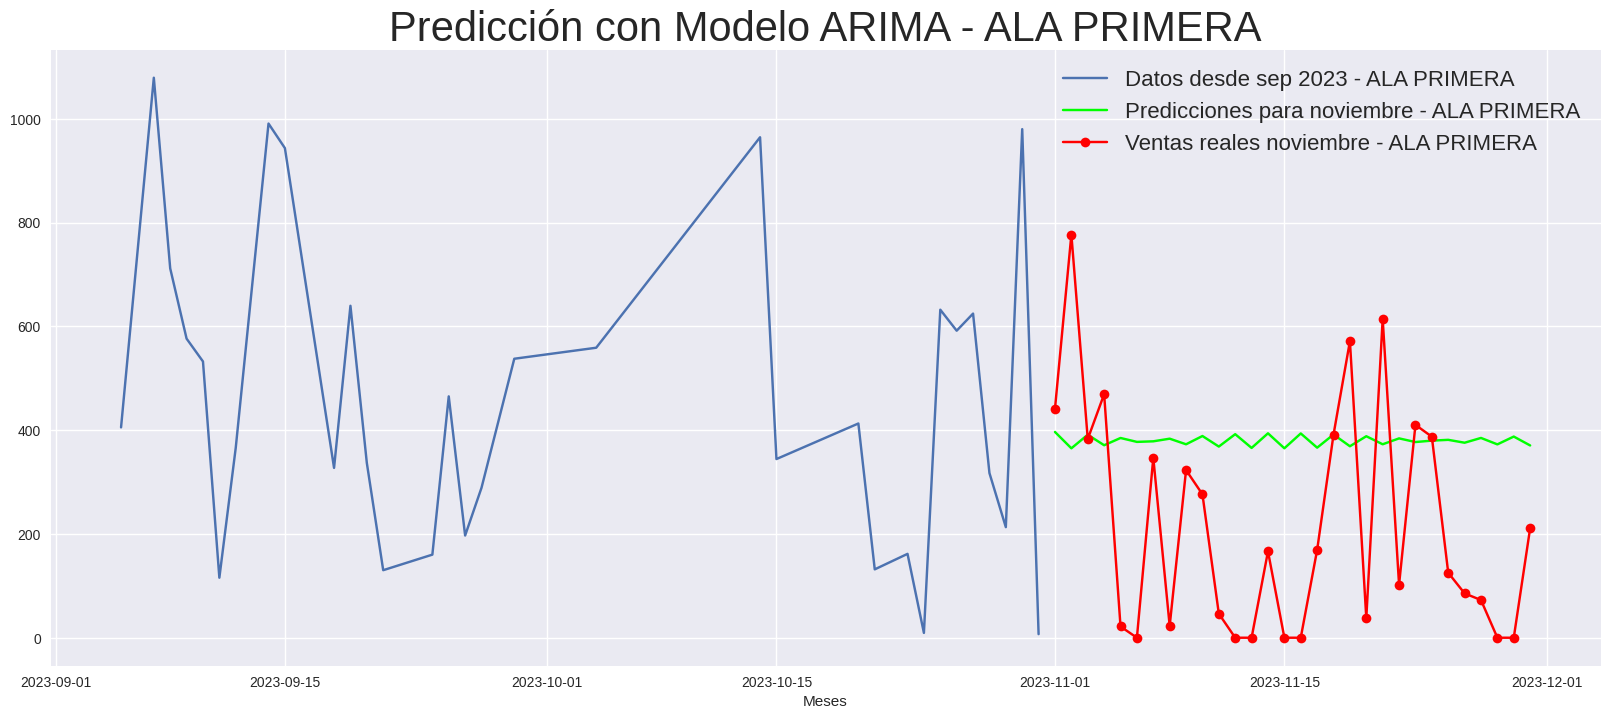

In [ ]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 365:

        # print(f"Predicciones para {product}:")
        # # Realizar descomposición estacional
        # decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        # decomposition.plot();
        # plt.show()

        # Visualizar ACF y PACF
        plt.style.use('dark_background')
        plot_acf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        plot_pacf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        # Dividir en orden cronológico, entrenando sin el mes de octubre
        train_size_arima = int(len(product_df_arima) - 31)
        train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

        print(train_arima.shape, test_arima.shape)

        # Identificar el modelo ARIMA automáticamente
        modelo_auto = auto_arima(train_arima['MontoBase'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
        print(modelo_auto.summary())

        # Configurar el modelo ARIMA
        arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
        arima_result = arima_model.fit()
        arima_models[product] = arima_result  # Guardar el modelo en el diccionario

        # Hacer predicciones con ARIMA
        arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")
        # Crear un índice para las predicciones de noviembre
        november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
        arima_pred.index = november_index

        print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
        print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

        # Imprimir las predicciones para el mes de noviembre
        print(arima_pred)

        # Agregar las predicciones al DataFrame original
        if product in arima_models:
            # Hacer predicciones con ARIMA para el DataFrame actual
            arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

            # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
            arima_pred_full.index = dfs_noviembre_sumados[product].index

            # Agregar la columna de predicciones ARIMA al DataFrame actual
            dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

            # Imprimir el resultado
            print(f'\nVentas reales y predicciones ARIMA para {product}:')
            print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
        else:
            print(f"No hay modelo ARIMA para {product}.")

        # Visualizar las predicciones y los datos reales
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (20, 8)
        # Datos de venta desde el 1ro de septiembre de 2023
        start_date = pd.to_datetime('2023-09-01')
        end_date = pd.to_datetime('2023-11-30')
        plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
        plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
        plt.xlabel('Meses')
        plt.ylabel('')
        plt.legend(fontsize=16)
        plt.show()
    else:
        print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

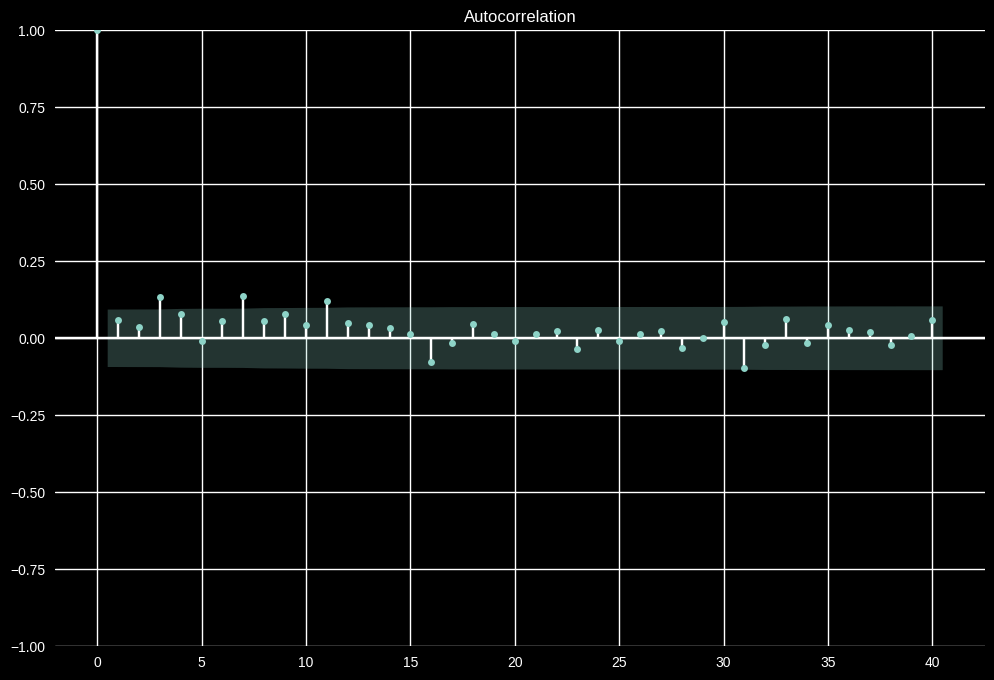

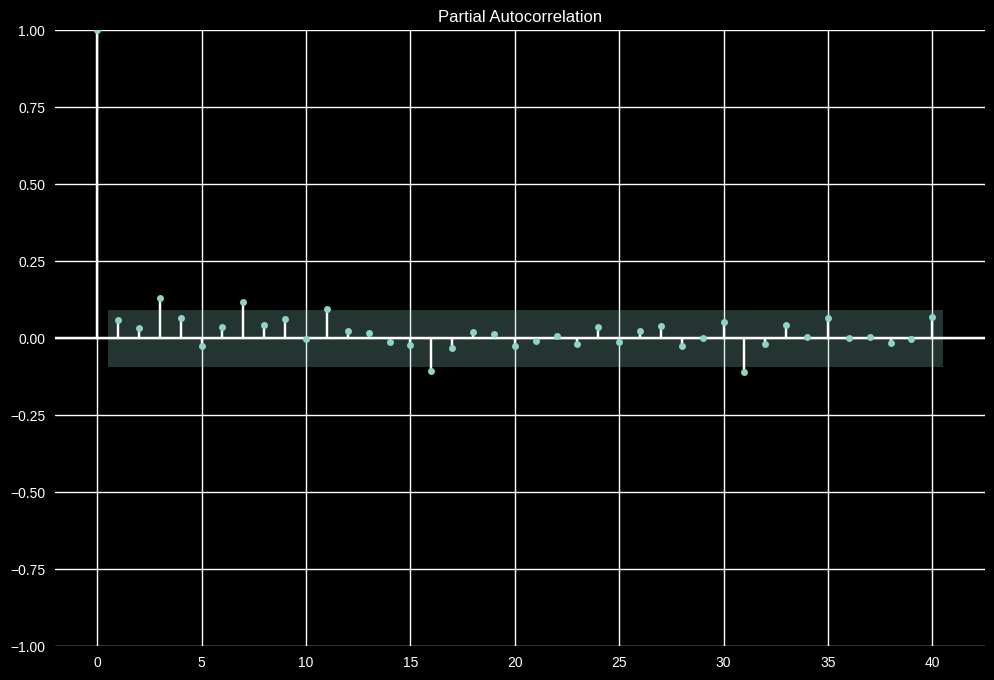

In [ ]:
# # decomposition = seasonal_decompose(dfs_de_productos_sumados_arima['PIERNA MUSLO OFERTA']["MontoBase"], model="add", period=30)
# # decomposition.plot();
# # plt.show()
# # print(dfs_de_productos_sumados_arima['PIERNA MUSLO OFERTA']["MontoBase"])

# # Visualizar ACF y PACF
# plt.style.use('dark_background')
# plot_acf(dfs_de_productos_sumados_arima['PIERNA MUSLO OFERTA']['MontoBase'], lags=40)
# plt.show()

# plot_pacf(dfs_de_productos_sumados_arima['PIERNA MUSLO OFERTA']['MontoBase'], lags=40)
# plt.show()

In [126]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229   
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895   
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652   
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834   
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420   
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758   
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938   
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792   
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104   
2023-11-10       POLLO SIN MENUDENCIA H-C     0.0000   
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036   
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644   
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683   
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658   
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350   
2023-11-16       POLLO SIN MENUDENCIA H-C   943.

In [ ]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [127]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 695033.7422767633
MAE is : 629.9666248615184
R2 is : -0.9136356029442898 %
------------------------------
RMSE is : 833.6868370537965
MAPE is : 102.68652023222545 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 356444.0411635147
MAE is : 499.75427893822973
R2 is : -0.45899412245319104 %
------------------------------
RMSE is : 597.029346986825
MAPE is : 108.56296113922865 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PECHUGA
Evaluation metric results:  
MSE is : 119492.0771516397
MAE is : 287.5569182820337
R2 is : -0.028661769021775196 %
------------------------------
RMSE i

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-128-18dcb7d60c8b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


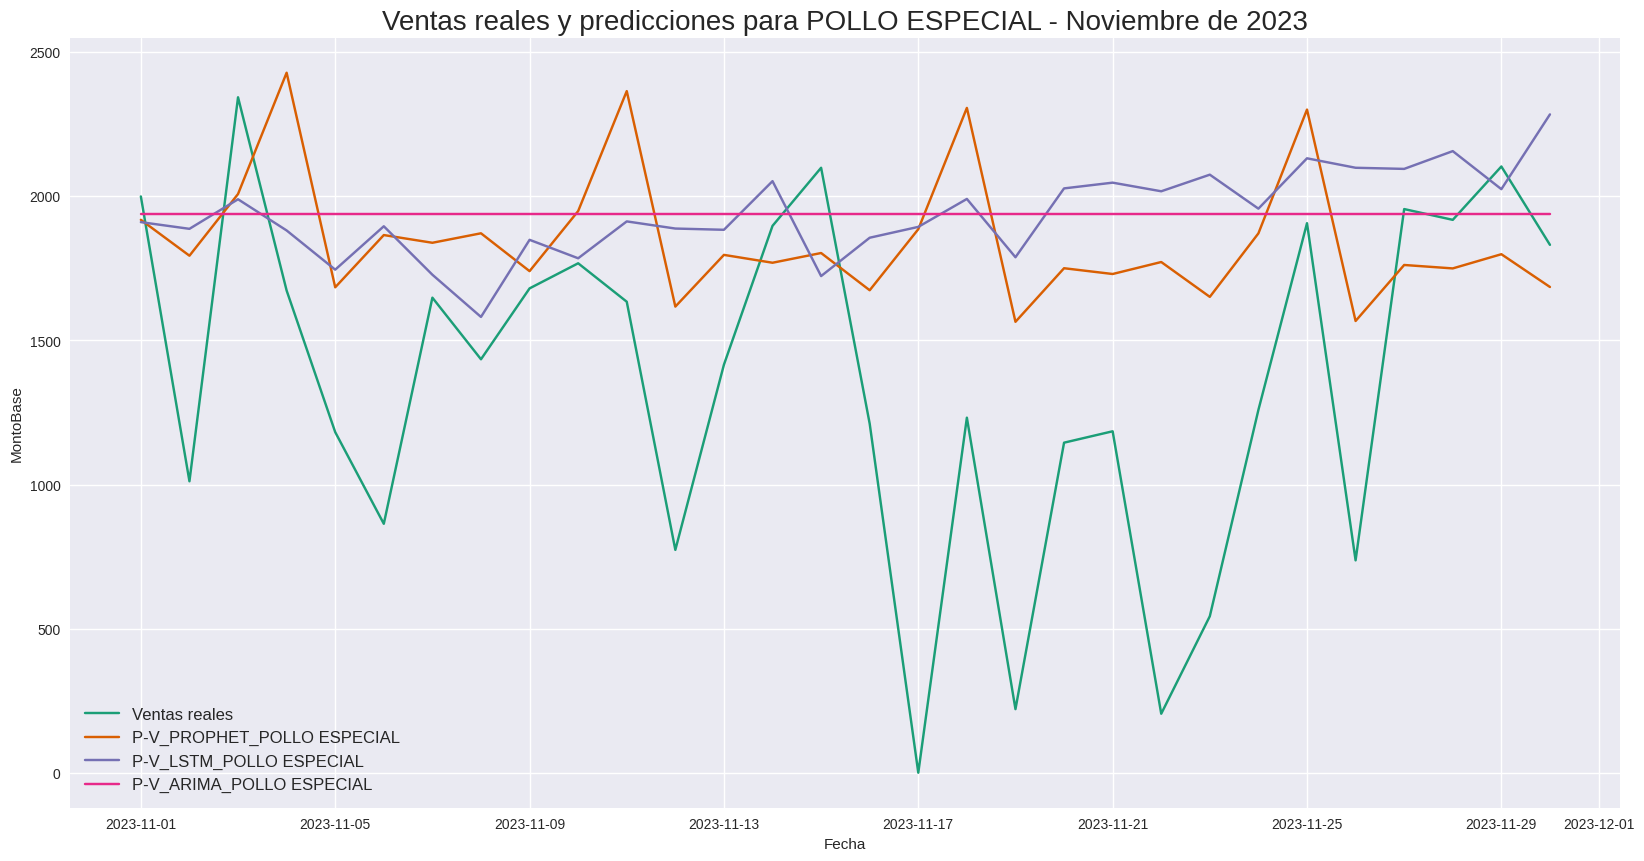

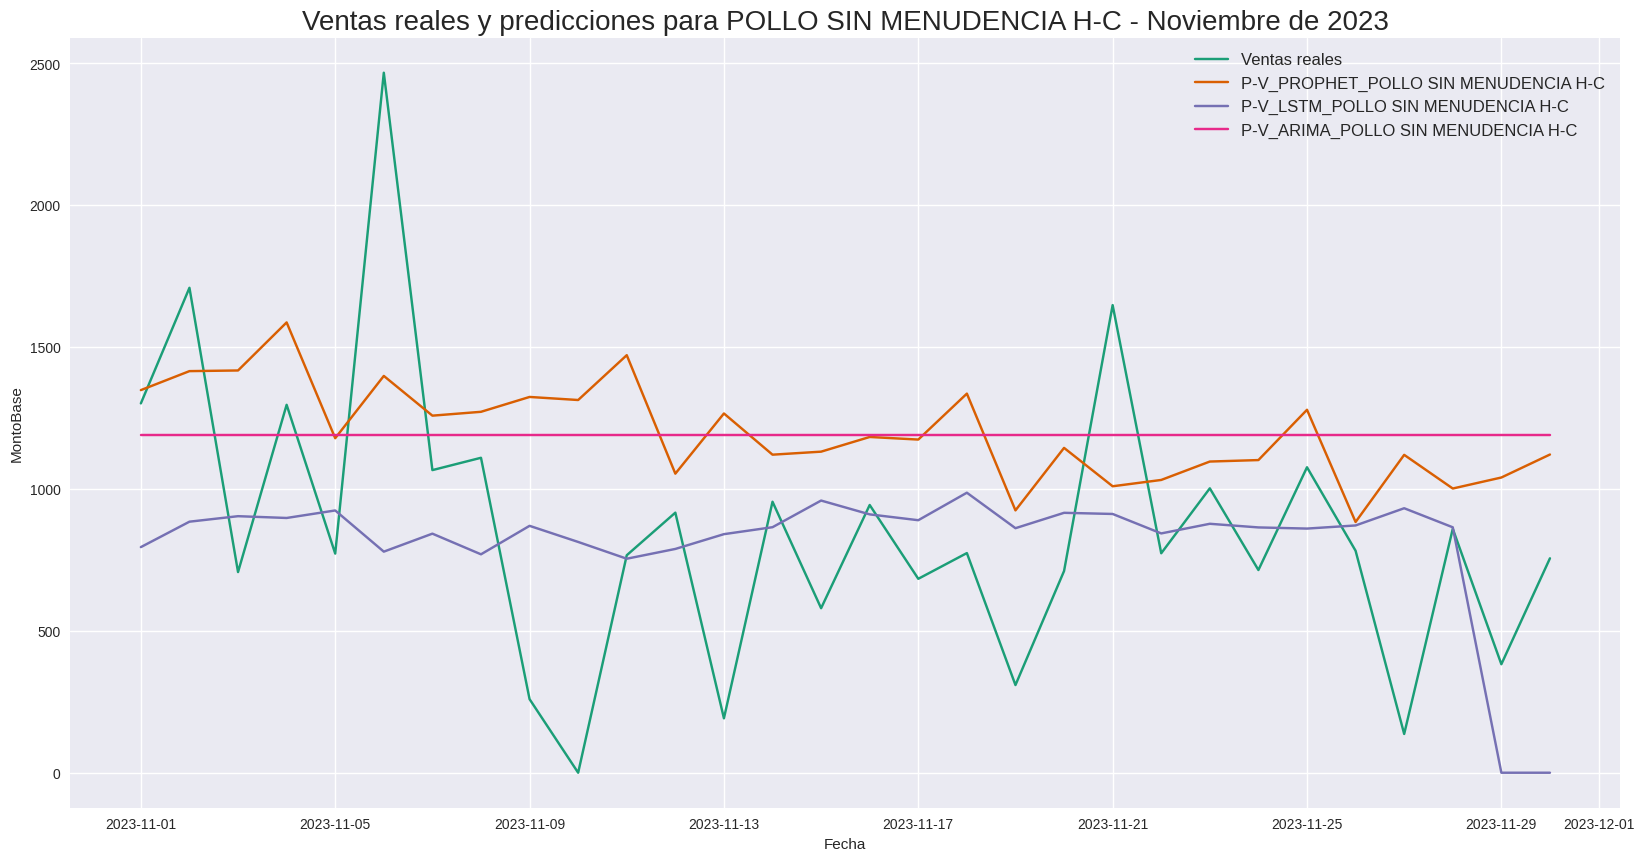

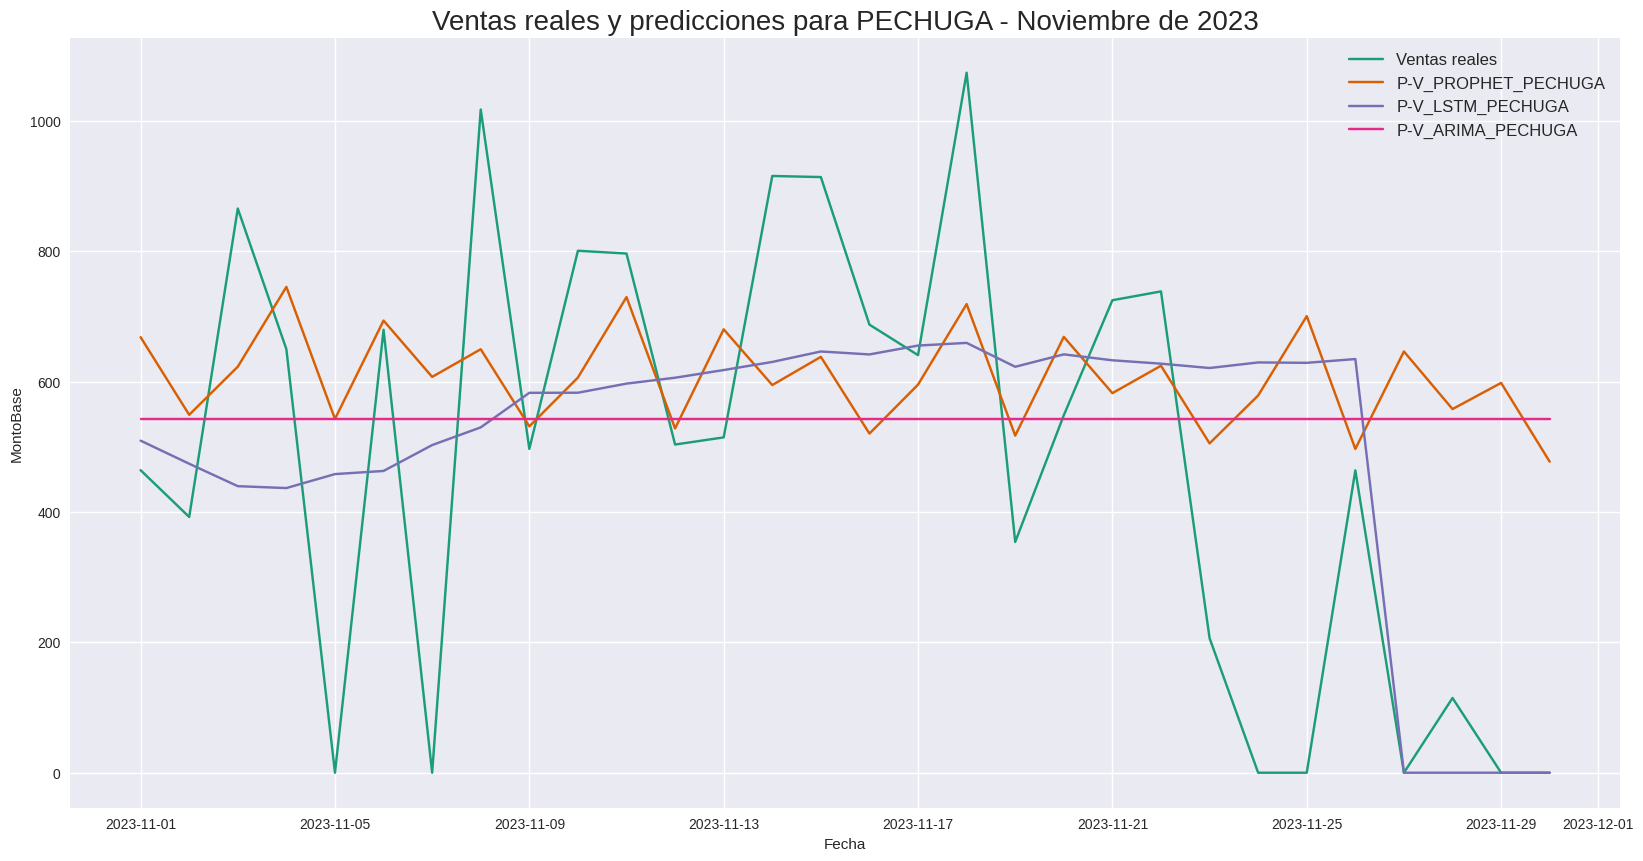

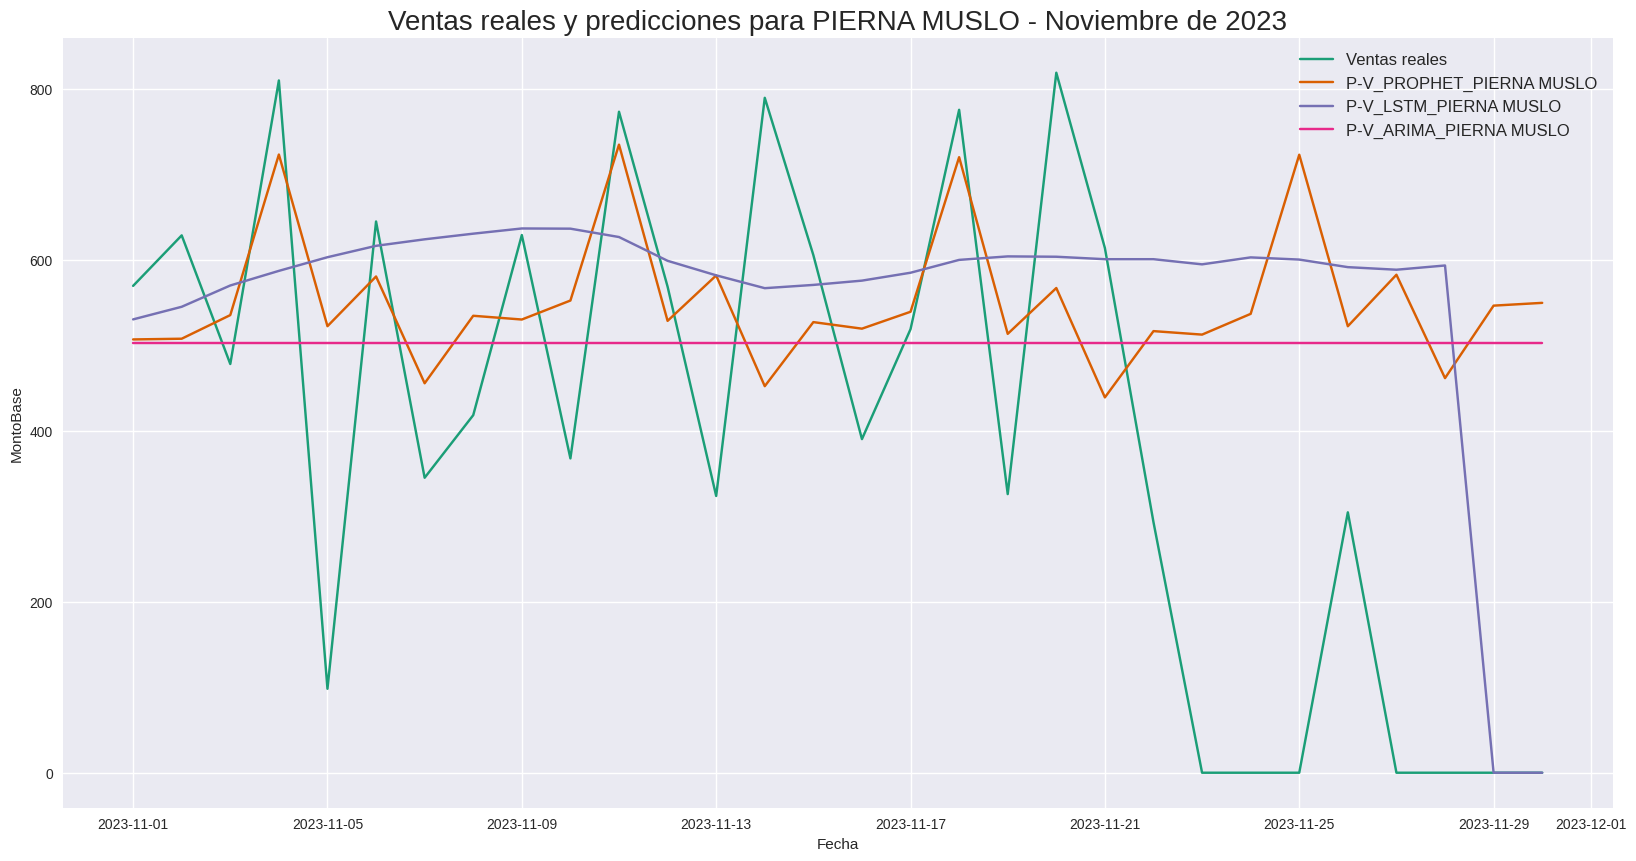

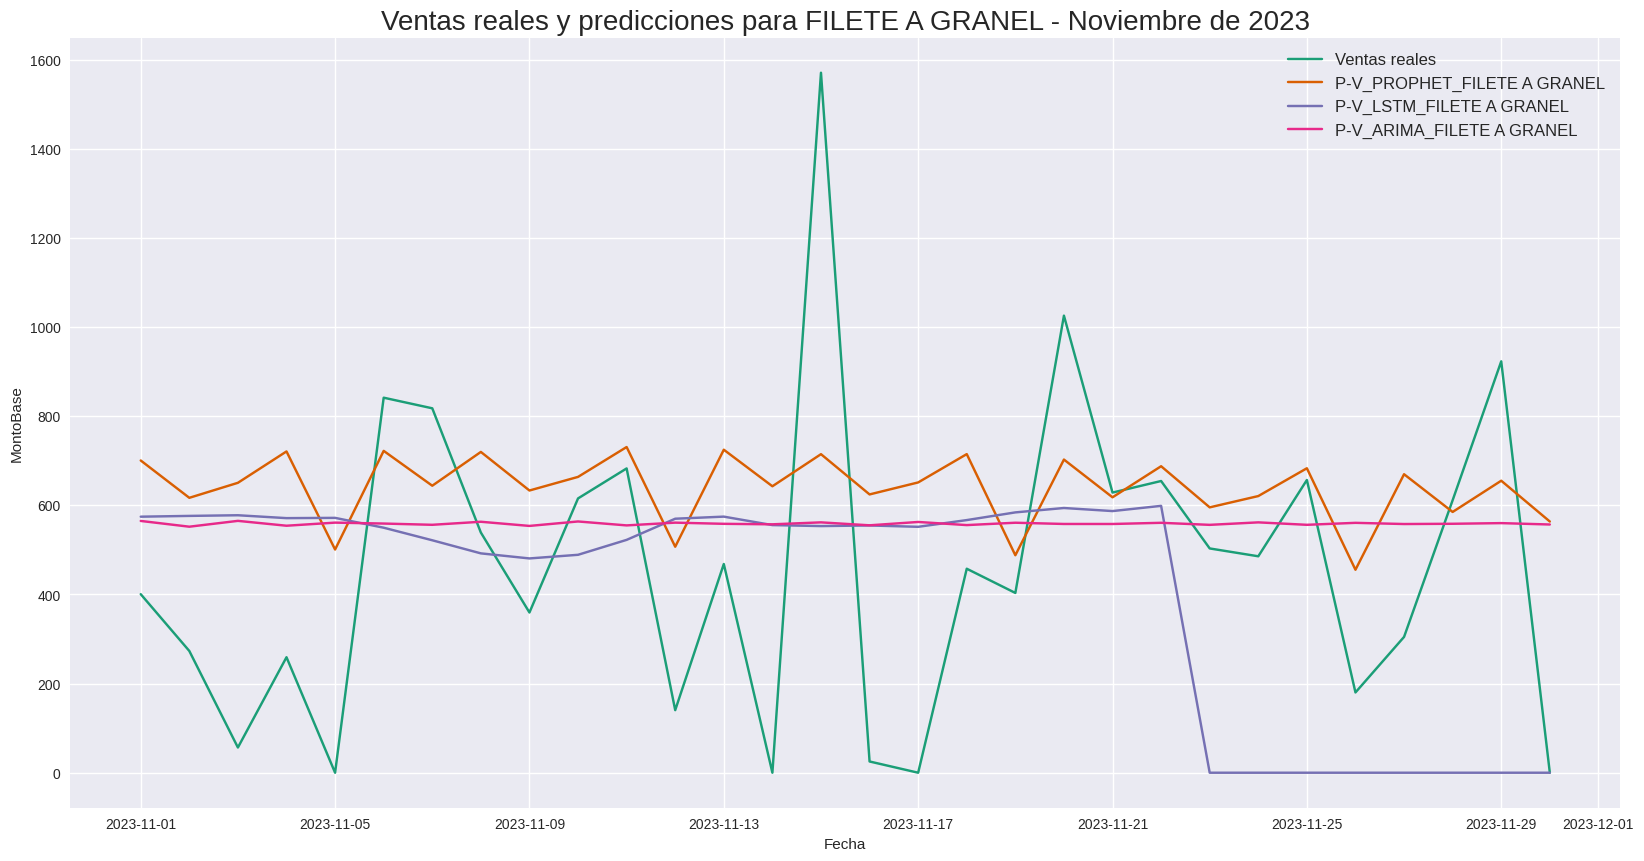

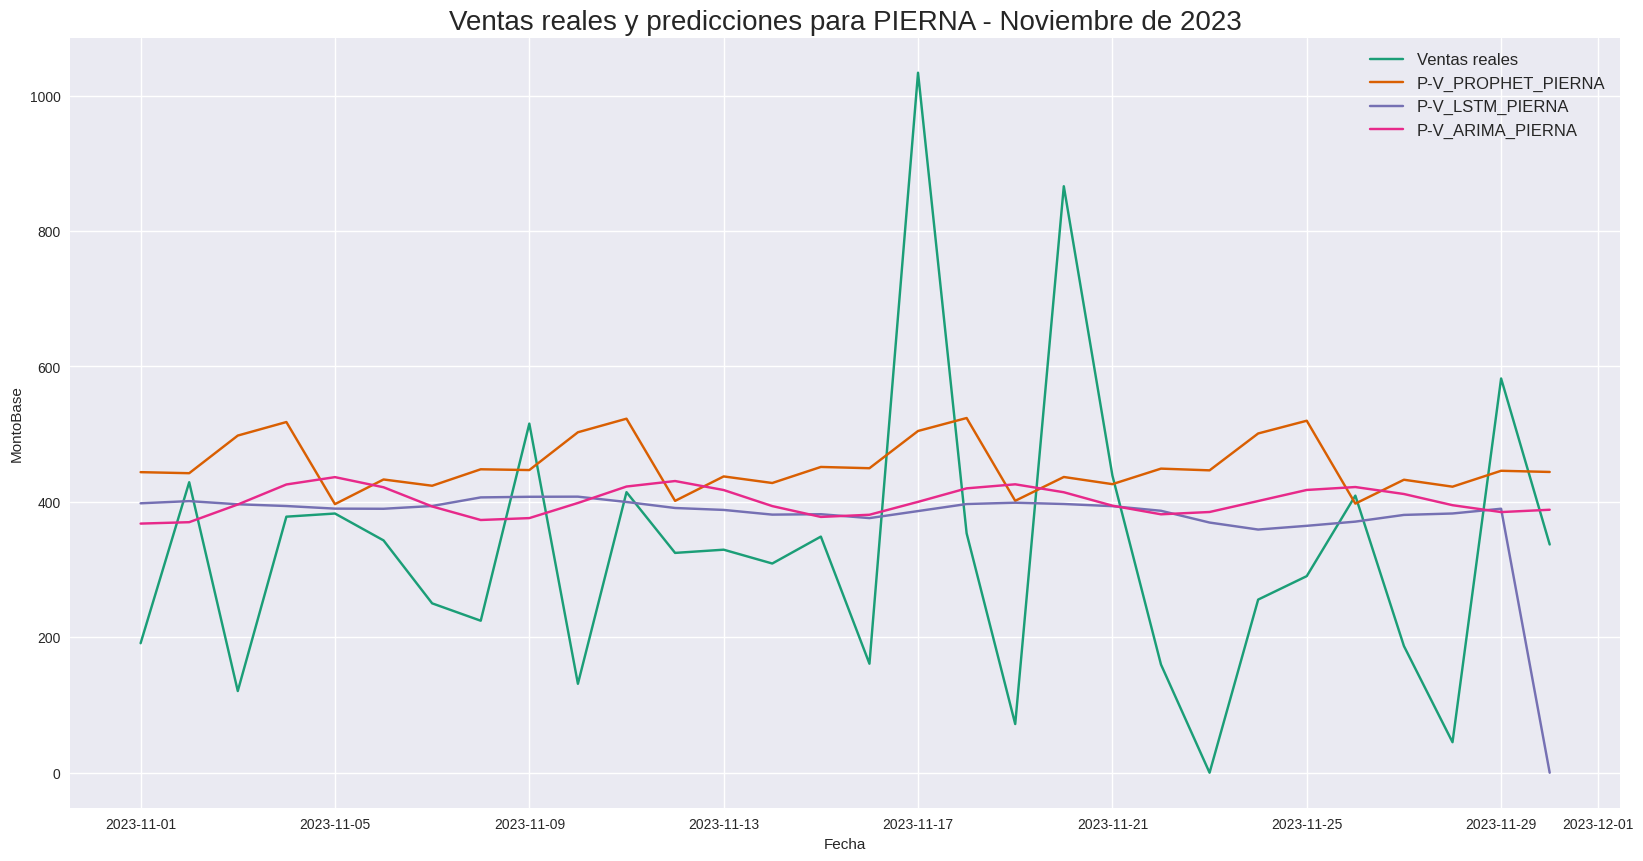

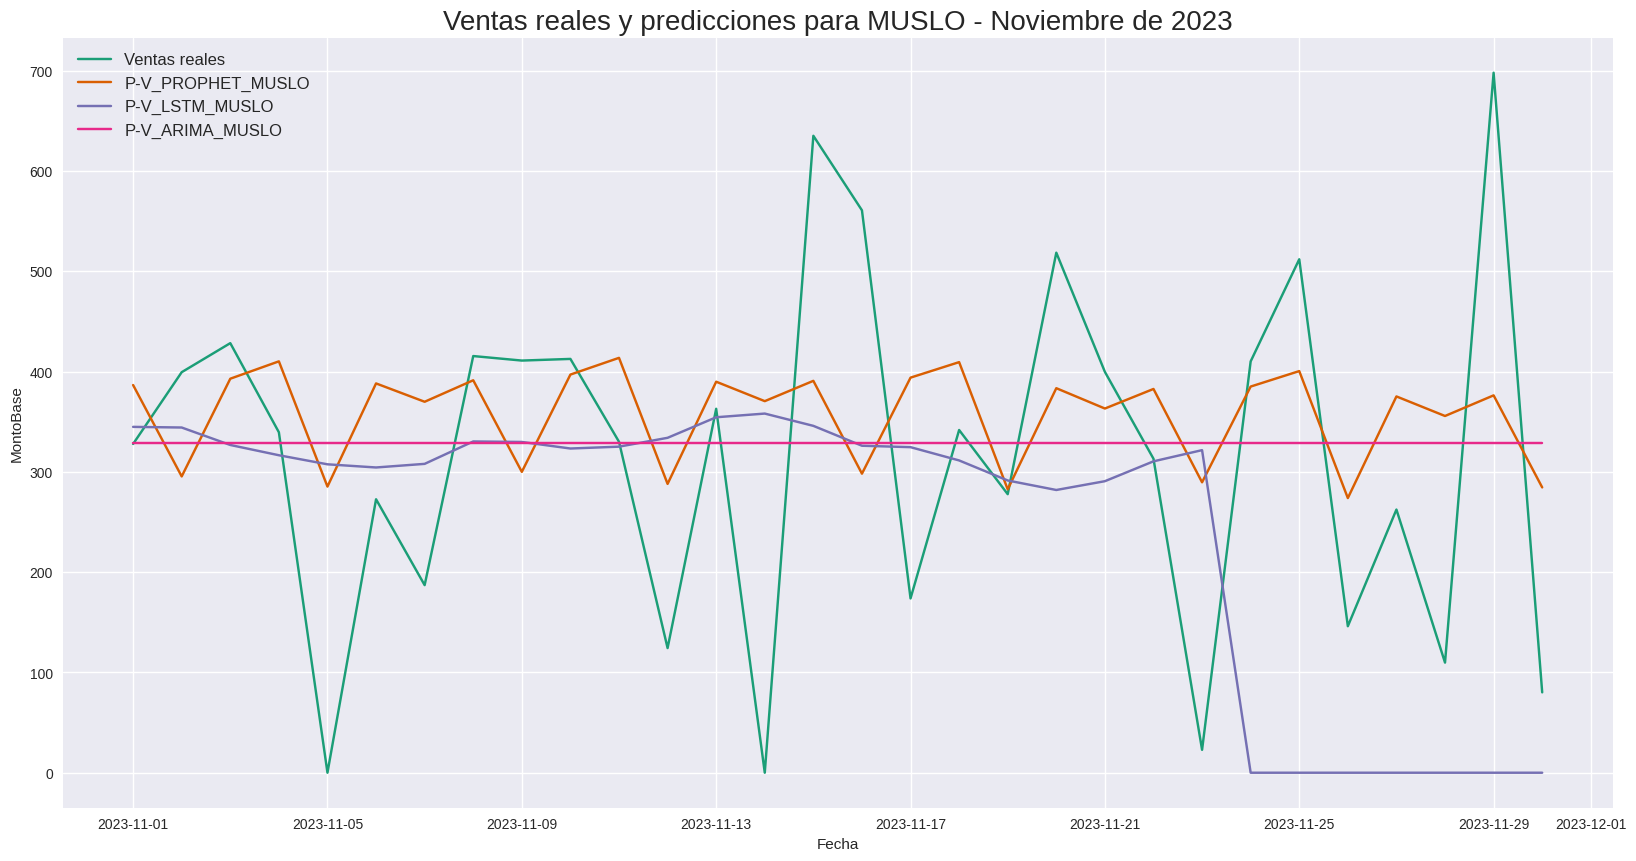

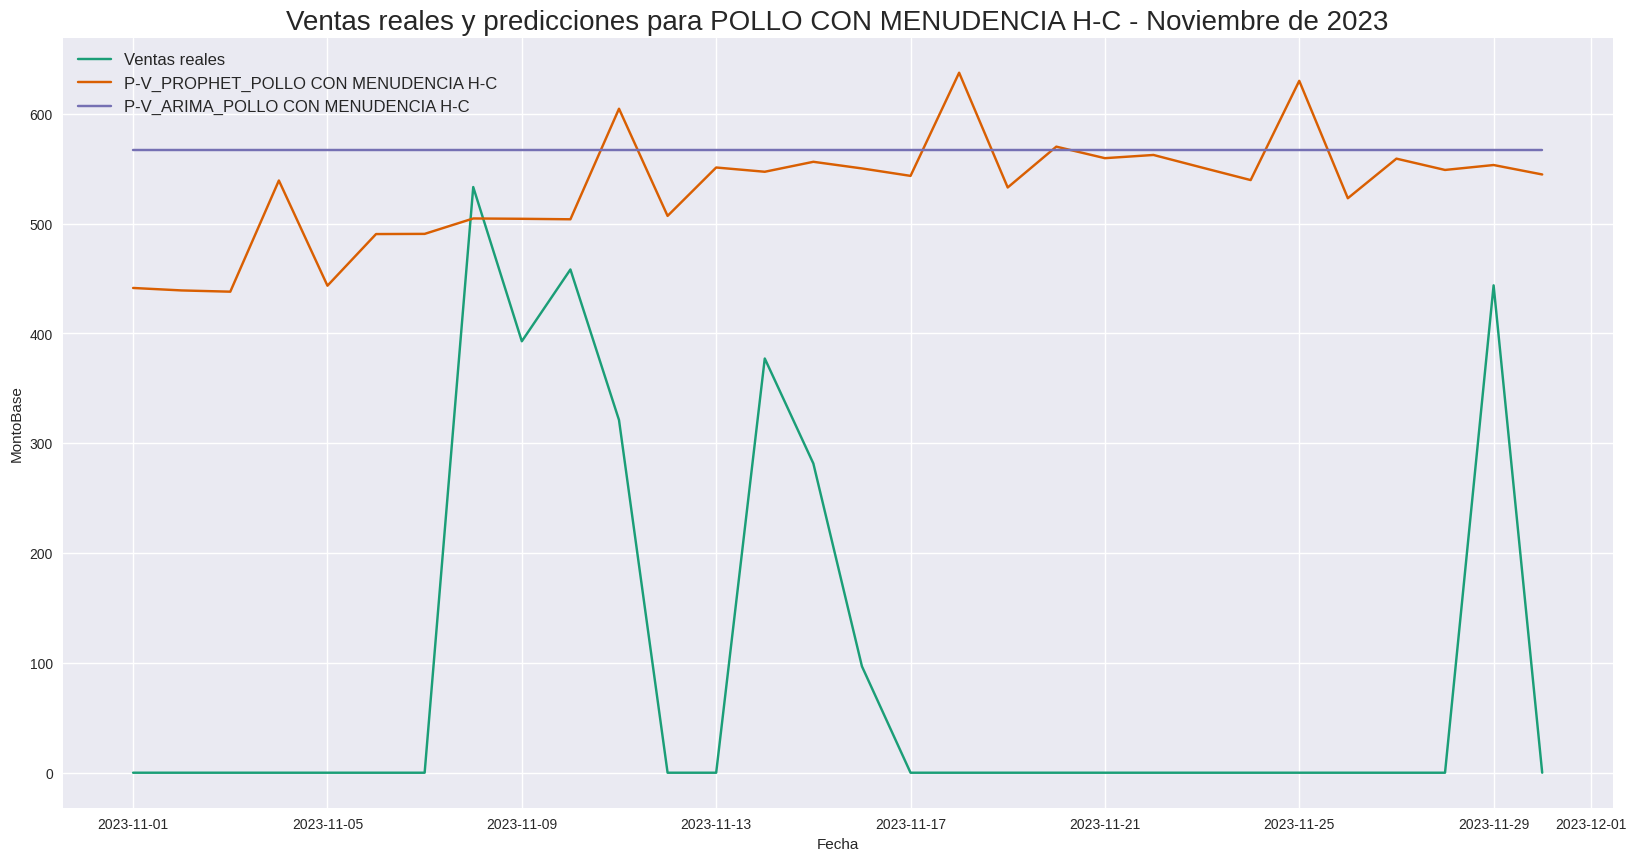

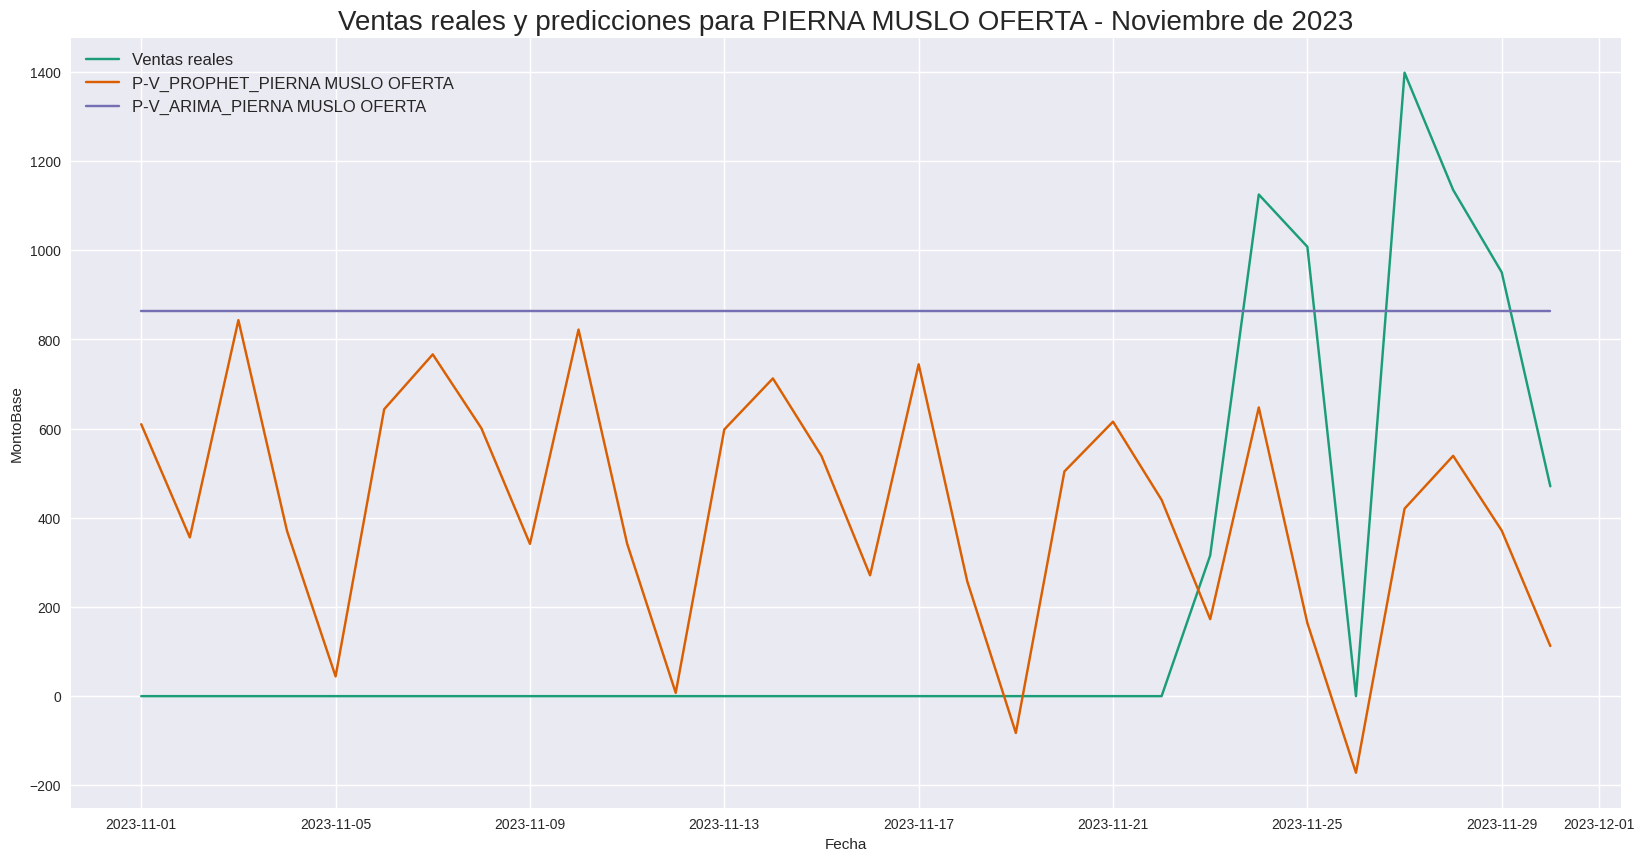

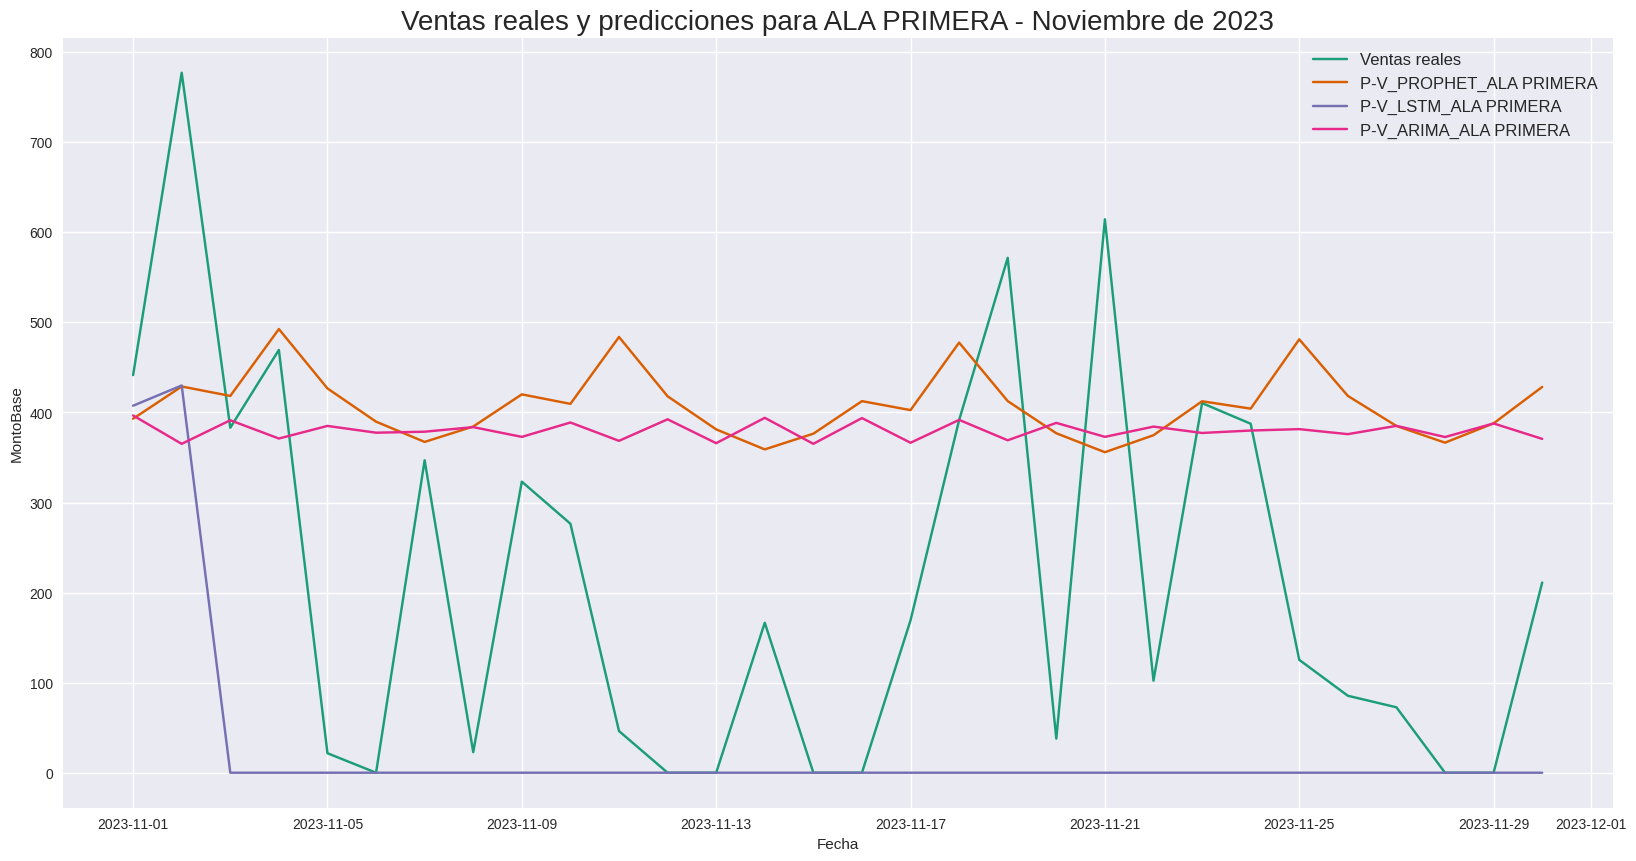

In [128]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales')

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [146]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO ESPECIAL
Modelo: PROPHET
Evaluation metric results:  
MSE is : 560103.3907274955
MAE is : 598.4645365089967
R2 is : -0.5421320212668848 %
------------------------------
RMSE is : 748.4005550021295
MAPE is : 89.09332855260458 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 698927.842865503
MAE is : 636.0269437760418
R2 is : -0.9243572256149362 %
------------------------------
RMSE is : 836.0190445590956
MAPE is : 102.61877194260518 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 695033.7422767633
MAE is : 629.9666248615184
R2 is : -0.9136356029442898 %
------------------------------
RMSE is : 833.6868370537965
MAPE is : 102.6865202322254

In [156]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.dtypes)
#    print(product_df.columns)

NombreProducto                 object
MontoBase                     float64
P-V_PROPHET_POLLO ESPECIAL    float64
P-V_LSTM_POLLO ESPECIAL       float32
P-V_ARIMA_POLLO ESPECIAL      float64
dtype: object
NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float64
P-V_ARIMA_POLLO SIN MENUDENCIA H-C      float64
dtype: object
NombreProducto          object
MontoBase              float64
P-V_PROPHET_PECHUGA    float64
P-V_LSTM_PECHUGA       float64
P-V_ARIMA_PECHUGA      float64
dtype: object
NombreProducto               object
MontoBase                   float64
P-V_PROPHET_PIERNA MUSLO    float64
P-V_LSTM_PIERNA MUSLO       float64
P-V_ARIMA_PIERNA MUSLO      float64
dtype: object
NombreProducto                  object
MontoBase                      float64
P-V_PROPHET_FILETE A GRANEL    float64
P-V_LSTM_FILETE A GRANEL       float64
P-V_ARIMA_FILETE A GRAN

In [130]:
dfs_noviembre_sumados

{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
 FechaMovimiento                                                          
 2023-11-01       POLLO ESPECIAL  1999.7321                   1918.6519   
 2023-11-02       POLLO ESPECIAL  1011.2892                   1794.0805   
 2023-11-03       POLLO ESPECIAL  2343.7883                   2008.2326   
 2023-11-04       POLLO ESPECIAL  1673.2089                   2429.0343   
 2023-11-05       POLLO ESPECIAL  1181.9289                   1684.4395   
 2023-11-06       POLLO ESPECIAL   863.7984                   1865.7316   
 2023-11-07       POLLO ESPECIAL  1648.4580                   1838.9538   
 2023-11-08       POLLO ESPECIAL  1434.6711                   1871.8651   
 2023-11-09       POLLO ESPECIAL  1680.6493                   1740.4964   
 2023-11-10       POLLO ESPECIAL  1767.7892                   1948.9530   
 2023-11-11       POLLO ESPECIAL  1634.3693                   2365.2701   
 2023-1